# SETUP

In [30]:
USE_GPU = False

In [31]:
!pip install --upgrade pip tensorflow keras jupyterlab-vim jupyterlab-indent-guides maap-user-workspace-management-jupyter-extension pydot
!apt-get install graphviz -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
The following packages were automatically installed and are no longer required:
  gyp javascript-common libauthen-sasl-perl libc-ares2 libclone-perl
  libdata-dump-perl libencode-locale-perl libfile-basedir-perl
  libfile-desktopentry-perl libfile-listing-perl libfile-mimeinfo-perl
  libfont-afm-perl libfontenc1 libgtkd-3-0 libhtml-form-perl
  libhtml-format-perl libhtml-parser-perl libhtml-tagset-perl
  libhtml-tree-perl libhttp-cookies-perl libhttp-daemon-perl libhttp-date-perl
  libhttp-message-perl libhttp-negotiate-perl libio-html-perl
  libio-socket-ssl-perl libio-stringy-perl libipc-system-simple-perl
  libjs-events libjs-highlight.js libjs-inherits libjs-is-typedarray libjs-psl
  libjs-source-map libjs-sprintf-js libjs-typedarray-to-buffer libllvm11
  liblwp-mediatypes-perl liblwp-protocol-https-perl libmailtools-perl
  lib

In [32]:
!jupyter labextension list

JupyterLab v4.4.5
/usr/local/share/jupyter/labextensions
        jupyterlab_pygments v0.2.2 enabled  X (python, jupyterlab_pygments)
        jupyter-matplotlib v0.11.7 enabled OK
        maap-user-workspace-management-jupyter-extension v0.1.5 enabled OK (python, maap_user_workspace_management_jupyter_extension)
        jupyterlab-indent-guides v0.1.0 enabled OK (python, jupyterlab-indent-guides)
        @jupyter-widgets/jupyterlab-manager v5.0.9 enabled OK (python, jupyterlab_widgets)
        @jupyter-notebook/lab-extension v7.0.5 enabled OK
        @axlair/jupyterlab_vim v4.1.4 enabled OK (python, jupyterlab_vim)


   The following extensions may be outdated or specify dependencies that are incompatible with the current version of jupyterlab:
        jupyterlab_pygments
        
   If you are a user, check if an update is available for these packages.
   If you are a developer, re-run with `--verbose` flag for more details.

Other labextensions (built into JupyterLab)
   app dir: /usr

## Libraries

In [33]:
# System
import os
import glob
import shutil
import copy
import re
from datetime import datetime
import logging

# Data
import numpy as np
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Data processing
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Model
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras import Input, Model, Sequential
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Dropout, GRU, Conv1D, MaxPooling1D, Flatten
from keras.utils import plot_model
from keras.saving import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.losses import MeanAbsoluteError, MeanSquaredError, Huber
from keras.models import load_model
import keras.backend as K

# Custom libraries written by myself
from src.plot import plot_1_data, plot_2_data, plot_prediction
from src.reduction_model.lstm_s2s import LSTMSeq2SeqReduction
from src.reduction_model.gru_s2s import GRUSeq2SeqReduction
from src.reduction_model.cnnlstm_s2s import CNNLSTMSeq2SeqReduction
from src.prediction_model.lstm import LSTMPrediction
from src.time_series_utils import splitTrainValidationTestTimeSeries, reframePastFuture, padPastFuture
from src.data_utils import mice

# Configuration reader
from src.config_reader import ConfigurationReader

# Configure device
if not USE_GPU:
    print("Using CPU to train")
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
else:
    print("Using GPU to train")

# Checking Tensorflow
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_physical_devices('CPU'))

Using CPU to train
2.20.0
[]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## Configuration

In [34]:
confReader = ConfigurationReader("/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/model_params.json")
print(confReader)

conf = confReader.data
print(conf)

{
    "dataset": {
        "aod2022": {
            "file_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/MatchingData2022.xlsx",
            "target_start_date": "2022-01-01",
            "target_end_date": "2022-12-31"
        },
        "aod2021": {
            "file_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/aod_data_daily.csv",
            "target_start_date": "2021-01-01",
            "target_end_date": "2021-12-31"
        },
        "mpair": {
            "file_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/MPair.csv",
            "target_start_date": "2021-01-01",
            "target_end_date": "2022-12-31",
            "station_2022_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/station2022.csv",
            "station_2018_2021_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/station2018-2021.c

# MPAIR DATA ALL LOCATIONS

## Load MPair dataset

* Every row has a tuple (i, j) which marks a "cell" in the Ho Chi Minh City grid map

| i/j | 0 | 1 | 2 | ... |
|-----|---|---|---|-----|
| 0   |   |   |   |     |
| 1   |   |   |   |     |
| 2   |   |   |   |     |
| ... |   |   |   |     |

* Every cell has its own geographical characteristics
* Every cell represent values of a specific date and specific location

### Raw data

In [35]:
df_mpair_raw = pd.read_csv(conf["dataset"]["mpair"]["merged_data_dir_all_locations"], index_col=None)
df_mpair_raw

i   j        lat         lon        time   pm25_3km        tmp  \
0        0   3  11.149747  106.369103  2021-01-01  26.040001  25.114687   
1        0   3  11.149747  106.369103  2021-01-02  39.470001  24.043423   
2        0   3  11.149747  106.369103  2021-01-03  40.619999  25.058735   
3        0   3  11.149747  106.369103  2021-01-04  40.330002  25.554197   
4        0   3  11.149747  106.369103  2021-01-05  50.009998  25.037054   
...     ..  ..        ...         ...         ...        ...        ...   
713205  34  27  10.385233  106.918383  2022-12-27  19.874584  24.644707   
713206  34  27  10.385233  106.918383  2022-12-28  17.509365  25.071791   
713207  34  27  10.385233  106.918383  2022-12-29  18.428423  25.458431   
713208  34  27  10.385233  106.918383  2022-12-30  12.645213  24.636055   
713209  34  27  10.385233  106.918383  2022-12-31  16.706522  24.775455   

               rh        hpbl      wspd  ...      bareland       builtup  \
0       63.633778  567.478943  4.660580  ...  14453.144036  30347.516088   
1       69.082085  485.584290  3.288929  ...  14453.144036  30347.516088   
2       67.647362  403.936310  2.731468  ...  14453.144036  30347.516088   
3       71.023094  704.476807  3.522596  ...  14453.144036  30347.516088   
4       74.029236  534.426575  3.223711  ...  14453.144036  30347.516088   
...           ...         ...       ...  ...           ...           ...   
713205  76.055573  441.420624  2.561953  ...  24482.287914  48934.328055   
713206  78.165489  403.261658  2.126233  ...  24482.287914  48934.328055   
713207  79.421234  425.696411  1.909332  ...  24482.287914  48934.328055   
713208  76.198395  241.369736  2.530340  ...  24482.287914  48934.328055   
713209  76.337906  432.667236  2.036375  ...  24482.287914  48934.328055   

            cropland      grassland      treecover          water  ndvi  \
0       54101.838731  203551.710735  683877.574149   13604.234765   NaN   
1       54101.838731  203551.710735  683877.574149   13604.234765   NaN   
2       54101.838731  203551.710735  683877.574149   13604.234765   NaN   
3       54101.838731  203551.710735  683877.574149   13604.234765   NaN   
4       54101.838731  203551.710735  683877.574149   13604.234765   NaN   
...              ...            ...            ...            ...   ...   
713205   8711.125789  154921.372745   91390.837123  426893.893429   NaN   
713206   8711.125789  154921.372745   91390.837123  426893.893429   NaN   
713207   8711.125789  154921.372745   91390.837123  426893.893429   NaN   
713208   8711.125789  154921.372745   91390.837123  426893.893429   NaN   
713209   8711.125789  154921.372745   91390.837123  426893.893429   NaN   

             aod  station  pm25  
0            NaN      NaN   NaN  
1            NaN      NaN   NaN  
2            NaN      NaN   NaN  
3       0.555355      NaN   NaN  
4            NaN      NaN   NaN  
...          ...      ...   ...  
713205       NaN      NaN   NaN  
713206       NaN      NaN   NaN  
713207  0.174487      NaN   NaN  
713208       NaN      NaN   NaN  
713209       NaN      NaN   NaN  

[713210 rows x 24 columns]

In [36]:
df_mpair_raw.columns

Index(['i', 'j', 'lat', 'lon', 'time', 'pm25_3km', 'tmp', 'rh', 'hpbl', 'wspd',
       'pop', 'road_den_1km', 'prim_road_len_1km', 'near_dist', 'bareland',
       'builtup', 'cropland', 'grassland', 'treecover', 'water', 'ndvi', 'aod',
       'station', 'pm25'],
      dtype='object')

In [37]:
df_mpair_raw.isnull().sum()

i                         0
j                         0
lat                       0
lon                       0
time                      0
pm25_3km                  0
tmp                       0
rh                        0
hpbl                      0
wspd                      0
pop                       0
road_den_1km              0
prim_road_len_1km    708830
near_dist                 0
bareland                  0
builtup                   0
cropland                  0
grassland                 0
treecover                 0
water                     0
ndvi                 556260
aod                  429477
station              709195
pm25                 710637
dtype: int64

### Handle metadata

In [38]:
# Convert "time" columns to Pandas datetime
df_mpair_raw = df_mpair_raw.assign(time=pd.to_datetime(df_mpair_raw["time"]))

# Set "time" column as index
df_mpair_raw.set_index("time", inplace=True)

# Convert the -9999 to nan
df_mpair_raw[df_mpair_raw <= -9999] = np.nan

# Print
df_mpair_raw

i   j        lat         lon   pm25_3km        tmp         rh  \
time                                                                         
2021-01-01   0   3  11.149747  106.369103  26.040001  25.114687  63.633778   
2021-01-02   0   3  11.149747  106.369103  39.470001  24.043423  69.082085   
2021-01-03   0   3  11.149747  106.369103  40.619999  25.058735  67.647362   
2021-01-04   0   3  11.149747  106.369103  40.330002  25.554197  71.023094   
2021-01-05   0   3  11.149747  106.369103  50.009998  25.037054  74.029236   
...         ..  ..        ...         ...        ...        ...        ...   
2022-12-27  34  27  10.385233  106.918383  19.874584  24.644707  76.055573   
2022-12-28  34  27  10.385233  106.918383  17.509365  25.071791  78.165489   
2022-12-29  34  27  10.385233  106.918383  18.428423  25.458431  79.421234   
2022-12-30  34  27  10.385233  106.918383  12.645213  24.636055  76.198395   
2022-12-31  34  27  10.385233  106.918383  16.706522  24.775455  76.337906   

                  hpbl      wspd         pop  ...      bareland       builtup  \
time                                          ...                               
2021-01-01  567.478943  4.660580   180.23763  ...  14453.144036  30347.516088   
2021-01-02  485.584290  3.288929   180.23763  ...  14453.144036  30347.516088   
2021-01-03  403.936310  2.731468   180.23763  ...  14453.144036  30347.516088   
2021-01-04  704.476807  3.522596   180.23763  ...  14453.144036  30347.516088   
2021-01-05  534.426575  3.223711   180.23763  ...  14453.144036  30347.516088   
...                ...       ...         ...  ...           ...           ...   
2022-12-27  441.420624  2.561953  1191.22140  ...  24482.287914  48934.328055   
2022-12-28  403.261658  2.126233  1191.22140  ...  24482.287914  48934.328055   
2022-12-29  425.696411  1.909332  1191.22140  ...  24482.287914  48934.328055   
2022-12-30  241.369736  2.530340  1191.22140  ...  24482.287914  48934.328055   
2022-12-31  432.667236  2.036375  1191.22140  ...  24482.287914  48934.328055   

                cropland      grassland      treecover          water  ndvi  \
time                                                                          
2021-01-01  54101.838731  203551.710735  683877.574149   13604.234765   NaN   
2021-01-02  54101.838731  203551.710735  683877.574149   13604.234765   NaN   
2021-01-03  54101.838731  203551.710735  683877.574149   13604.234765   NaN   
2021-01-04  54101.838731  203551.710735  683877.574149   13604.234765   NaN   
2021-01-05  54101.838731  203551.710735  683877.574149   13604.234765   NaN   
...                  ...            ...            ...            ...   ...   
2022-12-27   8711.125789  154921.372745   91390.837123  426893.893429   NaN   
2022-12-28   8711.125789  154921.372745   91390.837123  426893.893429   NaN   
2022-12-29   8711.125789  154921.372745   91390.837123  426893.893429   NaN   
2022-12-30   8711.125789  154921.372745   91390.837123  426893.893429   NaN   
2022-12-31   8711.125789  154921.372745   91390.837123  426893.893429   NaN   

                 aod  station  pm25  
time                                 
2021-01-01       NaN      NaN   NaN  
2021-01-02       NaN      NaN   NaN  
2021-01-03       NaN      NaN   NaN  
2021-01-04  0.555355      NaN   NaN  
2021-01-05       NaN      NaN   NaN  
...              ...      ...   ...  
2022-12-27       NaN      NaN   NaN  
2022-12-28       NaN      NaN   NaN  
2022-12-29  0.174487      NaN   NaN  
2022-12-30       NaN      NaN   NaN  
2022-12-31       NaN      NaN   NaN  

[713210 rows x 23 columns]

## Load cmaq data

### Raw data

In [39]:
df_cmaq_raw = []
for csv_file in glob.glob(f'{conf["dataset"]["cmaq"]["file_dir"]}/*'):
    df_current_station = pd.read_csv(csv_file).dropna(axis=1, how="all")
    station = csv_file.split("/")[-1].split(".")[0]
    print(f"{csv_file} - {len(df_current_station)} records")
    df_current_station["station"] = station
    df_cmaq_raw.append(df_current_station)
df_cmaq_raw = pd.concat(df_cmaq_raw, axis=0, ignore_index=True)
df_cmaq_raw

/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/concentration_station/216.csv - 7476 records
/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/concentration_station/212.csv - 7476 records
/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/concentration_station/201.csv - 7476 records
/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/concentration_station/215.csv - 7476 records
/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/concentration_station/213.csv - 7476 records
/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/concentration_station/214.csv - 7476 records
/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/concentration_station/211.csv - 7476 records


Date      Time       PM25       PM10        O3       SO2  \
0      01/01/2022   7:00:00   4.962867  17.781220  0.098060  0.000077   
1      01/01/2022   8:00:00   6.538577  23.655580  0.079992  0.000105   
2      01/01/2022   9:00:00   7.173492  25.594369  0.063973  0.000132   
3      01/01/2022  10:00:00   7.377719  26.746649  0.052615  0.000131   
4      01/01/2022  11:00:00   6.629785  23.692133  0.044166  0.000090   
...           ...       ...        ...        ...       ...       ...   
52327  31/12/2022   1:00:00  12.338016  44.975750  0.027149  0.000055   
52328  31/12/2022   2:00:00  12.207455  43.493079  0.026779  0.000055   
52329  31/12/2022   3:00:00  12.345228  45.676369  0.026994  0.000056   
52330  31/12/2022   4:00:00  12.455814  47.065511  0.026826  0.000057   
52331  31/12/2022   5:00:00  12.337399  44.779930  0.026044  0.000057   

            NO2 station  
0      0.000981     216  
1      0.001294     216  
2      0.001035     216  
3      0.000818     216  
4      0.000607     216  
...         ...     ...  
52327  0.000068     211  
52328  0.000067     211  
52329  0.000067     211  
52330  0.000067     211  
52331  0.000066     211  

[52332 rows x 8 columns]

### Handle metadata

In [41]:
# Merge Date and Time columns
df_cmaq_raw["time"] = df_cmaq_raw["Time"] + " " + df_cmaq_raw["Date"]
df_cmaq_raw["time"] = df_cmaq_raw["time"].apply(lambda element: datetime.strptime(element, "%H:%M:%S %d/%m/%Y"))
df_cmaq_raw = df_cmaq_raw.assign(time=pd.to_datetime(df_cmaq_raw["time"]))
df_cmaq_raw = df_cmaq_raw.assign(station=df_cmaq_raw["station"].astype("int64"))
df_cmaq_raw.drop(columns=["Date", "Time"], inplace=True)

# Rename columns
df_cmaq_raw = df_cmaq_raw.rename(columns={name: f"{name.lower()}" for name in df_cmaq_raw.columns})

# Print
df_cmaq_raw

pm25       pm10        o3       so2       no2  station  \
0       4.962867  17.781220  0.098060  0.000077  0.000981      216   
1       6.538577  23.655580  0.079992  0.000105  0.001294      216   
2       7.173492  25.594369  0.063973  0.000132  0.001035      216   
3       7.377719  26.746649  0.052615  0.000131  0.000818      216   
4       6.629785  23.692133  0.044166  0.000090  0.000607      216   
...          ...        ...       ...       ...       ...      ...   
52327  12.338016  44.975750  0.027149  0.000055  0.000068      211   
52328  12.207455  43.493079  0.026779  0.000055  0.000067      211   
52329  12.345228  45.676369  0.026994  0.000056  0.000067      211   
52330  12.455814  47.065511  0.026826  0.000057  0.000067      211   
52331  12.337399  44.779930  0.026044  0.000057  0.000066      211   

                     time  
0     2022-01-01 07:00:00  
1     2022-01-01 08:00:00  
2     2022-01-01 09:00:00  
3     2022-01-01 10:00:00  
4     2022-01-01 11:00:00  
...                   ...  
52327 2022-12-31 01:00:00  
52328 2022-12-31 02:00:00  
52329 2022-12-31 03:00:00  
52330 2022-12-31 04:00:00  
52331 2022-12-31 05:00:00  

[52332 rows x 7 columns]

In [42]:
df_cmaq_raw.isnull().sum()

pm25       0
pm10       0
o3         0
so2        0
no2        0
station    0
time       0
dtype: int64

## Preprocessing

In [43]:
df_mpair = copy.deepcopy(df_mpair_raw)

### Split training and inference data

#### Define locations with stations

In [44]:
locations_with_stations = sorted(list(df_mpair.loc[:, ["i", "j", "station"]].drop_duplicates().dropna().drop(columns=["station"]).itertuples(name=None, index=None)))
print(f"locations_with_stations = {locations_with_stations}")

all_locations = sorted(list(df_mpair.loc[:, ["i", "j"]].drop_duplicates().itertuples(name=None, index=None)))
print(f"\nall_locations = {all_locations}")

locations_without_stations = sorted(list(set(all_locations) - set(locations_with_stations)))
print()
print(f"\nlocations_without_stations = {locations_without_stations}")

sorted_locations = locations_with_stations + locations_without_stations
print(f"\nsorted_locations = {sorted_locations}")

locations_with_stations = [(12, 22), (15, 14), (15, 18), (16, 16), (16, 17), (17, 17), (18, 14)]

all_locations = [(0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (0, 31), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 

#### Split to train_val_test and inference data

In [45]:
training_data = []
inference_data = []

for (i, j) in locations_with_stations:
    df_mpair_current_ij = df_mpair.loc[(df_mpair["i"] == i) & (df_mpair["j"] == j)]
    # Fill station data
    df_mpair_current_ij.loc[:, "station"] = df_mpair_current_ij["station"].iloc[0]
    # Append data
    training_data.append(df_mpair_current_ij)

for (i, j) in locations_without_stations:
    df_mpair_current_ij = df_mpair.loc[(df_mpair["i"] == i) & (df_mpair["j"] == j)]
    df_mpair_current_ij.drop(columns=["station", "pm25"])
    # Append data
    inference_data.append(df_mpair_current_ij)

df_training = pd.concat(training_data)
df_inference = pd.concat(inference_data)

display(df_training)
display(df_inference)

i   j        lat         lon   pm25_3km        tmp         rh  \
time                                                                         
2021-01-01  12  22  10.879919  106.803950  30.366625  25.749989  61.403439   
2021-01-02  12  22  10.879919  106.803950  46.732498  25.407879  59.282650   
2021-01-03  12  22  10.879919  106.803950  45.280472  26.828142  61.058357   
2021-01-04  12  22  10.879919  106.803950  49.504631  27.283474  62.222889   
2021-01-05  12  22  10.879919  106.803950  60.881470  27.231569  63.081909   
...         ..  ..        ...         ...        ...        ...        ...   
2022-12-27  18  14  10.745004  106.620857  31.512344  25.295406  66.642159   
2022-12-28  18  14  10.745004  106.620857  22.765150  26.981958  59.168281   
2022-12-29  18  14  10.745004  106.620857  28.393860  26.910824  59.916964   
2022-12-30  18  14  10.745004  106.620857  19.753252  26.303425  56.920258   
2022-12-31  18  14  10.745004  106.620857  26.495485  26.863077  55.219193   

                  hpbl      wspd        pop  ...      bareland        builtup  \
time                                         ...                                
2021-01-01  533.919250  3.311250   7734.378  ...  16058.346676  489934.909940   
2021-01-02  568.372009  2.977586   7734.378  ...  16058.346676  489934.909940   
2021-01-03  500.588928  1.905266   7734.378  ...  16058.346676  489934.909940   
2021-01-04  603.052551  2.034556   7734.378  ...  16058.346676  489934.909940   
2021-01-05  524.814148  2.716187   7734.378  ...  16058.346676  489934.909940   
...                ...       ...        ...  ...           ...            ...   
2022-12-27  484.068359  1.859084  45417.710  ...   5573.831706  911973.882028   
2022-12-28  624.954895  2.308777  45417.710  ...   5573.831706  911973.882028   
2022-12-29  638.658203  2.330085  45417.710  ...   5573.831706  911973.882028   
2022-12-30  464.635223  4.181359  45417.710  ...   5573.831706  911973.882028   
2022-12-31  675.680054  3.887247  45417.710  ...   5573.831706  911973.882028   

                cropland      grassland      treecover         water  \
time                                                                   
2021-01-01  20562.897823  151361.367404  282947.325347  39120.320073   
2021-01-02  20562.897823  151361.367404  282947.325347  39120.320073   
2021-01-03  20562.897823  151361.367404  282947.325347  39120.320073   
2021-01-04  20562.897823  151361.367404  282947.325347  39120.320073   
2021-01-05  20562.897823  151361.367404  282947.325347  39120.320073   
...                  ...            ...            ...           ...   
2022-12-27   2465.050483   14041.052167   57668.133163   8249.960386   
2022-12-28   2465.050483   14041.052167   57668.133163   8249.960386   
2022-12-29   2465.050483   14041.052167   57668.133163   8249.960386   
2022-12-30   2465.050483   14041.052167   57668.133163   8249.960386   
2022-12-31   2465.050483   14041.052167   57668.133163   8249.960386   

                   ndvi       aod  station  pm25  
time                                              
2021-01-01          NaN       NaN    211.0   NaN  
2021-01-02          NaN  0.247559    211.0   NaN  
2021-01-03          NaN       NaN    211.0   NaN  
2021-01-04          NaN       NaN    211.0   NaN  
2021-01-05          NaN       NaN    211.0   NaN  
...                 ...       ...      ...   ...  
2022-12-27  2437.714788       NaN    212.0   NaN  
2022-12-28  2437.714788  0.723000    212.0   NaN  
2022-12-29  2437.714788  0.194074    212.0   NaN  
2022-12-30  2437.714788       NaN    212.0   NaN  
2022-12-31  2437.714788       NaN    212.0   NaN  

[5110 rows x 23 columns]

i   j        lat         lon   pm25_3km        tmp         rh  \
time                                                                         
2021-01-01   0   3  11.149747  106.369103  26.040001  25.114687  63.633778   
2021-01-02   0   3  11.149747  106.369103  39.470001  24.043423  69.082085   
2021-01-03   0   3  11.149747  106.369103  40.619999  25.058735  67.647362   
2021-01-04   0   3  11.149747  106.369103  40.330002  25.554197  71.023094   
2021-01-05   0   3  11.149747  106.369103  50.009998  25.037054  74.029236   
...         ..  ..        ...         ...        ...        ...        ...   
2022-12-27  34  27  10.385233  106.918383  19.874584  24.644707  76.055573   
2022-12-28  34  27  10.385233  106.918383  17.509365  25.071791  78.165489   
2022-12-29  34  27  10.385233  106.918383  18.428423  25.458431  79.421234   
2022-12-30  34  27  10.385233  106.918383  12.645213  24.636055  76.198395   
2022-12-31  34  27  10.385233  106.918383  16.706522  24.775455  76.337906   

                  hpbl      wspd         pop  ...      bareland       builtup  \
time                                          ...                               
2021-01-01  567.478943  4.660580   180.23763  ...  14453.144036  30347.516088   
2021-01-02  485.584290  3.288929   180.23763  ...  14453.144036  30347.516088   
2021-01-03  403.936310  2.731468   180.23763  ...  14453.144036  30347.516088   
2021-01-04  704.476807  3.522596   180.23763  ...  14453.144036  30347.516088   
2021-01-05  534.426575  3.223711   180.23763  ...  14453.144036  30347.516088   
...                ...       ...         ...  ...           ...           ...   
2022-12-27  441.420624  2.561953  1191.22140  ...  24482.287914  48934.328055   
2022-12-28  403.261658  2.126233  1191.22140  ...  24482.287914  48934.328055   
2022-12-29  425.696411  1.909332  1191.22140  ...  24482.287914  48934.328055   
2022-12-30  241.369736  2.530340  1191.22140  ...  24482.287914  48934.328055   
2022-12-31  432.667236  2.036375  1191.22140  ...  24482.287914  48934.328055   

                cropland      grassland      treecover          water  ndvi  \
time                                                                          
2021-01-01  54101.838731  203551.710735  683877.574149   13604.234765   NaN   
2021-01-02  54101.838731  203551.710735  683877.574149   13604.234765   NaN   
2021-01-03  54101.838731  203551.710735  683877.574149   13604.234765   NaN   
2021-01-04  54101.838731  203551.710735  683877.574149   13604.234765   NaN   
2021-01-05  54101.838731  203551.710735  683877.574149   13604.234765   NaN   
...                  ...            ...            ...            ...   ...   
2022-12-27   8711.125789  154921.372745   91390.837123  426893.893429   NaN   
2022-12-28   8711.125789  154921.372745   91390.837123  426893.893429   NaN   
2022-12-29   8711.125789  154921.372745   91390.837123  426893.893429   NaN   
2022-12-30   8711.125789  154921.372745   91390.837123  426893.893429   NaN   
2022-12-31   8711.125789  154921.372745   91390.837123  426893.893429   NaN   

                 aod  station  pm25  
time                                 
2021-01-01       NaN      NaN   NaN  
2021-01-02       NaN      NaN   NaN  
2021-01-03       NaN      NaN   NaN  
2021-01-04  0.555355      NaN   NaN  
2021-01-05       NaN      NaN   NaN  
...              ...      ...   ...  
2022-12-27       NaN      NaN   NaN  
2022-12-28       NaN      NaN   NaN  
2022-12-29  0.174487      NaN   NaN  
2022-12-30       NaN      NaN   NaN  
2022-12-31       NaN      NaN   NaN  

[708100 rows x 23 columns]

### Handle missing values

#### Check missing values for each location

In [46]:
# Check missing values for every location which have station
null_df = []
for (i, j) in locations_with_stations:
    df_current_ij = df_training.loc[(df_training["i"] == i) & (df_training["j"] == j)]
    null_df.append(df_current_ij.isnull().sum())
null_df = pd.concat(null_df, axis=1).set_axis([f"{i},{j}" for (i, j) in locations_with_stations], axis=1)
display(null_df)

# Check missing values for every location which doesn't have station
null_df = []
for (i, j) in locations_without_stations:
    df_current_ij = df_inference.loc[(df_inference["i"] == i) & (df_inference["j"] == j)]
    null_df.append(df_current_ij.isnull().sum())
null_df = pd.concat(null_df, axis=1).set_axis([f"{i},{j}" for (i, j) in locations_without_stations], axis=1)
display(null_df)

12,22  15,14  15,18  16,16  16,17  17,17  18,14
i                      0      0      0      0      0      0      0
j                      0      0      0      0      0      0      0
lat                    0      0      0      0      0      0      0
lon                    0      0      0      0      0      0      0
pm25_3km               0      0      0      0      0      0      0
tmp                    0      0      0      0      0      0      0
rh                     0      0      0      0      0      0      0
hpbl                   0      0      0      0      0      0      0
wspd                   0      0      0      0      0      0      0
pop                    0      0      0      0      0      0      0
road_den_1km           0      0      0      0      0      0      0
prim_road_len_1km    730    730    730    730      0      0    730
near_dist              0      0      0      0      0      0      0
bareland               0      0      0      0      0      0      0
builtup                0      0      0      0      0      0      0
cropland               0      0      0      0      0      0      0
grassland              0      0      0      0      0      0      0
treecover              0      0      0      0      0      0      0
water                  0      0      0      0      0      0      0
ndvi                 730      0      0      0      0      0      0
aod                  489    596    567    559    522    528    528
station                0      0      0      0      0      0      0
pm25                 557    504    230    185     82    498    481

0,3  0,4  0,5  0,6  0,7  0,8  0,9  0,10  0,11  0,12  ...  \
i                    0    0    0    0    0    0    0     0     0     0  ...   
j                    0    0    0    0    0    0    0     0     0     0  ...   
lat                  0    0    0    0    0    0    0     0     0     0  ...   
lon                  0    0    0    0    0    0    0     0     0     0  ...   
pm25_3km             0    0    0    0    0    0    0     0     0     0  ...   
tmp                  0    0    0    0    0    0    0     0     0     0  ...   
rh                   0    0    0    0    0    0    0     0     0     0  ...   
hpbl                 0    0    0    0    0    0    0     0     0     0  ...   
wspd                 0    0    0    0    0    0    0     0     0     0  ...   
pop                  0    0    0    0    0    0    0     0     0     0  ...   
road_den_1km         0    0    0    0    0    0    0     0     0     0  ...   
prim_road_len_1km  730  730  730  730  730  730  730   730   730   730  ...   
near_dist            0    0    0    0    0    0    0     0     0     0  ...   
bareland             0    0    0    0    0    0    0     0     0     0  ...   
builtup              0    0    0    0    0    0    0     0     0     0  ...   
cropland             0    0    0    0    0    0    0     0     0     0  ...   
grassland            0    0    0    0    0    0    0     0     0     0  ...   
treecover            0    0    0    0    0    0    0     0     0     0  ...   
water                0    0    0    0    0    0    0     0     0     0  ...   
ndvi               730  730  730  730  730  730  730   730   730   730  ...   
aod                375  365  371  406  383  389  387   411   426   431  ...   
station            730  730  730  730  730  730  730   730   730   730  ...   
pm25               730  730  730  730  730  730  730   730   730   730  ...   

                   34,14  34,15  34,16  34,17  34,18  34,19  34,20  34,21  \
i                      0      0      0      0      0      0      0      0   
j                      0      0      0      0      0      0      0      0   
lat                    0      0      0      0      0      0      0      0   
lon                    0      0      0      0      0      0      0      0   
pm25_3km               0      0      0      0      0      0      0      0   
tmp                    0      0      0      0      0      0      0      0   
rh                     0      0      0      0      0      0      0      0   
hpbl                   0      0      0      0      0      0      0      0   
wspd                   0      0      0      0      0      0      0      0   
pop                    0      0      0      0      0      0      0      0   
road_den_1km           0      0      0      0      0      0      0      0   
prim_road_len_1km    730    730    730    730    730    730    730    730   
near_dist              0      0      0      0      0      0      0      0   
bareland               0      0      0      0      0      0      0      0   
builtup                0      0      0      0      0      0      0      0   
cropland               0      0      0      0      0      0      0      0   
grassland              0      0      0      0      0      0      0      0   
treecover              0      0      0      0      0      0      0      0   
water                  0      0      0      0      0      0      0      0   
ndvi                 730    730    730    730    730    730    730    730   
aod                  414    426    416    412    424    404    393    411   
station              730    730    730    730    730    730    730    730   
pm25                 730    730    730    730    730    730    730    730   

                   34,26  34,27  
i                      0      0  
j                      0      0  
lat                    0      0  
lon                    0      0  
pm25_3km               0      0  
tmp                    0      0  
rh                     0      0  
h

#### Load the static features from matching data 2021

In [47]:
df_aod_raw_2021 = pd.read_csv(conf["dataset"]["aod2021"]["file_dir"])
# Convert "time" columns to Pandas datetime
df_aod_raw_2021['time'] = pd.to_datetime(df_aod_raw_2021['time'])
# Lower case all column names
df_aod_raw_2021.rename(columns={name: name.lower() for name in df_aod_raw_2021.columns}, inplace=True)
# Rename "id" to "station"
df_aod_raw_2021.rename(columns={'id':'station'}, inplace=True)
# Only get data in 2021
time_mask = ((df_aod_raw_2021["time"] >= conf["dataset"]["aod2021"]["target_start_date"]) & (df_aod_raw_2021["time"] <= conf["dataset"]["aod2021"]["target_end_date"]))
df_aod_raw_2021 = df_aod_raw_2021.loc[time_mask]
# Print
print(df_aod_raw_2021.columns)

Index(['time', 'station', 'pm25', 'lat', 'lon', 'pm25_3km', 'tmp', 'rh',
       'hpbl', 'wspd', 'pop', 'road_den_1km', 'prim_road_len_1km', 'near_dist',
       'bareland', 'builtup', 'cropland', 'grassland', 'treecover', 'water',
       'ndvi', 'aod'],
      dtype='object')


#### Define label, static features and dynamic features

In [48]:
print(df_mpair.columns)

mpair_label = ["pm25"]
mpair_stat_feats = ['lat', 'lon', 'pop', 'road_den_1km', 'prim_road_len_1km', 'near_dist', \
                  'bareland', 'builtup', 'cropland', 'grassland', 'treecover', 'water', 'ndvi']

mpair_dyn_feats = list(set(df_mpair.columns) - set(mpair_stat_feats) - set(mpair_label) - set(["i", "j", "station", "pm25_3km"]))

print(f"mpair_label = {mpair_label}\n\
mpair_stat_feats = {mpair_stat_feats}\n\
mpair_dyn_feats = {mpair_dyn_feats}\n")

Index(['i', 'j', 'lat', 'lon', 'pm25_3km', 'tmp', 'rh', 'hpbl', 'wspd', 'pop',
       'road_den_1km', 'prim_road_len_1km', 'near_dist', 'bareland', 'builtup',
       'cropland', 'grassland', 'treecover', 'water', 'ndvi', 'aod', 'station',
       'pm25'],
      dtype='object')
mpair_label = ['pm25']
mpair_stat_feats = ['lat', 'lon', 'pop', 'road_den_1km', 'prim_road_len_1km', 'near_dist', 'bareland', 'builtup', 'cropland', 'grassland', 'treecover', 'water', 'ndvi']
mpair_dyn_feats = ['rh', 'tmp', 'aod', 'wspd', 'hpbl']



In [49]:
null_stat = df_training.isnull().sum()
display(null_stat)
columns_to_fill = list(null_stat[null_stat > 0].keys())
stat_feats_to_fill = set(columns_to_fill) & set(mpair_stat_feats)
dyn_feats_to_fill = set(columns_to_fill) & set(mpair_dyn_feats)
print(f"columns_to_fill = {columns_to_fill}\n\
stat_feats_to_fill = {stat_feats_to_fill}\n\
dyn_feats_to_fill = {dyn_feats_to_fill}\n")

i                       0
j                       0
lat                     0
lon                     0
pm25_3km                0
tmp                     0
rh                      0
hpbl                    0
wspd                    0
pop                     0
road_den_1km            0
prim_road_len_1km    3650
near_dist               0
bareland                0
builtup                 0
cropland                0
grassland               0
treecover               0
water                   0
ndvi                  730
aod                  3789
station                 0
pm25                 2537
dtype: int64

columns_to_fill = ['prim_road_len_1km', 'ndvi', 'aod', 'pm25']
stat_feats_to_fill = {'prim_road_len_1km', 'ndvi'}
dyn_feats_to_fill = {'aod'}



#### Fill static features

In [50]:
if len(stat_feats_to_fill) != 0:
    
    training_filled_dfs = []
    for (i, j) in locations_with_stations:
        df_current_ij = df_training.loc[(df_training["i"] == i) & (df_training["j"] == j)]
        for feat in stat_feats_to_fill:
            current_station = df_current_ij["station"].unique()[0]
            value = df_aod_raw_2021.loc[df_aod_raw_2021["station"] == current_station, feat].unique()[0]
            df_current_ij.loc[:, feat] = value
            print(f"Filling feature {feat} for location {i}, {j} with the same one from station {current_station} in df_aod_raw_2021, value = {value}")
        training_filled_dfs.append(df_current_ij)
    df_training = pd.concat(training_filled_dfs)
    display(df_training)
    
    inference_filled_dfs = []
    for (i, j) in locations_without_stations:
        df_current_ij = df_inference.loc[(df_inference["i"] == i) & (df_inference["j"] == j)]
        for feat in stat_feats_to_fill:
            df_current_ij.loc[:, feat] = df_current_ij[feat].fillna(value=0)
        inference_filled_dfs.append(df_current_ij)
    df_inference = pd.concat(inference_filled_dfs)
    display(df_inference)
else:
    print("Static features do not have missing values")

Filling feature prim_road_len_1km for location 12, 22 with the same one from station 211.0 in df_aod_raw_2021, value = 0.0
Filling feature ndvi for location 12, 22 with the same one from station 211.0 in df_aod_raw_2021, value = 3579.160484
Filling feature prim_road_len_1km for location 15, 14 with the same one from station 213.0 in df_aod_raw_2021, value = 0.0
Filling feature ndvi for location 15, 14 with the same one from station 213.0 in df_aod_raw_2021, value = 2535.126792
Filling feature prim_road_len_1km for location 15, 18 with the same one from station 214.0 in df_aod_raw_2021, value = 2327.256348
Filling feature ndvi for location 15, 18 with the same one from station 214.0 in df_aod_raw_2021, value = 1818.661486
Filling feature prim_road_len_1km for location 16, 16 with the same one from station 216.0 in df_aod_raw_2021, value = 2345.868408
Filling feature ndvi for location 16, 16 with the same one from station 216.0 in df_aod_raw_2021, value = 1879.344348
Filling feature prim

i   j        lat         lon   pm25_3km        tmp         rh  \
time                                                                         
2021-01-01  12  22  10.879919  106.803950  30.366625  25.749989  61.403439   
2021-01-02  12  22  10.879919  106.803950  46.732498  25.407879  59.282650   
2021-01-03  12  22  10.879919  106.803950  45.280472  26.828142  61.058357   
2021-01-04  12  22  10.879919  106.803950  49.504631  27.283474  62.222889   
2021-01-05  12  22  10.879919  106.803950  60.881470  27.231569  63.081909   
...         ..  ..        ...         ...        ...        ...        ...   
2022-12-27  18  14  10.745004  106.620857  31.512344  25.295406  66.642159   
2022-12-28  18  14  10.745004  106.620857  22.765150  26.981958  59.168281   
2022-12-29  18  14  10.745004  106.620857  28.393860  26.910824  59.916964   
2022-12-30  18  14  10.745004  106.620857  19.753252  26.303425  56.920258   
2022-12-31  18  14  10.745004  106.620857  26.495485  26.863077  55.219193   

                  hpbl      wspd        pop  ...      bareland        builtup  \
time                                         ...                                
2021-01-01  533.919250  3.311250   7734.378  ...  16058.346676  489934.909940   
2021-01-02  568.372009  2.977586   7734.378  ...  16058.346676  489934.909940   
2021-01-03  500.588928  1.905266   7734.378  ...  16058.346676  489934.909940   
2021-01-04  603.052551  2.034556   7734.378  ...  16058.346676  489934.909940   
2021-01-05  524.814148  2.716187   7734.378  ...  16058.346676  489934.909940   
...                ...       ...        ...  ...           ...            ...   
2022-12-27  484.068359  1.859084  45417.710  ...   5573.831706  911973.882028   
2022-12-28  624.954895  2.308777  45417.710  ...   5573.831706  911973.882028   
2022-12-29  638.658203  2.330085  45417.710  ...   5573.831706  911973.882028   
2022-12-30  464.635223  4.181359  45417.710  ...   5573.831706  911973.882028   
2022-12-31  675.680054  3.887247  45417.710  ...   5573.831706  911973.882028   

                cropland      grassland      treecover         water  \
time                                                                   
2021-01-01  20562.897823  151361.367404  282947.325347  39120.320073   
2021-01-02  20562.897823  151361.367404  282947.325347  39120.320073   
2021-01-03  20562.897823  151361.367404  282947.325347  39120.320073   
2021-01-04  20562.897823  151361.367404  282947.325347  39120.320073   
2021-01-05  20562.897823  151361.367404  282947.325347  39120.320073   
...                  ...            ...            ...           ...   
2022-12-27   2465.050483   14041.052167   57668.133163   8249.960386   
2022-12-28   2465.050483   14041.052167   57668.133163   8249.960386   
2022-12-29   2465.050483   14041.052167   57668.133163   8249.960386   
2022-12-30   2465.050483   14041.052167   57668.133163   8249.960386   
2022-12-31   2465.050483   14041.052167   57668.133163   8249.960386   

                   ndvi       aod  station  pm25  
time                                              
2021-01-01  3579.160484       NaN    211.0   NaN  
2021-01-02  3579.160484  0.247559    211.0   NaN  
2021-01-03  3579.160484       NaN    211.0   NaN  
2021-01-04  3579.160484       NaN    211.0   NaN  
2021-01-05  3579.160484       NaN    211.0   NaN  
...                 ...       ...      ...   ...  
2022-12-27  3266.283480       NaN    212.0   NaN  
2022-12-28  3266.283480  0.723000    212.0   NaN  
2022-12-29  3266.283480  0.194074    212.0   NaN  
2022-12-30  3266.283480       NaN    212.0   NaN  
2022-12-31  3266.283480       NaN    212.0   NaN  

[5110 rows x 23 columns]

i   j        lat         lon   pm25_3km        tmp         rh  \
time                                                                         
2021-01-01   0   3  11.149747  106.369103  26.040001  25.114687  63.633778   
2021-01-02   0   3  11.149747  106.369103  39.470001  24.043423  69.082085   
2021-01-03   0   3  11.149747  106.369103  40.619999  25.058735  67.647362   
2021-01-04   0   3  11.149747  106.369103  40.330002  25.554197  71.023094   
2021-01-05   0   3  11.149747  106.369103  50.009998  25.037054  74.029236   
...         ..  ..        ...         ...        ...        ...        ...   
2022-12-27  34  27  10.385233  106.918383  19.874584  24.644707  76.055573   
2022-12-28  34  27  10.385233  106.918383  17.509365  25.071791  78.165489   
2022-12-29  34  27  10.385233  106.918383  18.428423  25.458431  79.421234   
2022-12-30  34  27  10.385233  106.918383  12.645213  24.636055  76.198395   
2022-12-31  34  27  10.385233  106.918383  16.706522  24.775455  76.337906   

                  hpbl      wspd         pop  ...      bareland       builtup  \
time                                          ...                               
2021-01-01  567.478943  4.660580   180.23763  ...  14453.144036  30347.516088   
2021-01-02  485.584290  3.288929   180.23763  ...  14453.144036  30347.516088   
2021-01-03  403.936310  2.731468   180.23763  ...  14453.144036  30347.516088   
2021-01-04  704.476807  3.522596   180.23763  ...  14453.144036  30347.516088   
2021-01-05  534.426575  3.223711   180.23763  ...  14453.144036  30347.516088   
...                ...       ...         ...  ...           ...           ...   
2022-12-27  441.420624  2.561953  1191.22140  ...  24482.287914  48934.328055   
2022-12-28  403.261658  2.126233  1191.22140  ...  24482.287914  48934.328055   
2022-12-29  425.696411  1.909332  1191.22140  ...  24482.287914  48934.328055   
2022-12-30  241.369736  2.530340  1191.22140  ...  24482.287914  48934.328055   
2022-12-31  432.667236  2.036375  1191.22140  ...  24482.287914  48934.328055   

                cropland      grassland      treecover          water  ndvi  \
time                                                                          
2021-01-01  54101.838731  203551.710735  683877.574149   13604.234765   0.0   
2021-01-02  54101.838731  203551.710735  683877.574149   13604.234765   0.0   
2021-01-03  54101.838731  203551.710735  683877.574149   13604.234765   0.0   
2021-01-04  54101.838731  203551.710735  683877.574149   13604.234765   0.0   
2021-01-05  54101.838731  203551.710735  683877.574149   13604.234765   0.0   
...                  ...            ...            ...            ...   ...   
2022-12-27   8711.125789  154921.372745   91390.837123  426893.893429   0.0   
2022-12-28   8711.125789  154921.372745   91390.837123  426893.893429   0.0   
2022-12-29   8711.125789  154921.372745   91390.837123  426893.893429   0.0   
2022-12-30   8711.125789  154921.372745   91390.837123  426893.893429   0.0   
2022-12-31   8711.125789  154921.372745   91390.837123  426893.893429   0.0   

                 aod  station  pm25  
time                                 
2021-01-01       NaN      NaN   NaN  
2021-01-02       NaN      NaN   NaN  
2021-01-03       NaN      NaN   NaN  
2021-01-04  0.555355      NaN   NaN  
2021-01-05       NaN      NaN   NaN  
...              ...      ...   ...  
2022-12-27       NaN      NaN   NaN  
2022-12-28       NaN      NaN   NaN  
2022-12-29  0.174487      NaN   NaN  
2022-12-30       NaN      NaN   NaN  
2022-12-31       NaN      NaN   NaN  

[708100 rows x 23 columns]

In [51]:
display(df_training.isnull().sum())
display(df_inference.isnull().sum())

i                       0
j                       0
lat                     0
lon                     0
pm25_3km                0
tmp                     0
rh                      0
hpbl                    0
wspd                    0
pop                     0
road_den_1km            0
prim_road_len_1km       0
near_dist               0
bareland                0
builtup                 0
cropland                0
grassland               0
treecover               0
water                   0
ndvi                    0
aod                  3789
station                 0
pm25                 2537
dtype: int64

i                         0
j                         0
lat                       0
lon                       0
pm25_3km                  0
tmp                       0
rh                        0
hpbl                      0
wspd                      0
pop                       0
road_den_1km              0
prim_road_len_1km         0
near_dist                 0
bareland                  0
builtup                   0
cropland                  0
grassland                 0
treecover                 0
water                     0
ndvi                      0
aod                  426665
station              708100
pm25                 708100
dtype: int64

#### Handle missing dynamic features + missing label


Handling label and dynamic features for 12, 22...



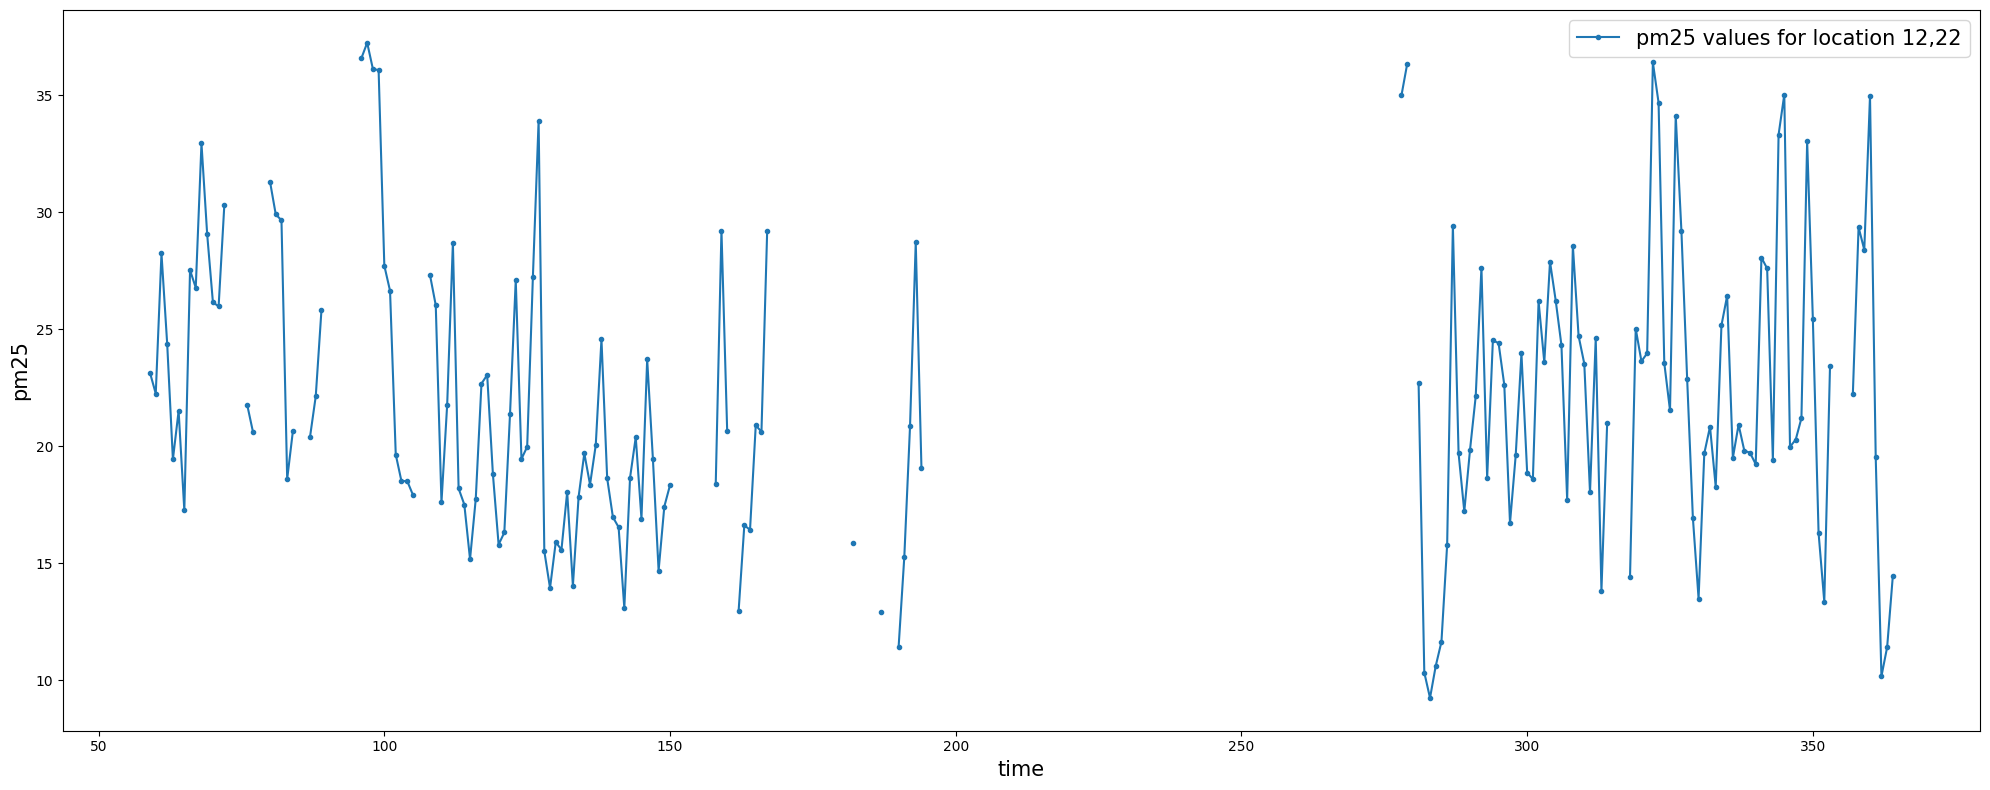

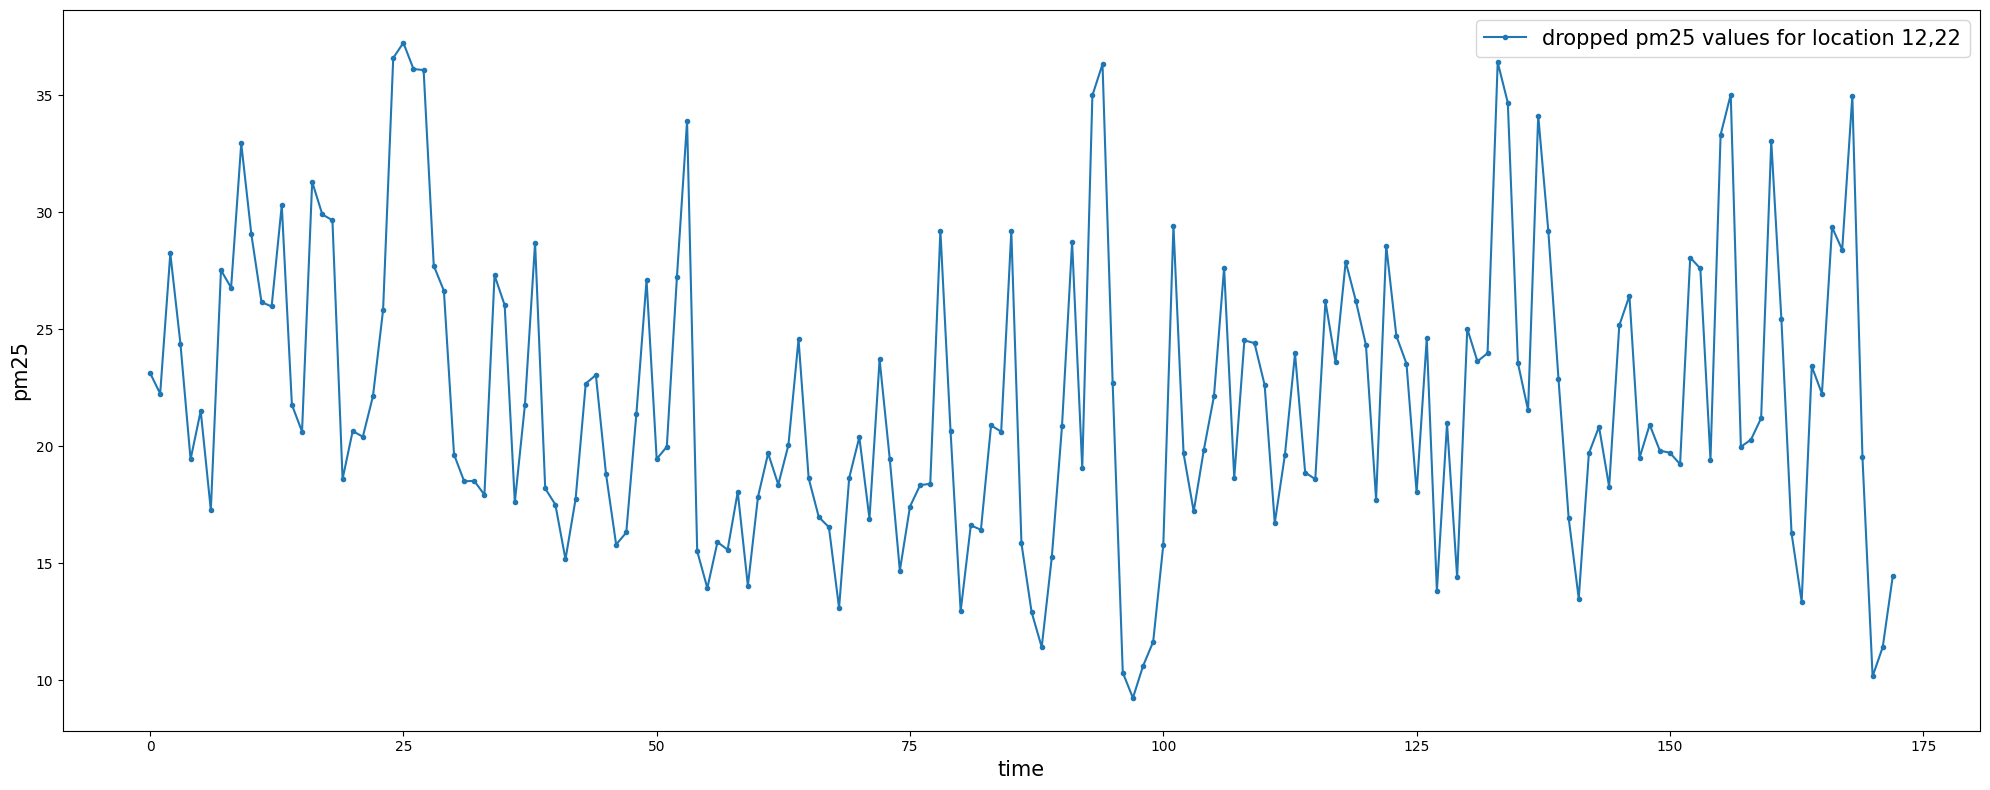

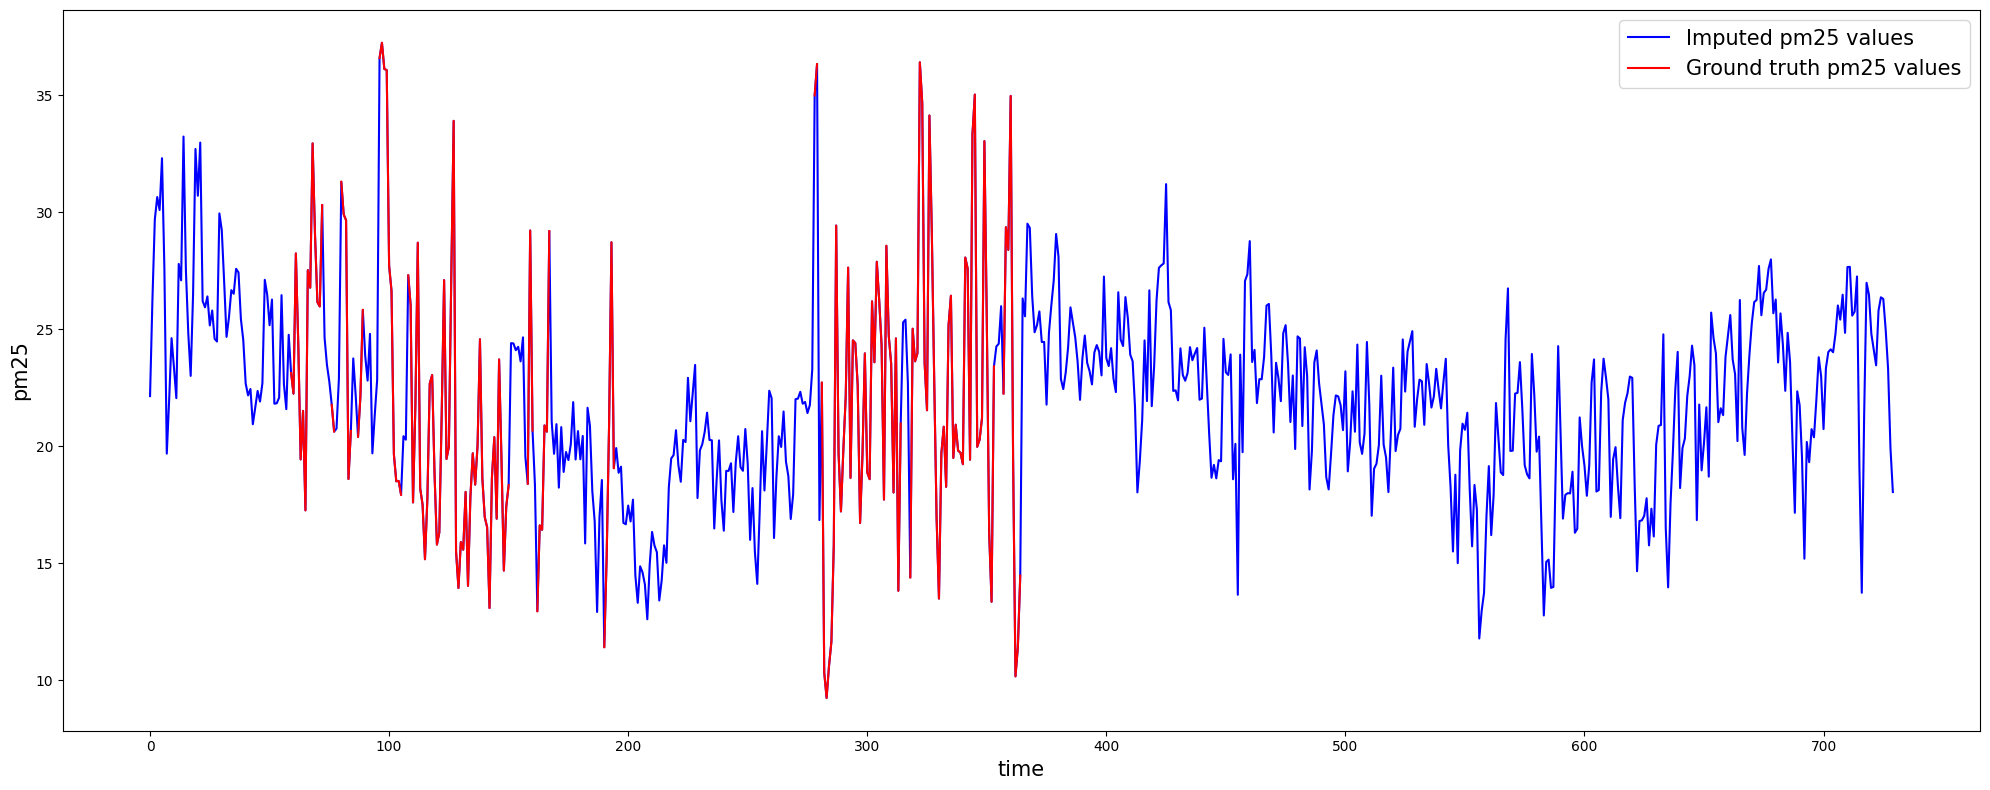

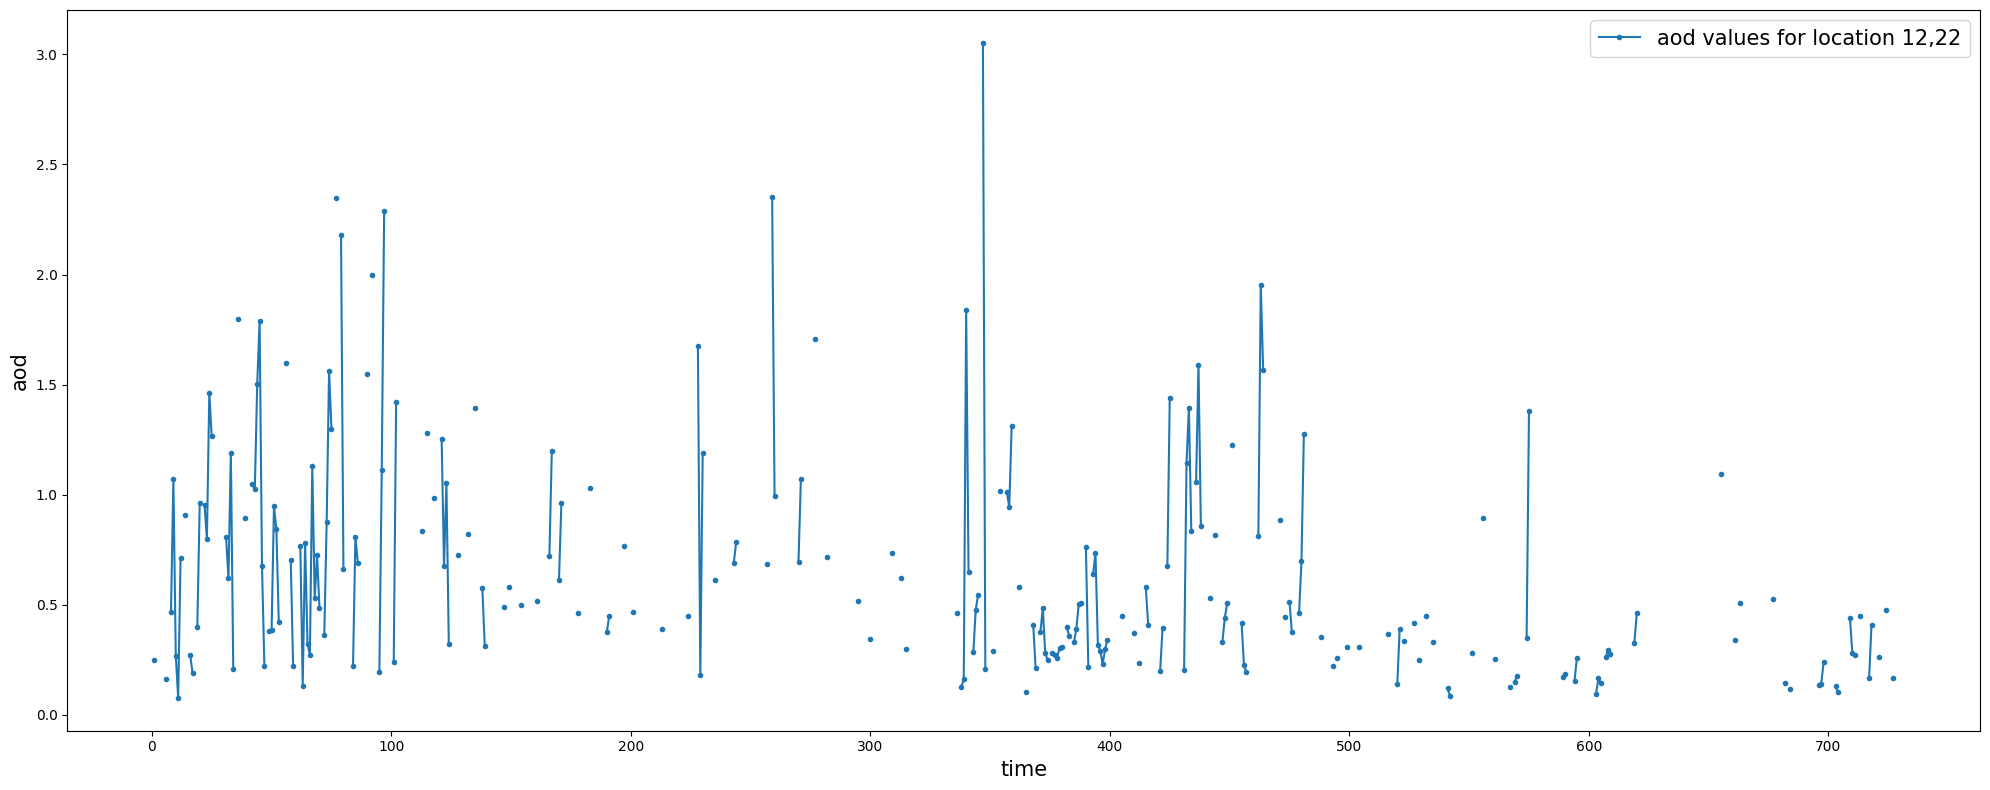

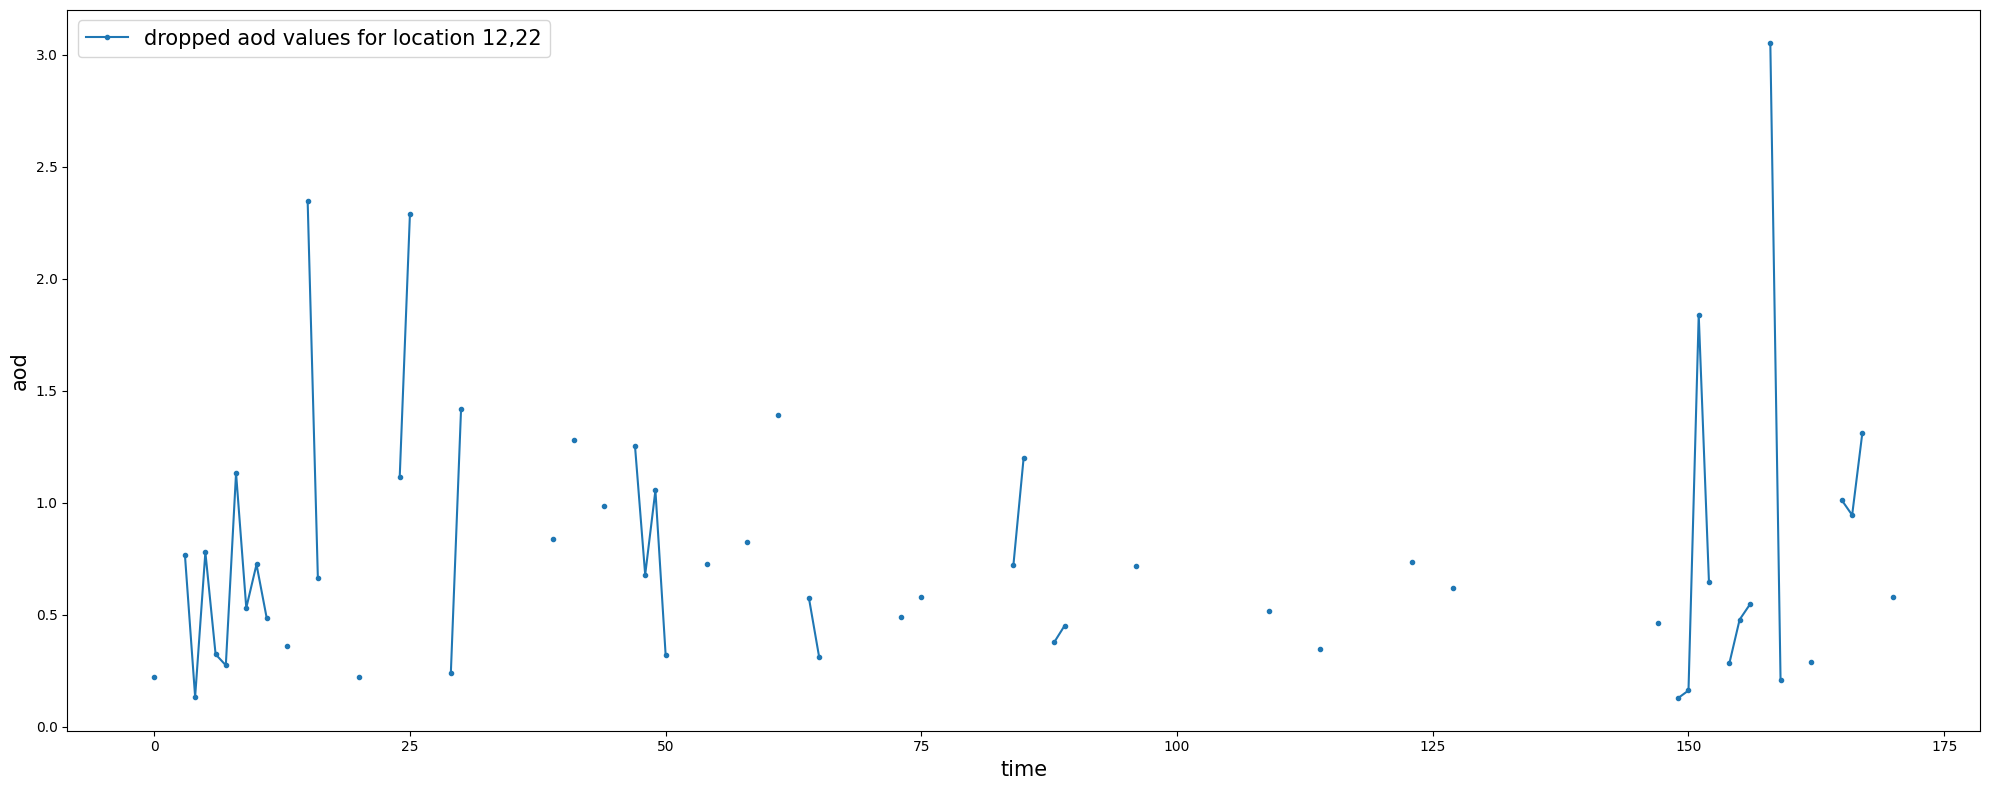

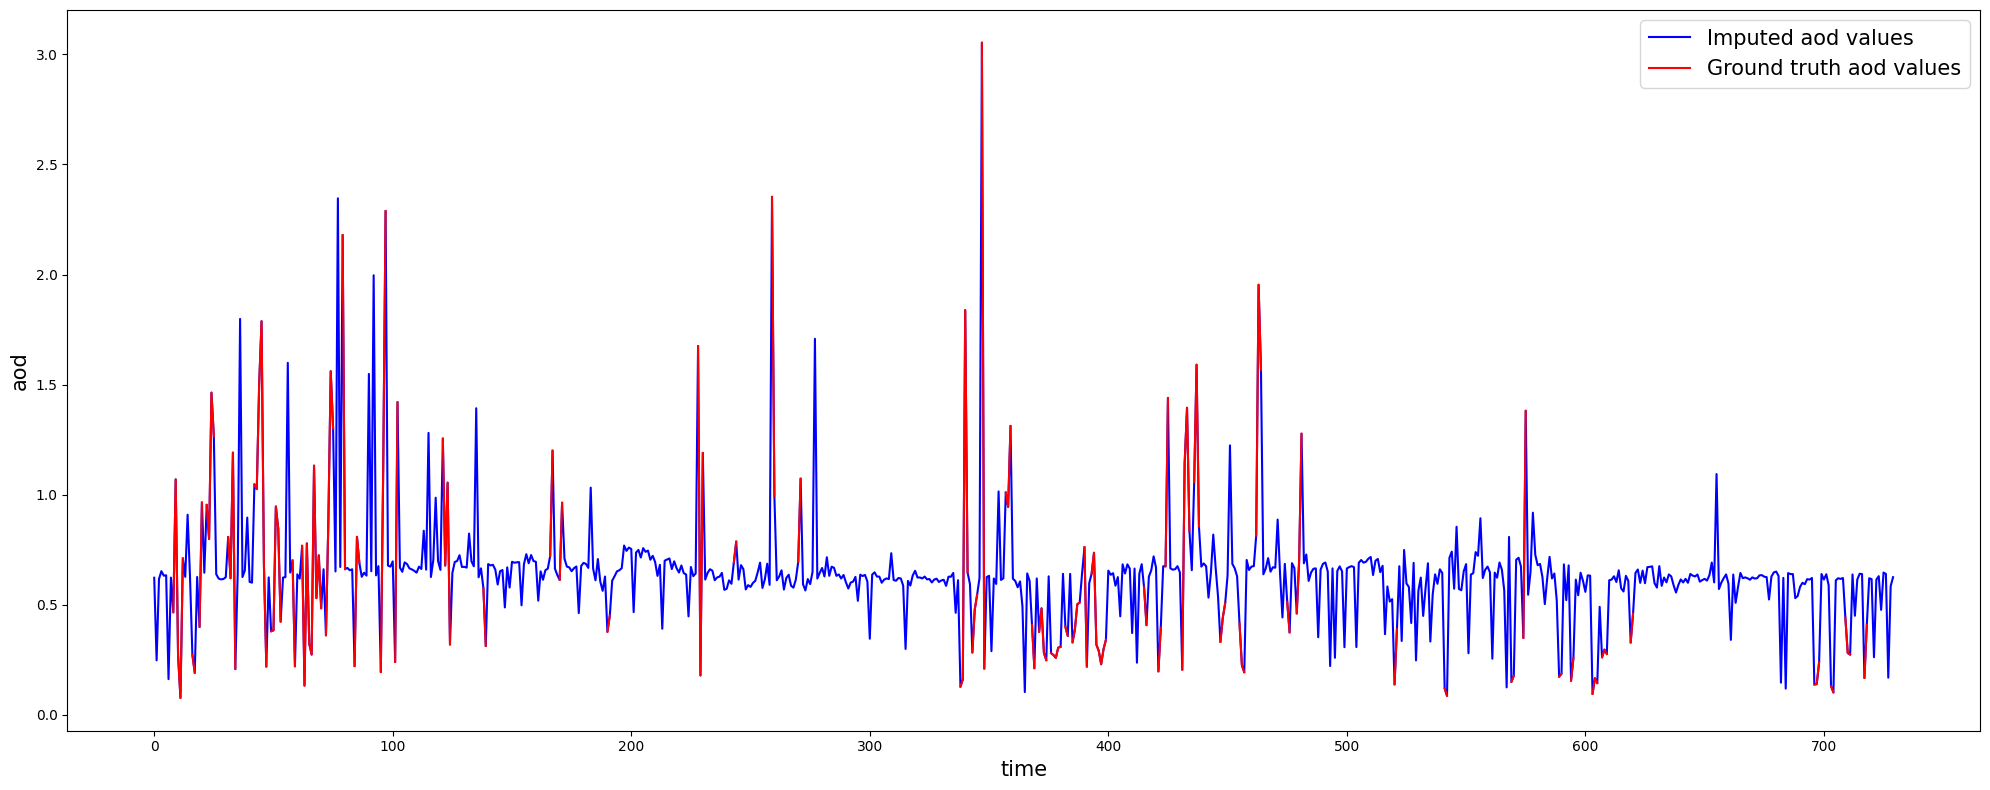


Handling label and dynamic features for 15, 14...



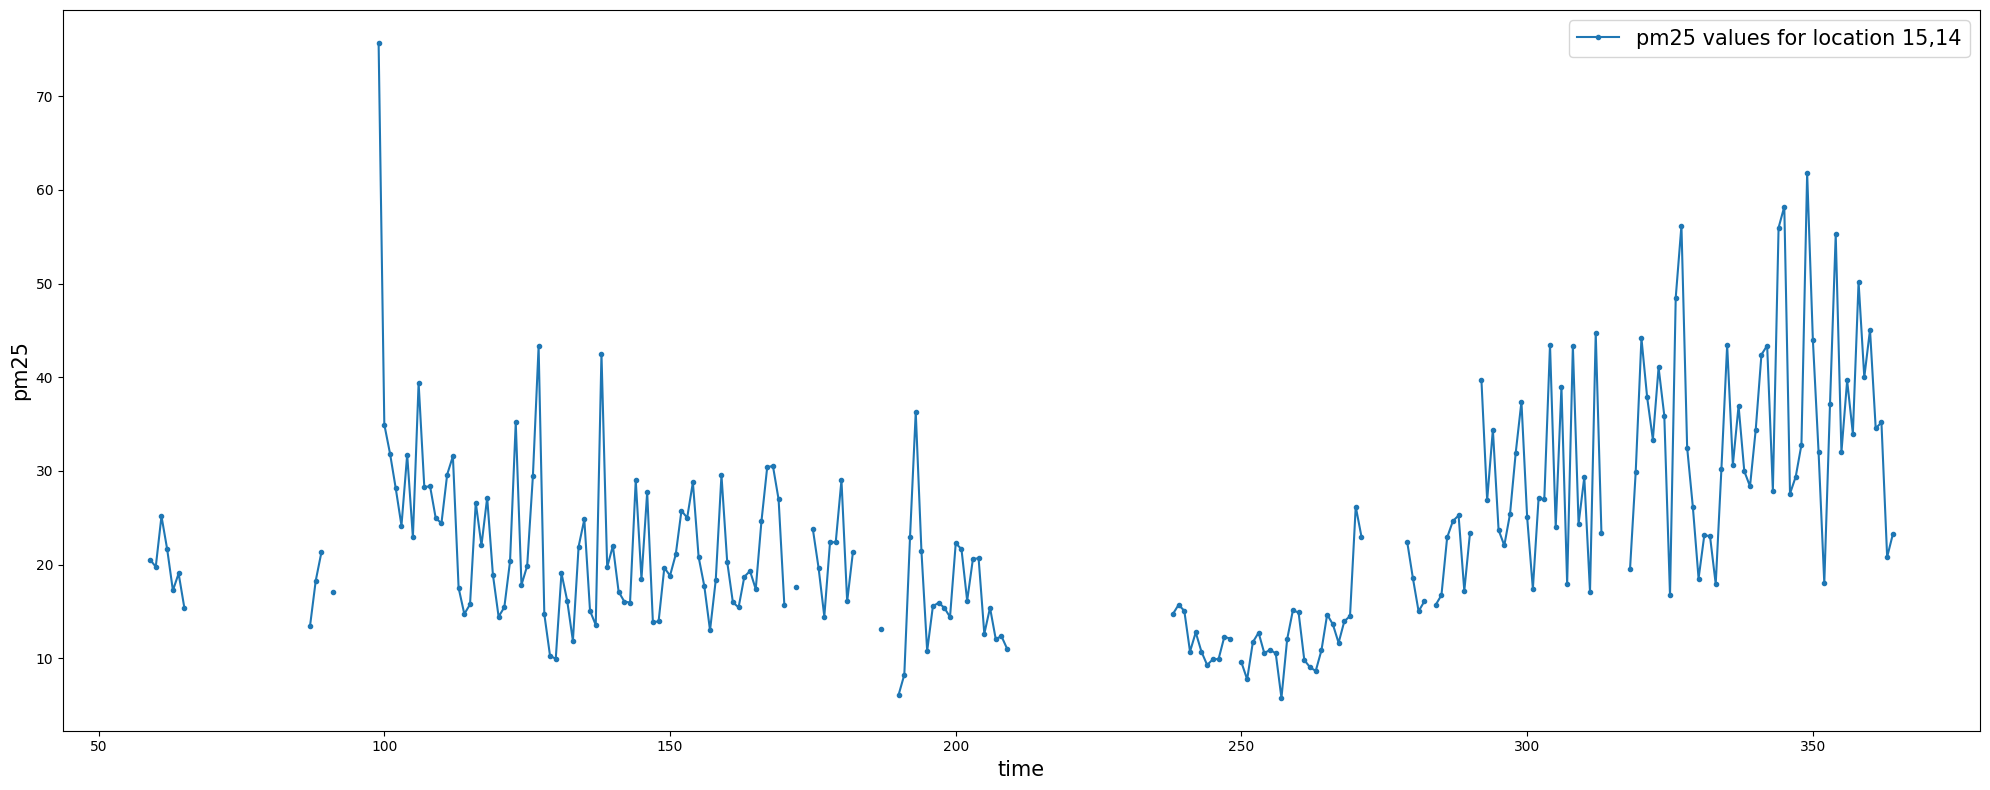

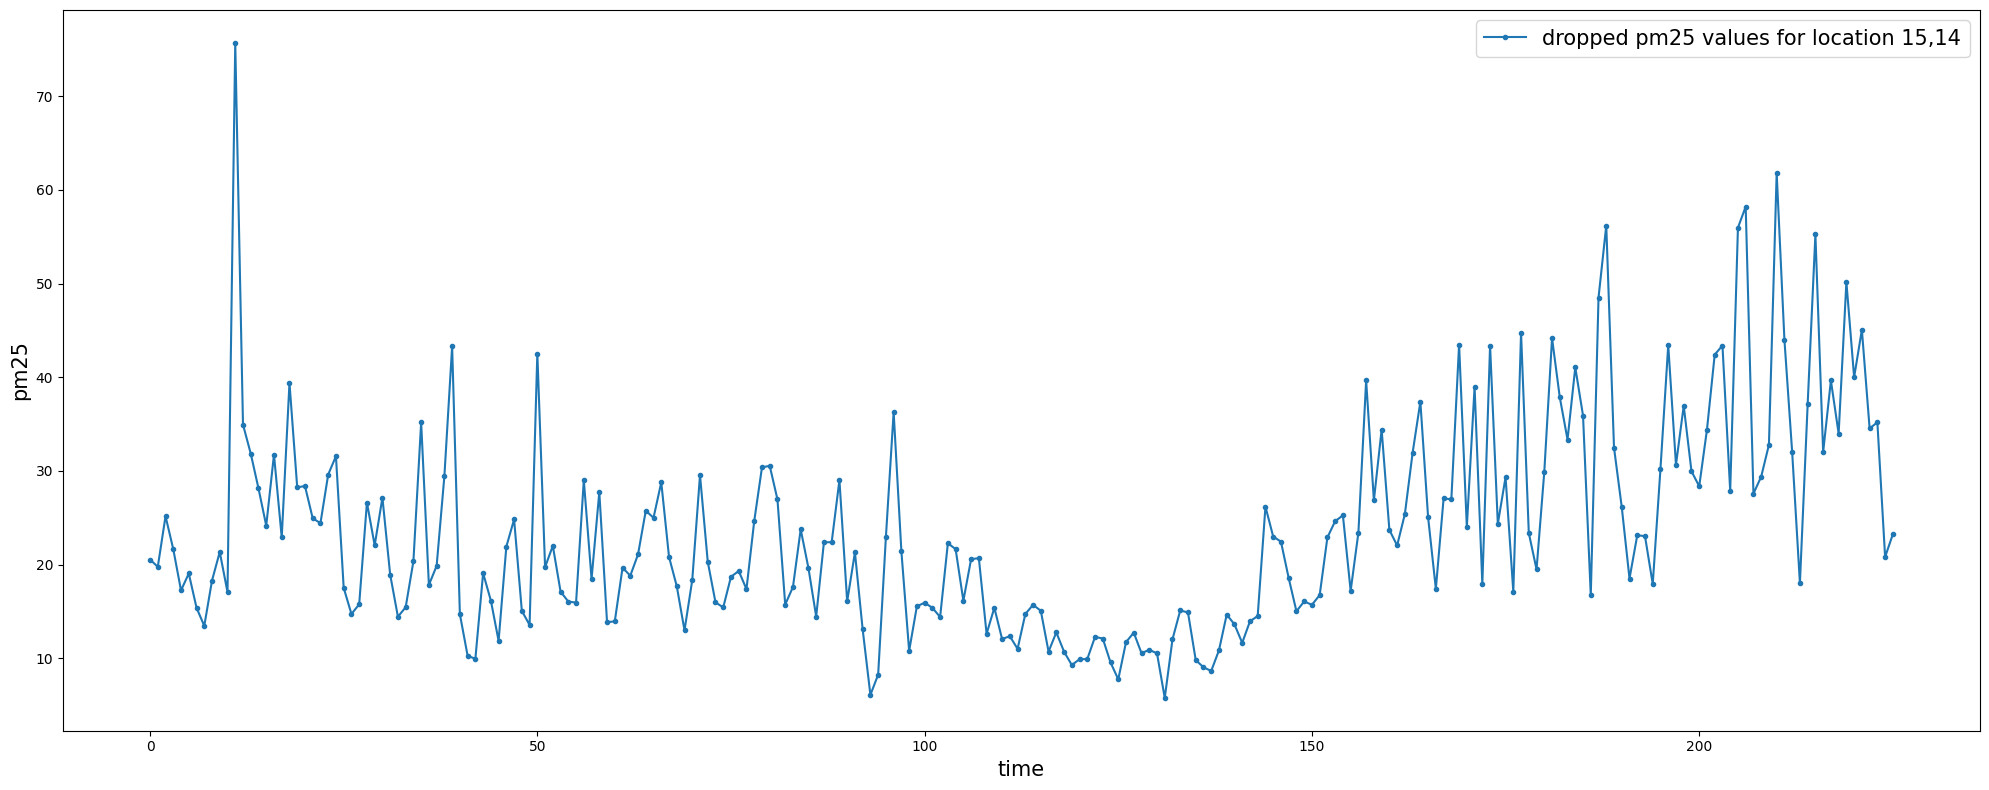

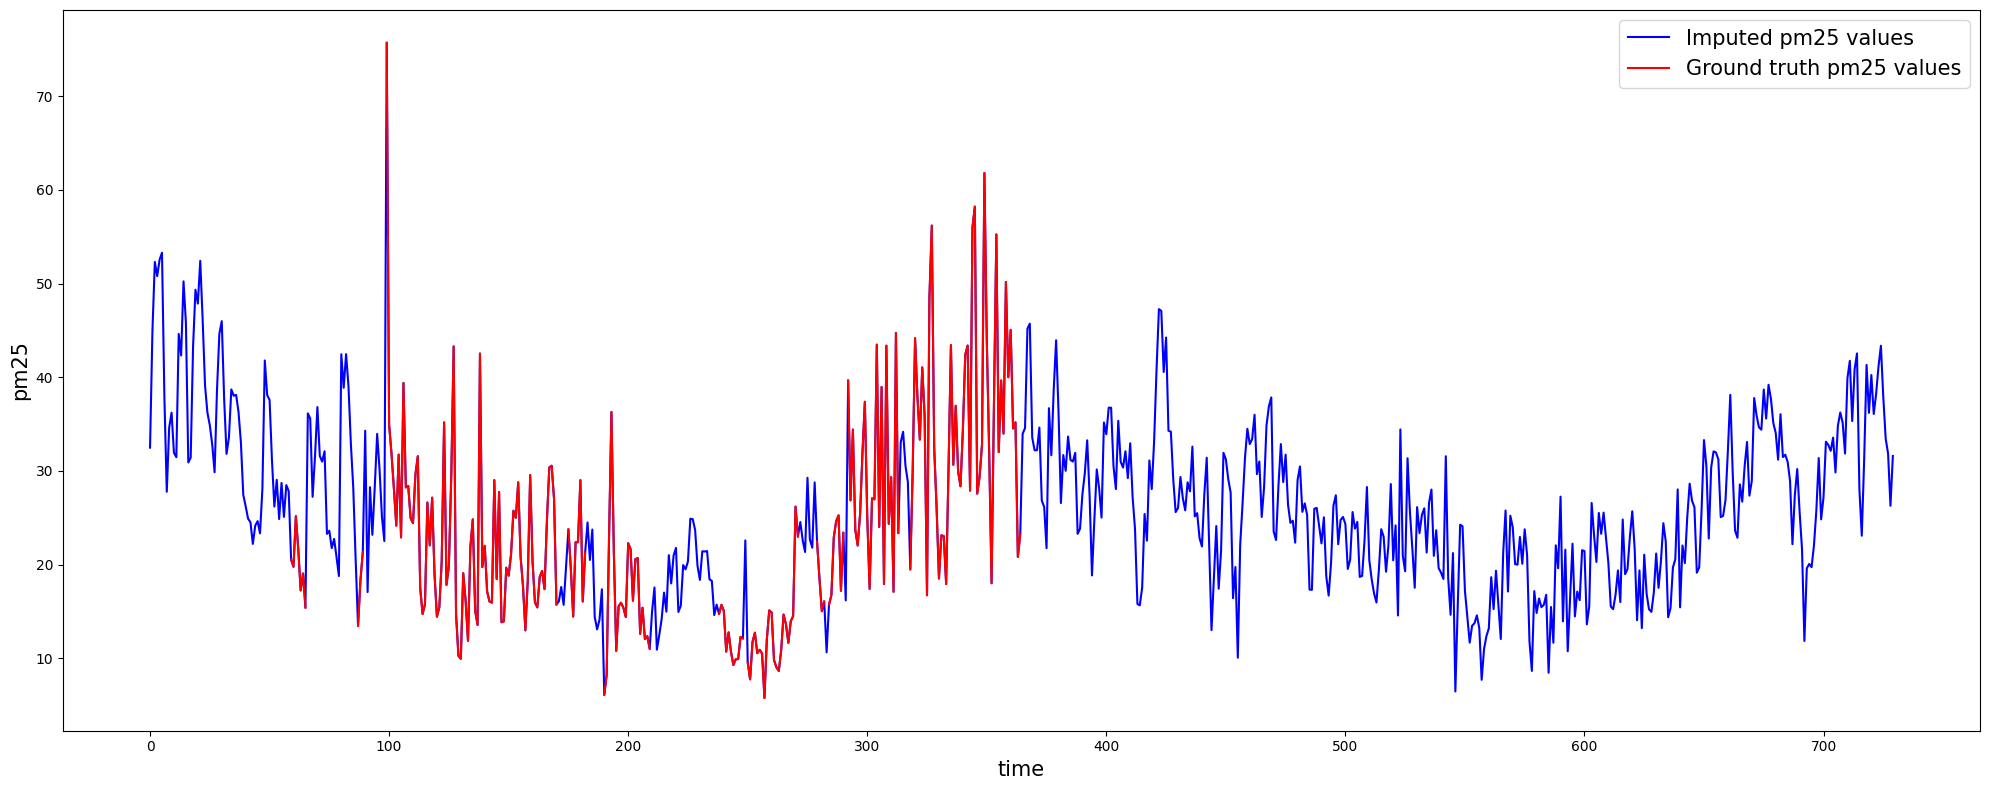

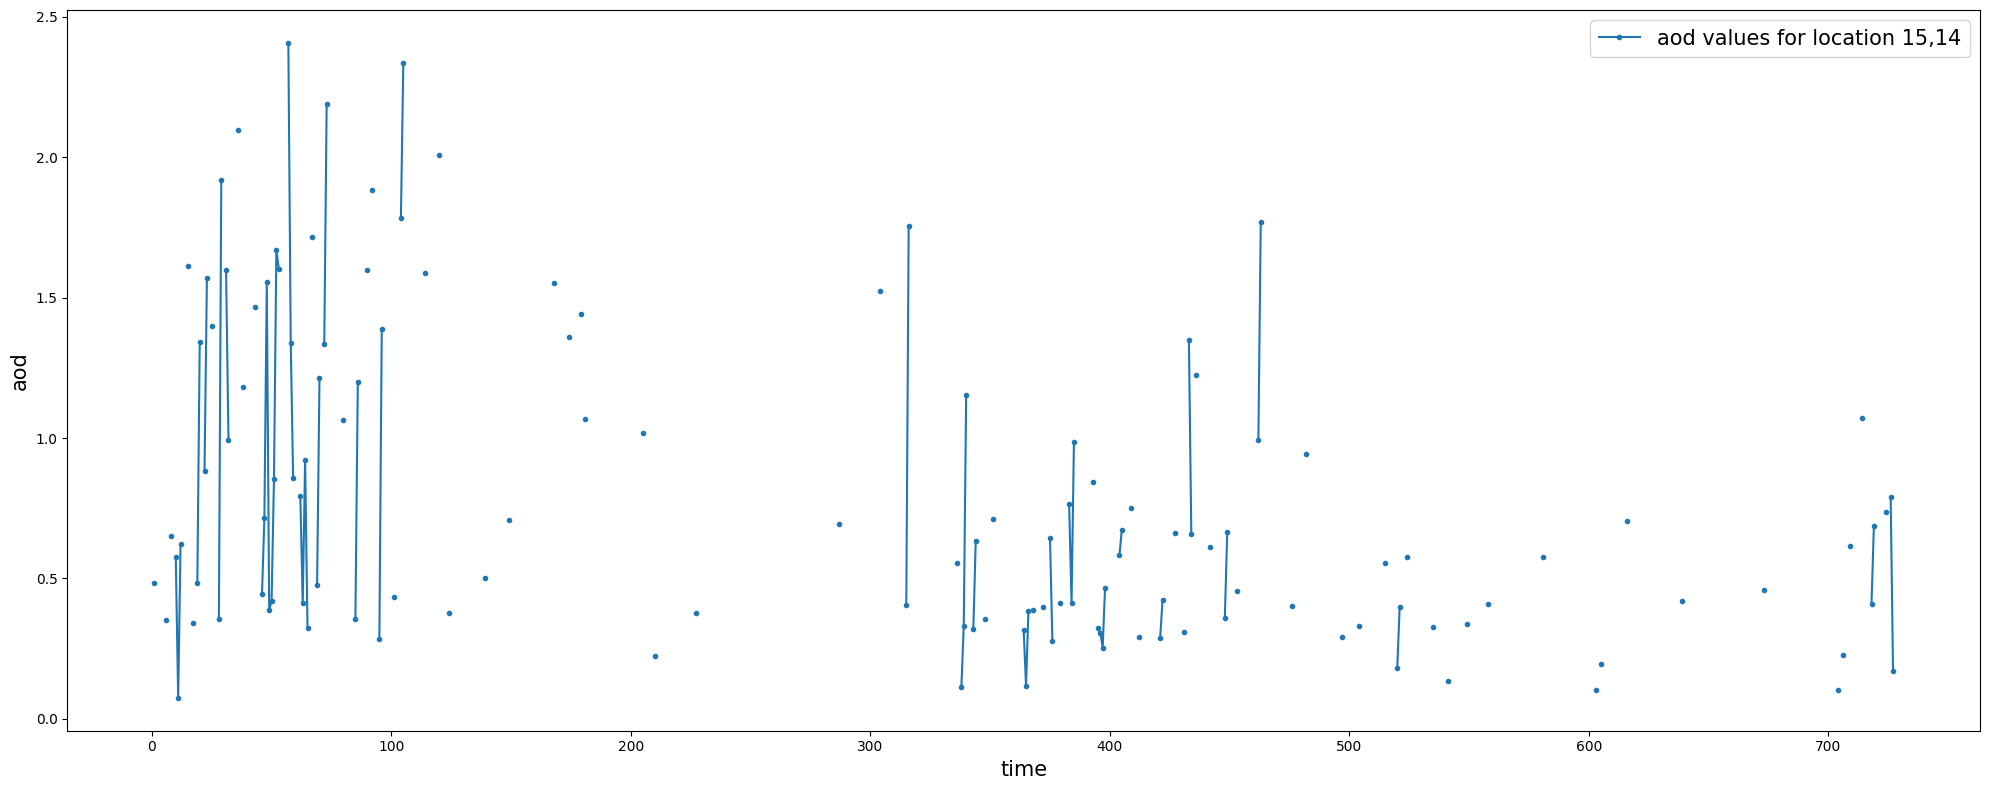

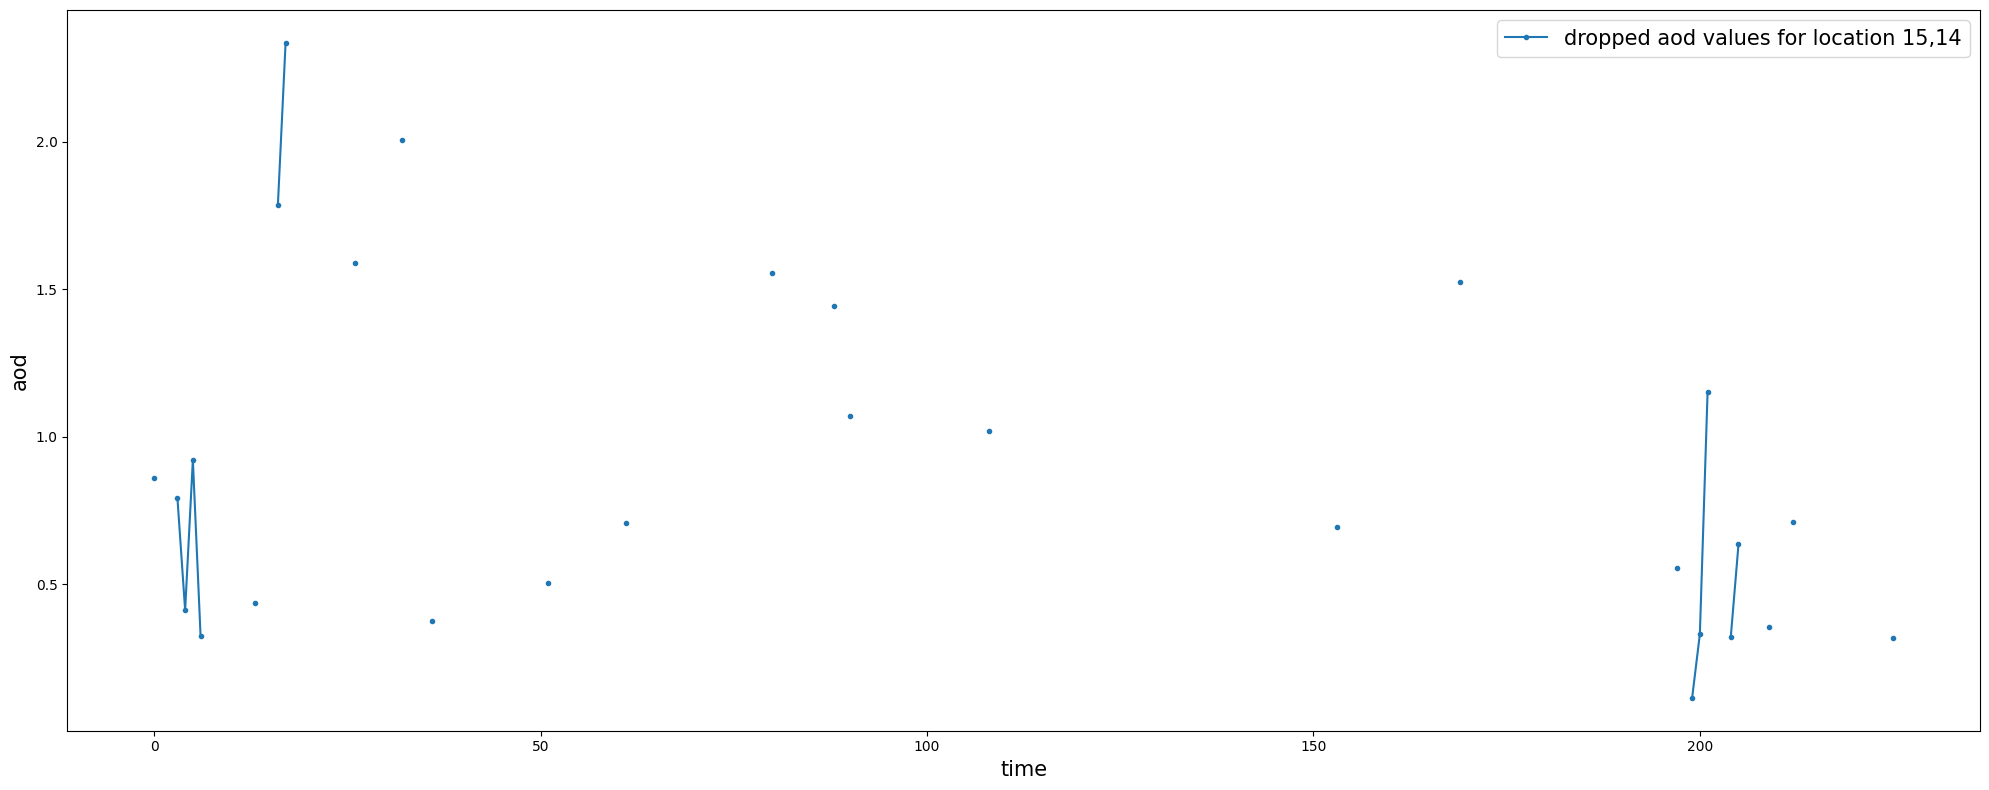

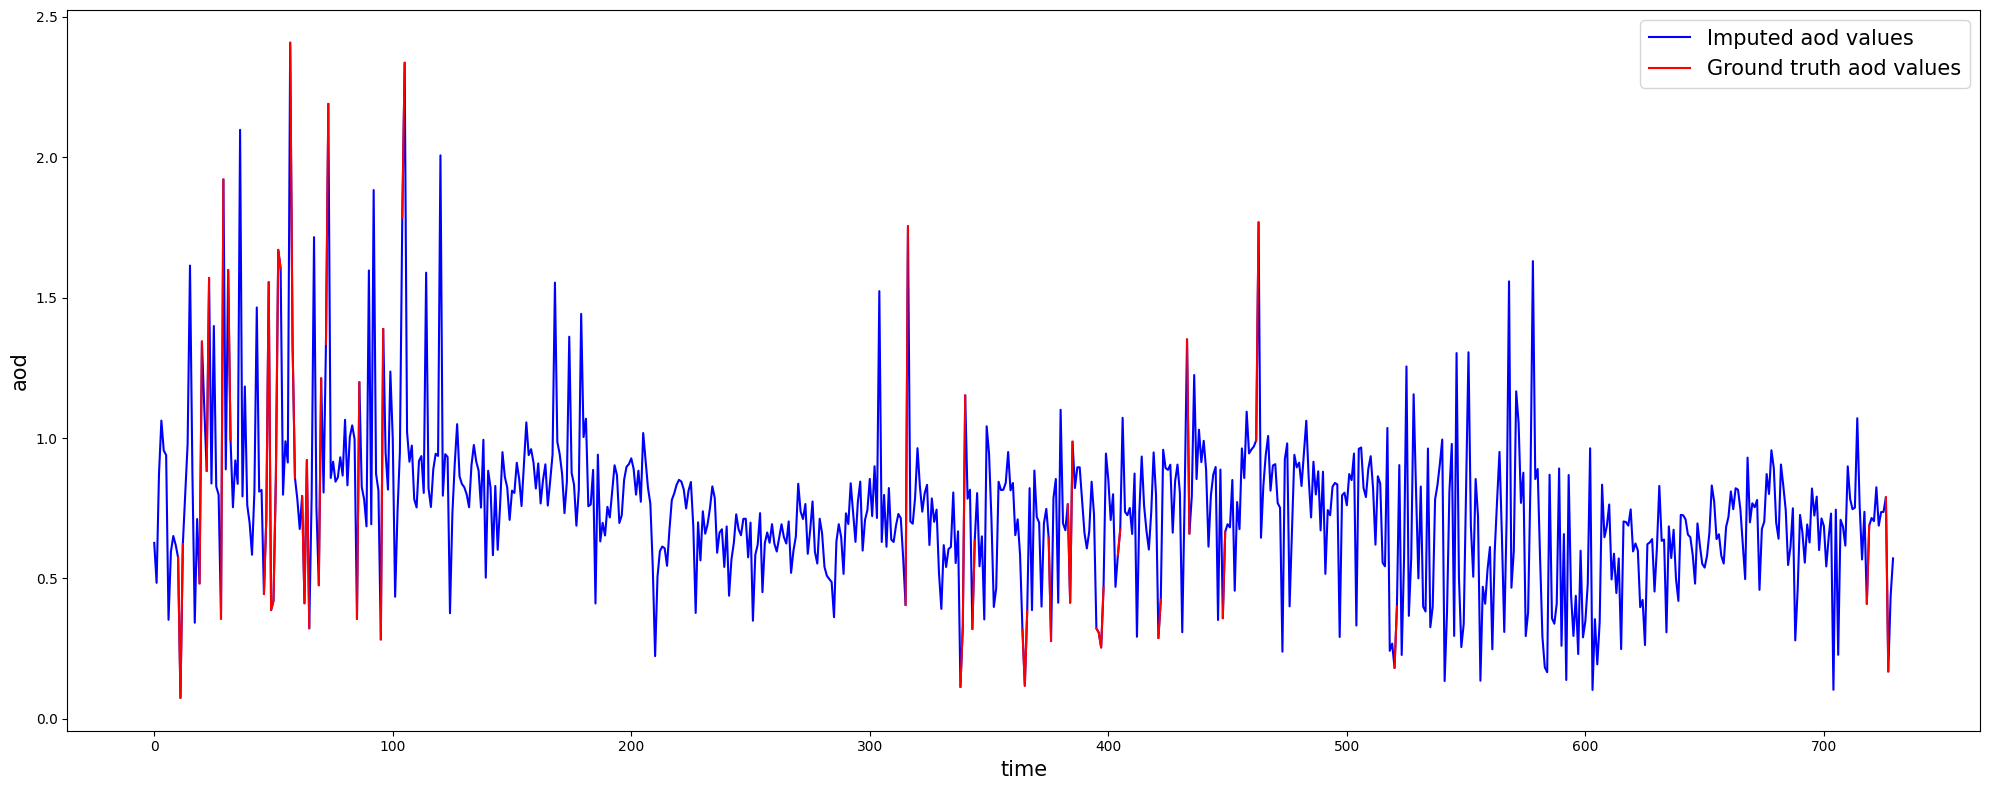


Handling label and dynamic features for 15, 18...



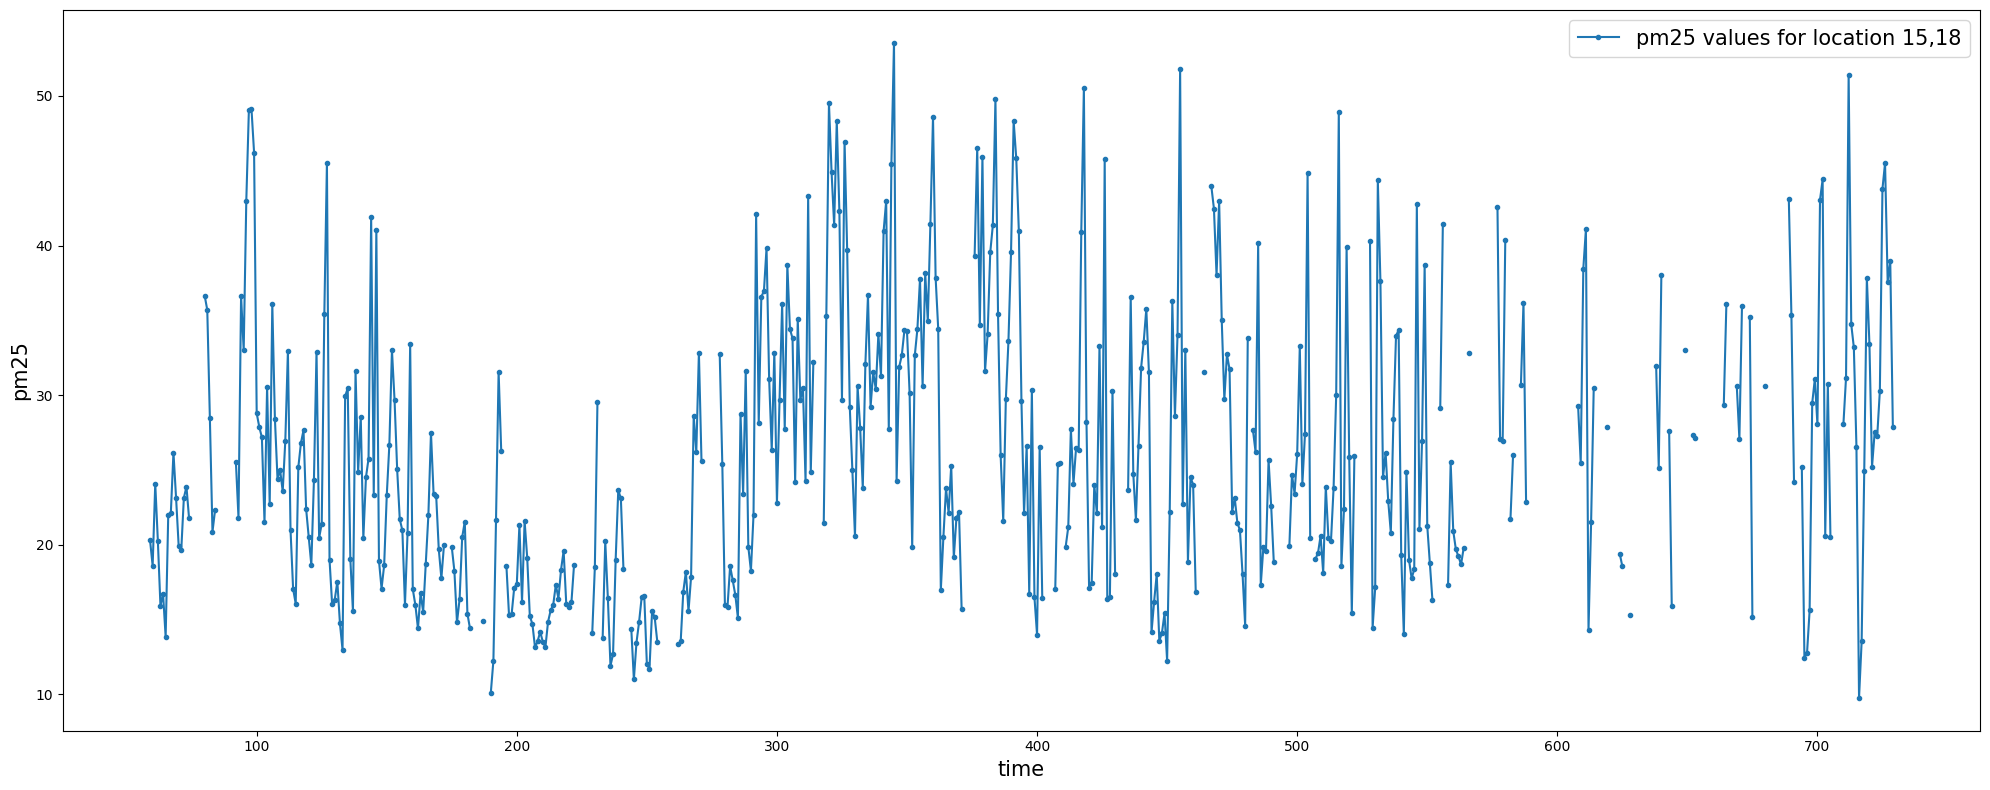

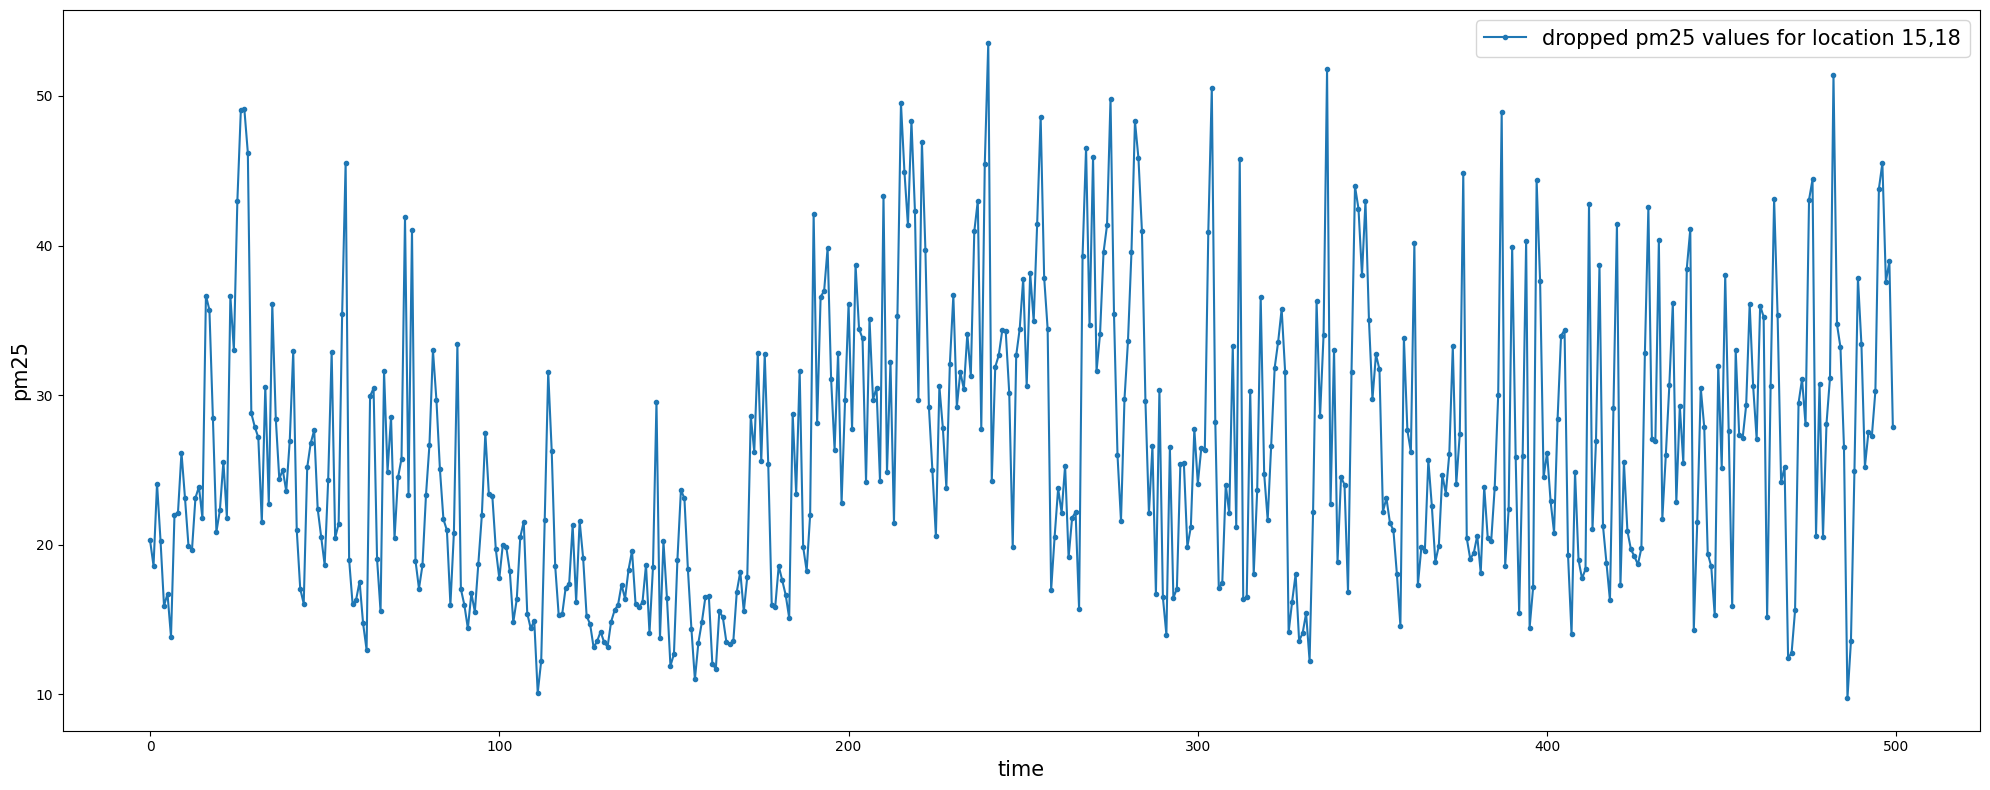

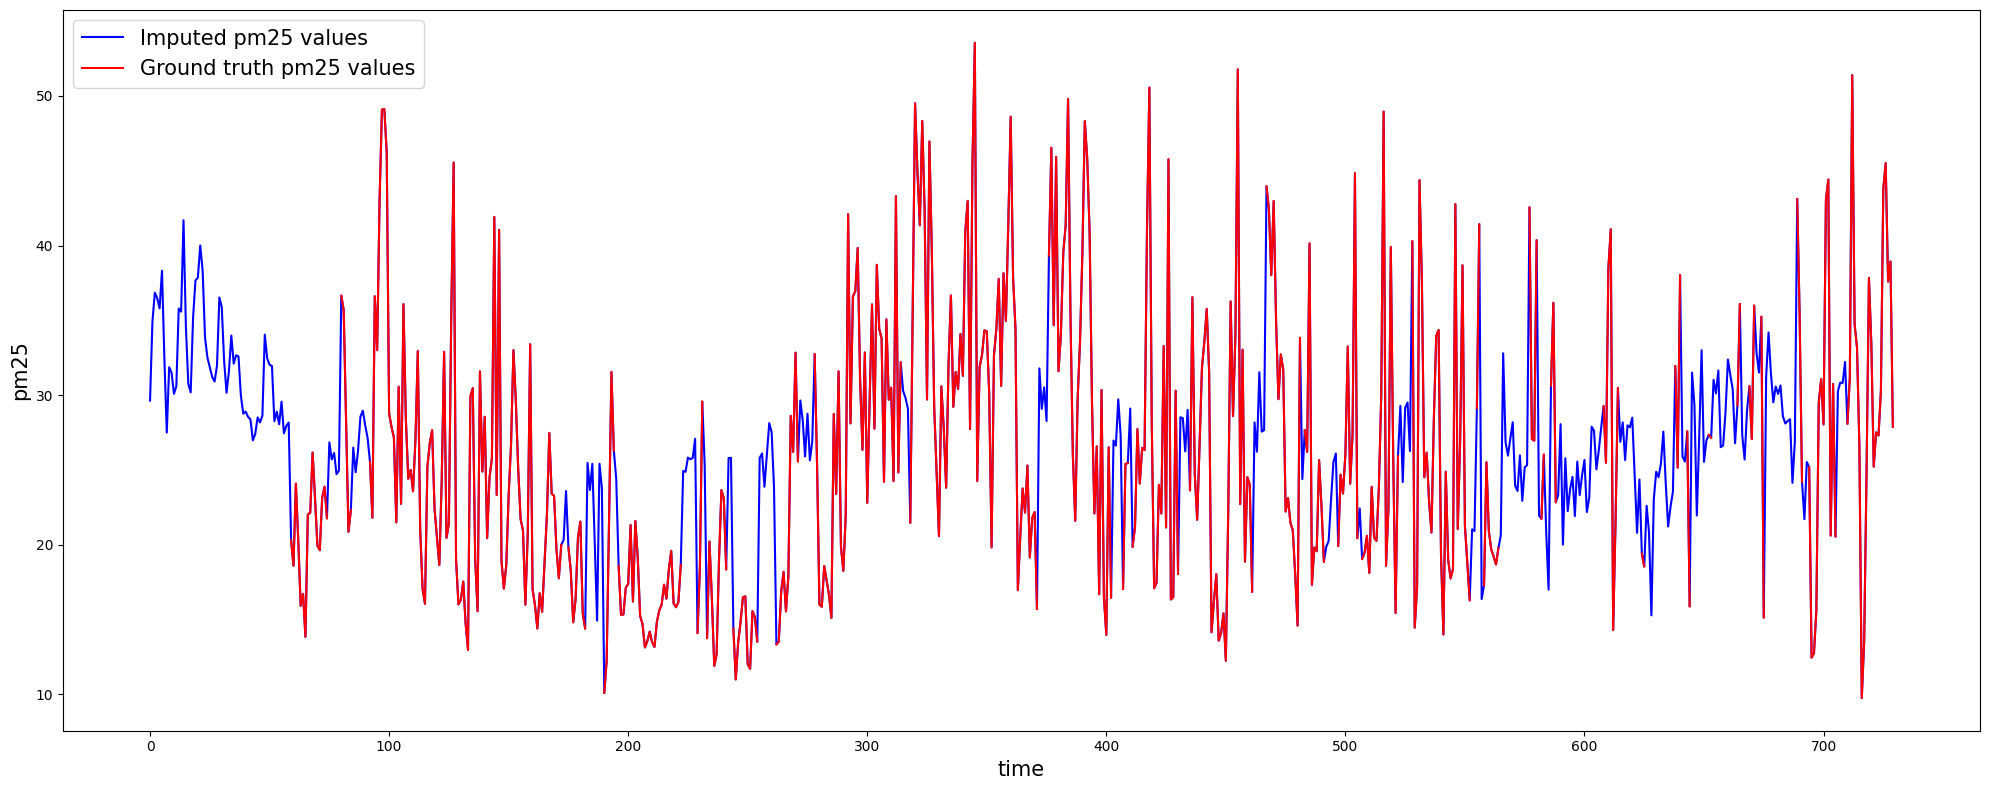

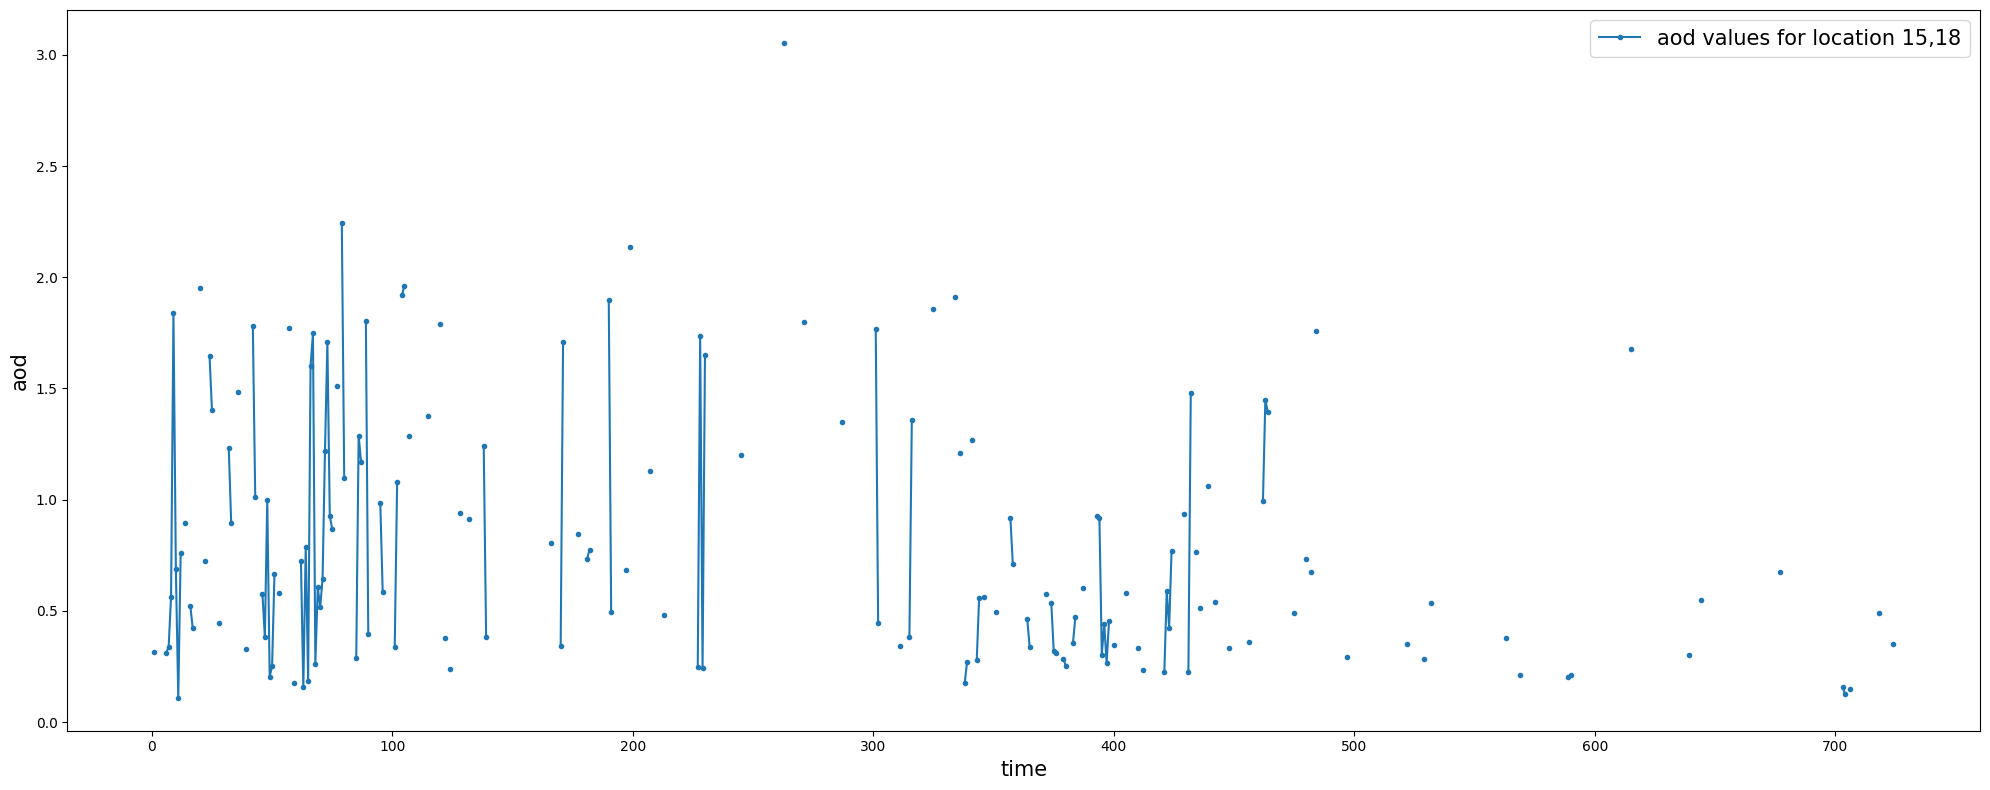

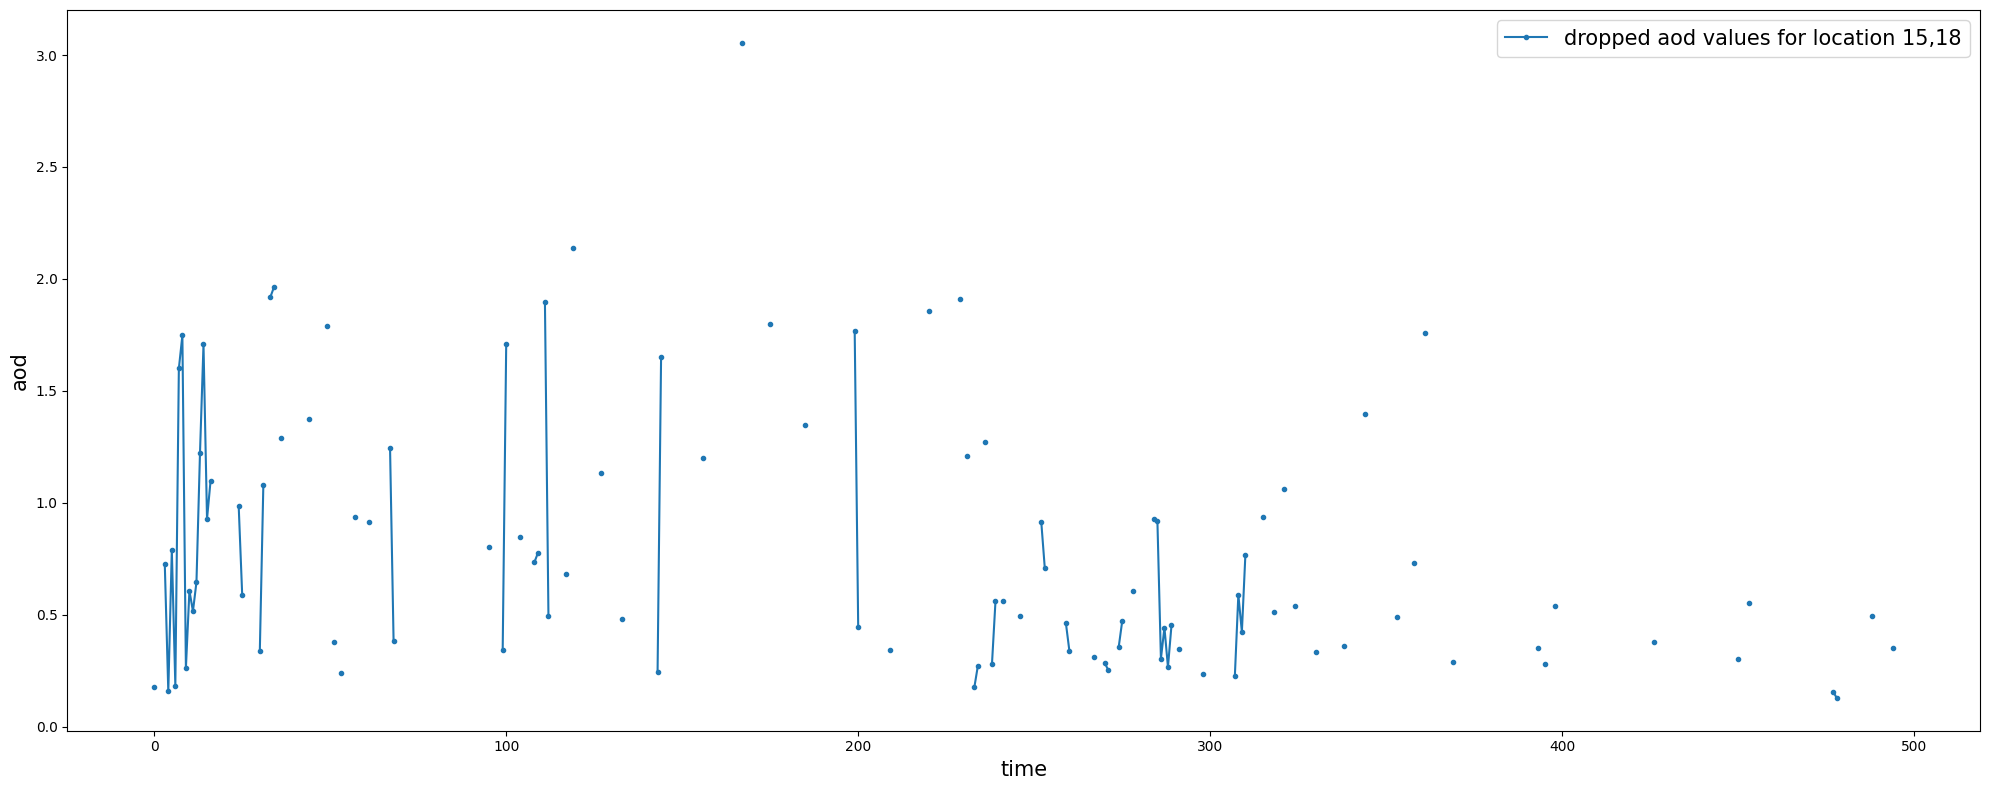

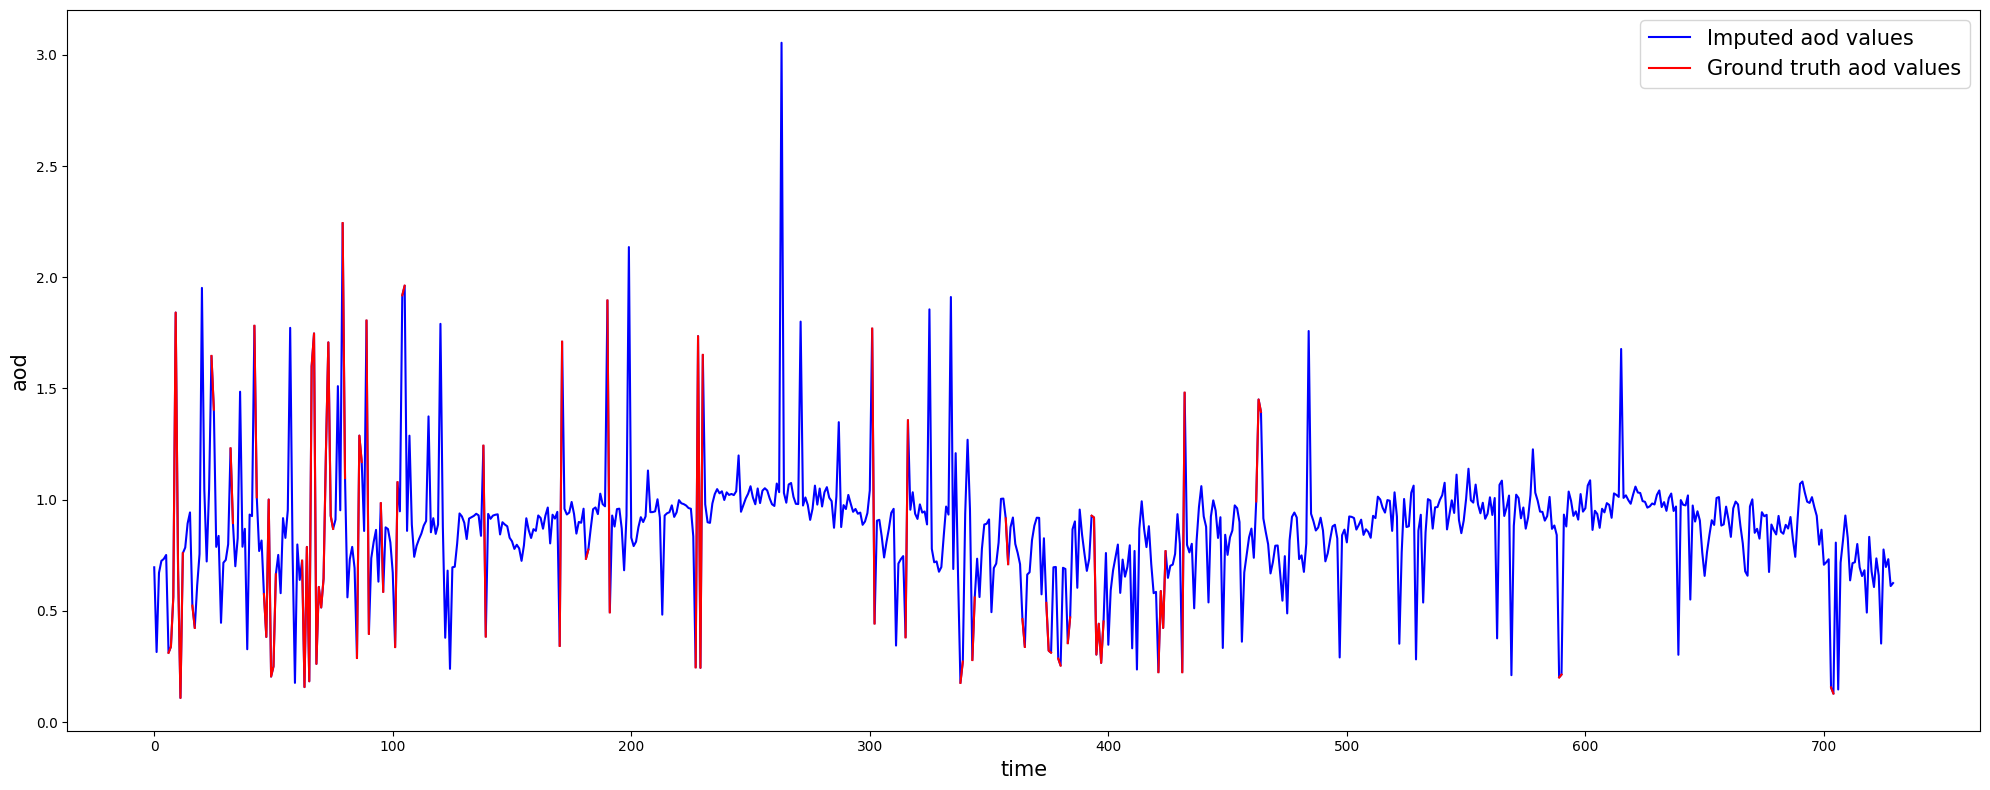


Handling label and dynamic features for 16, 16...



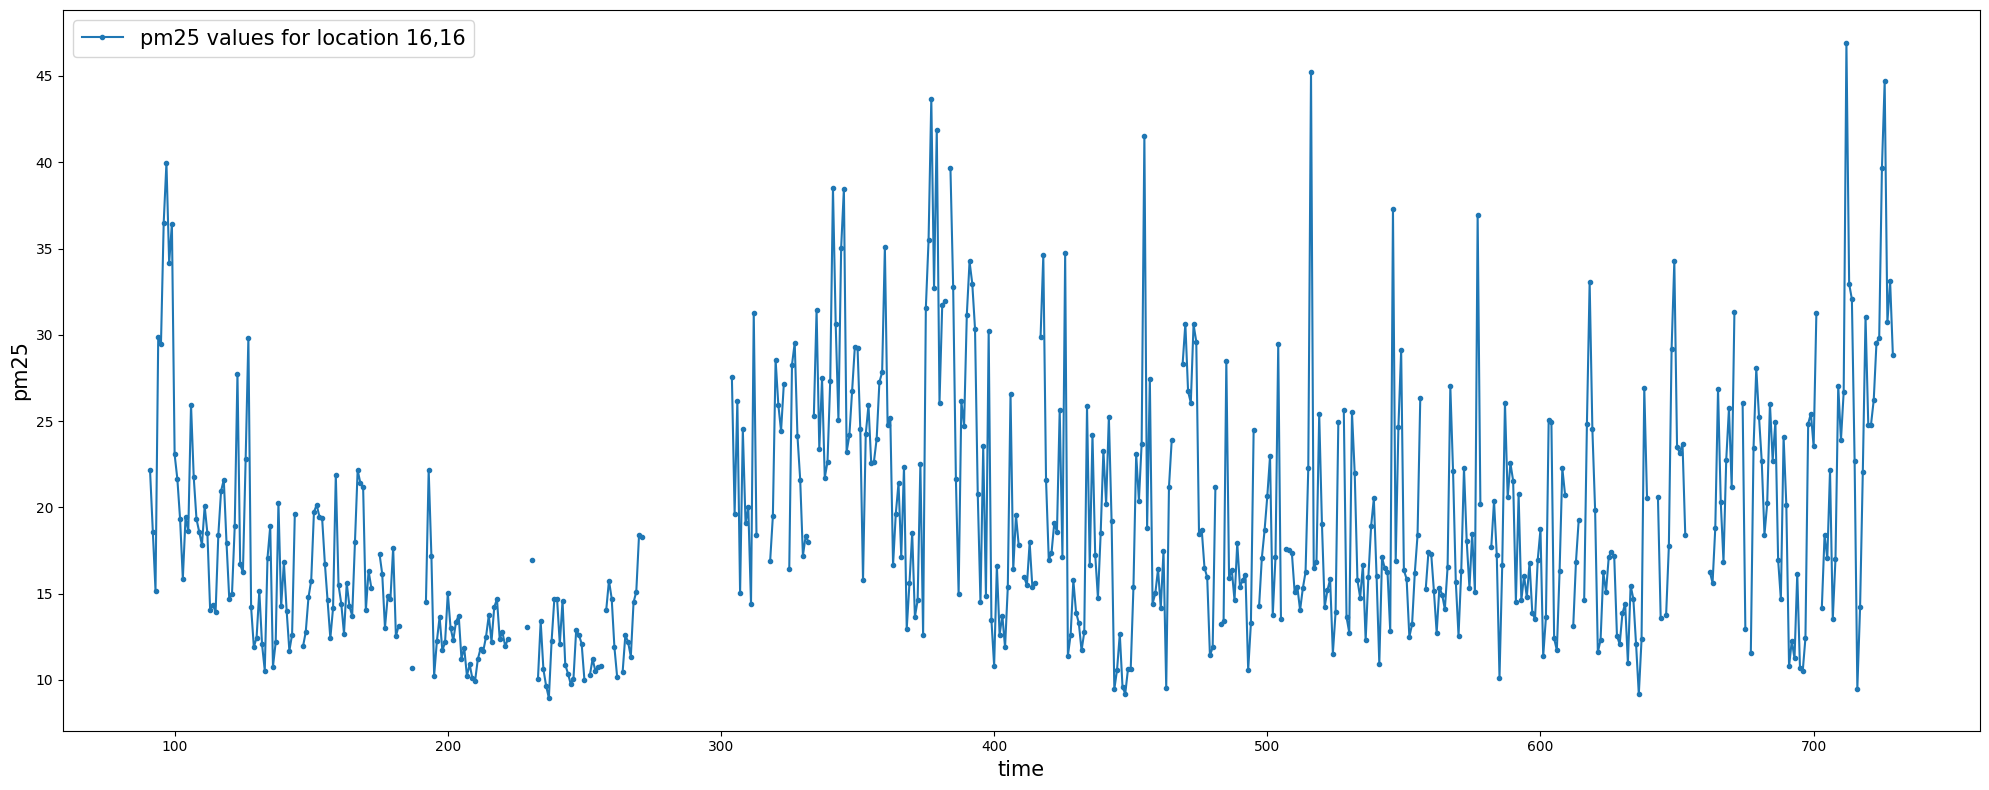

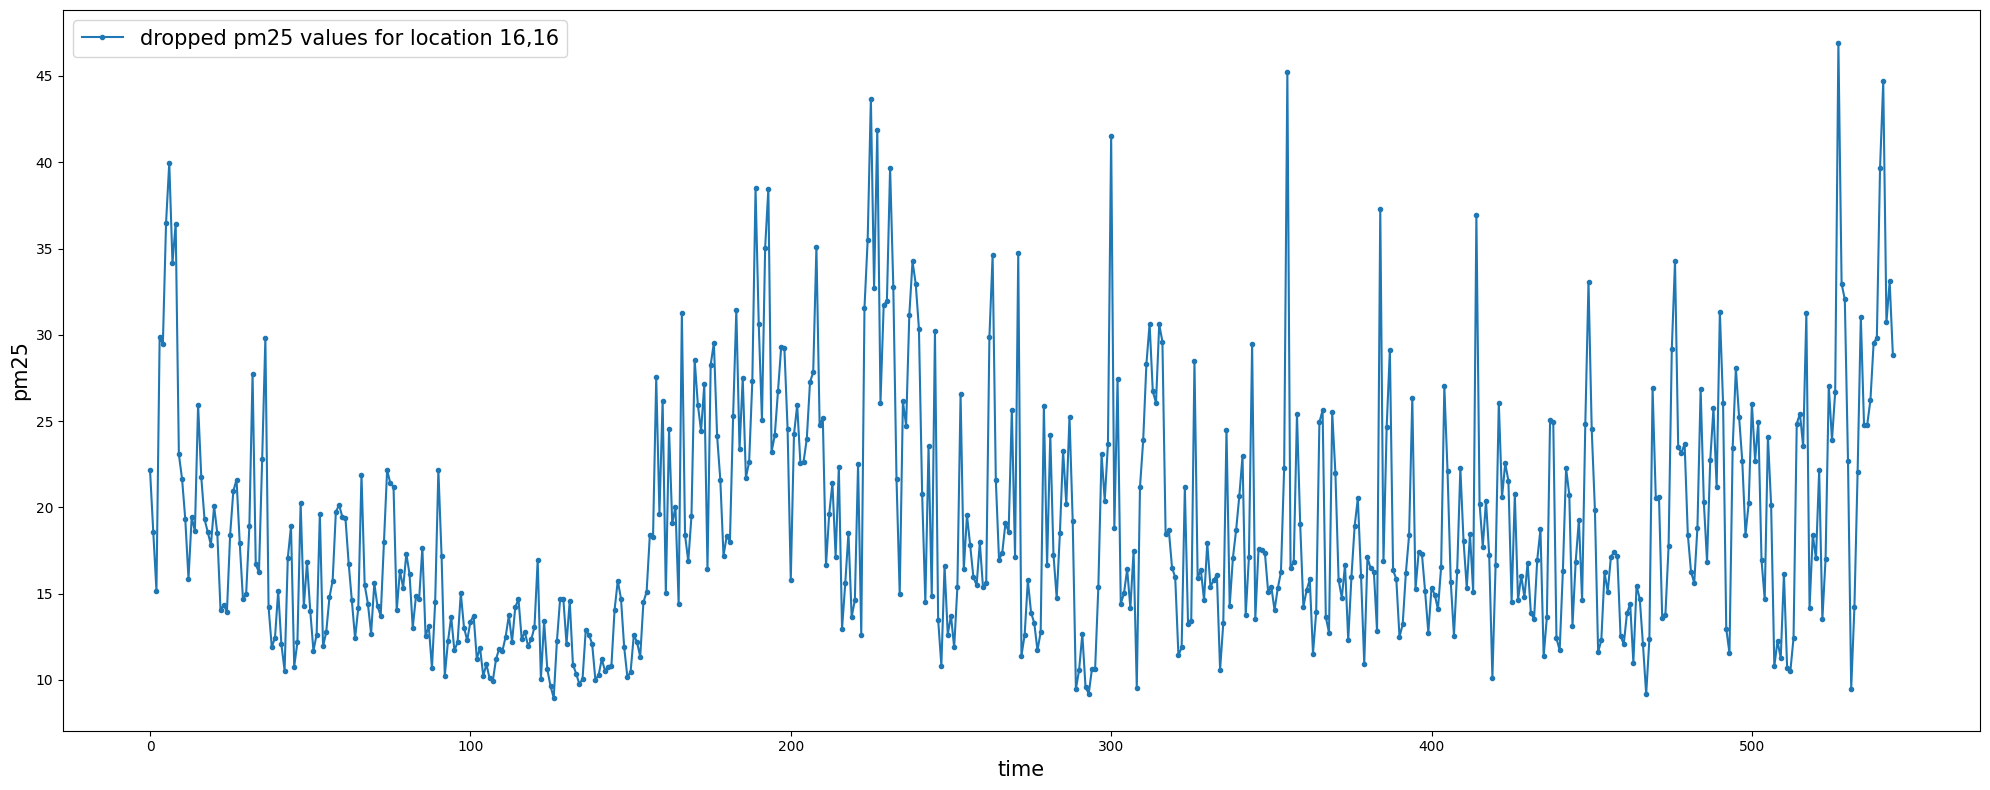

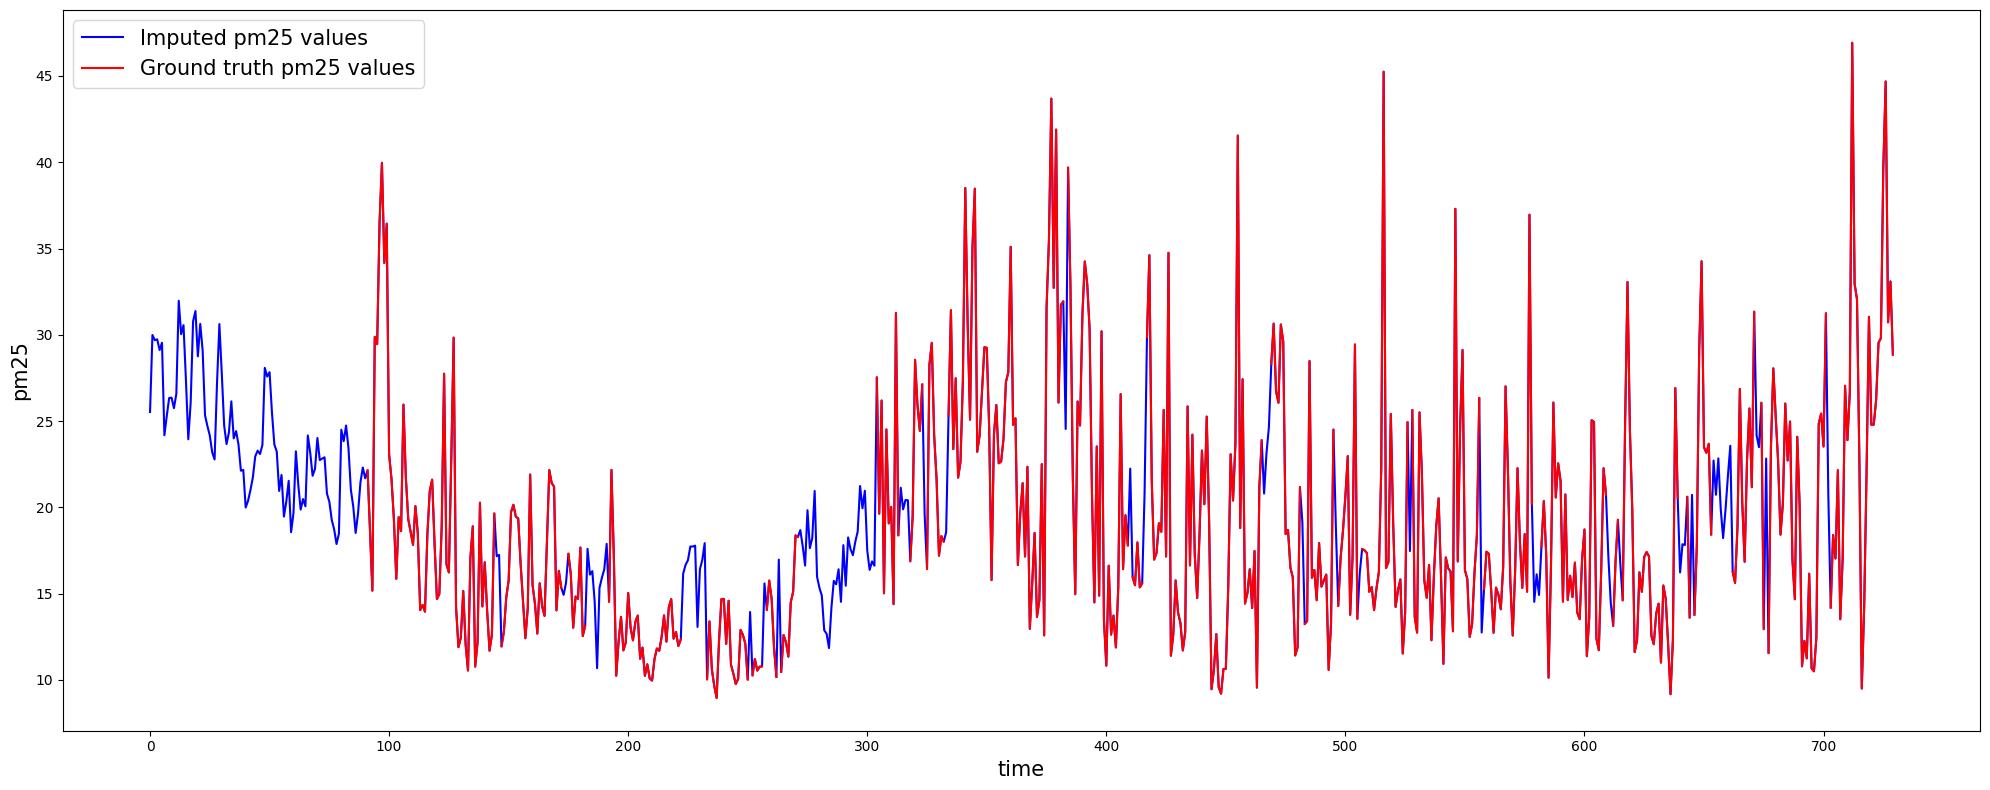

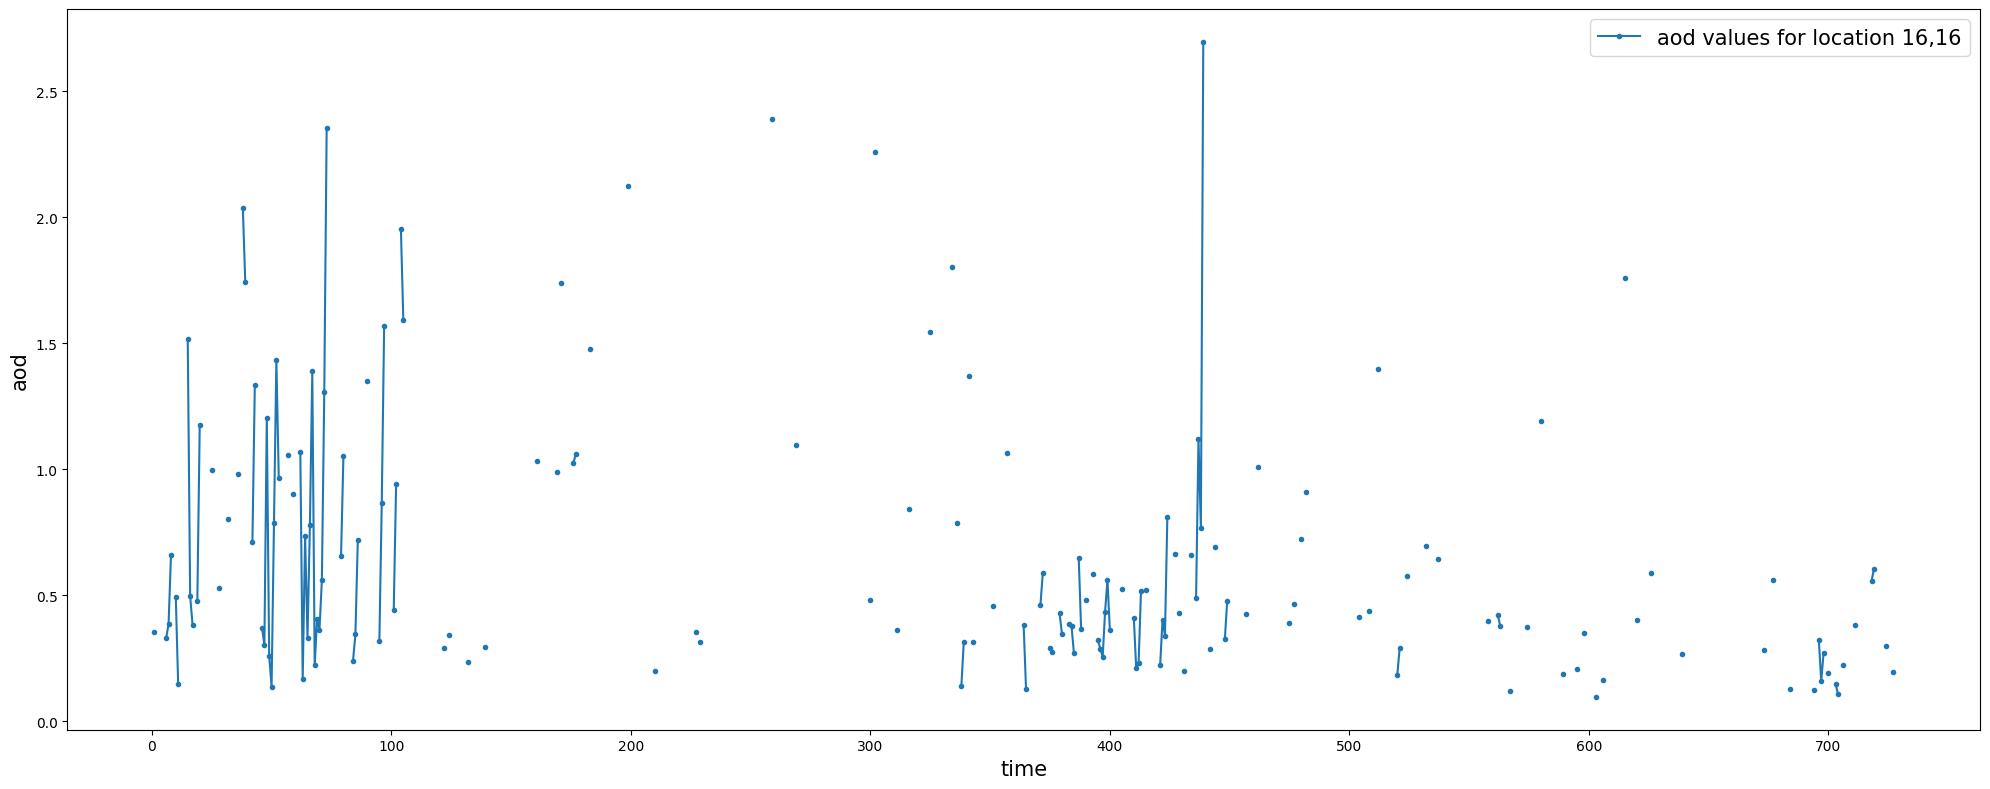

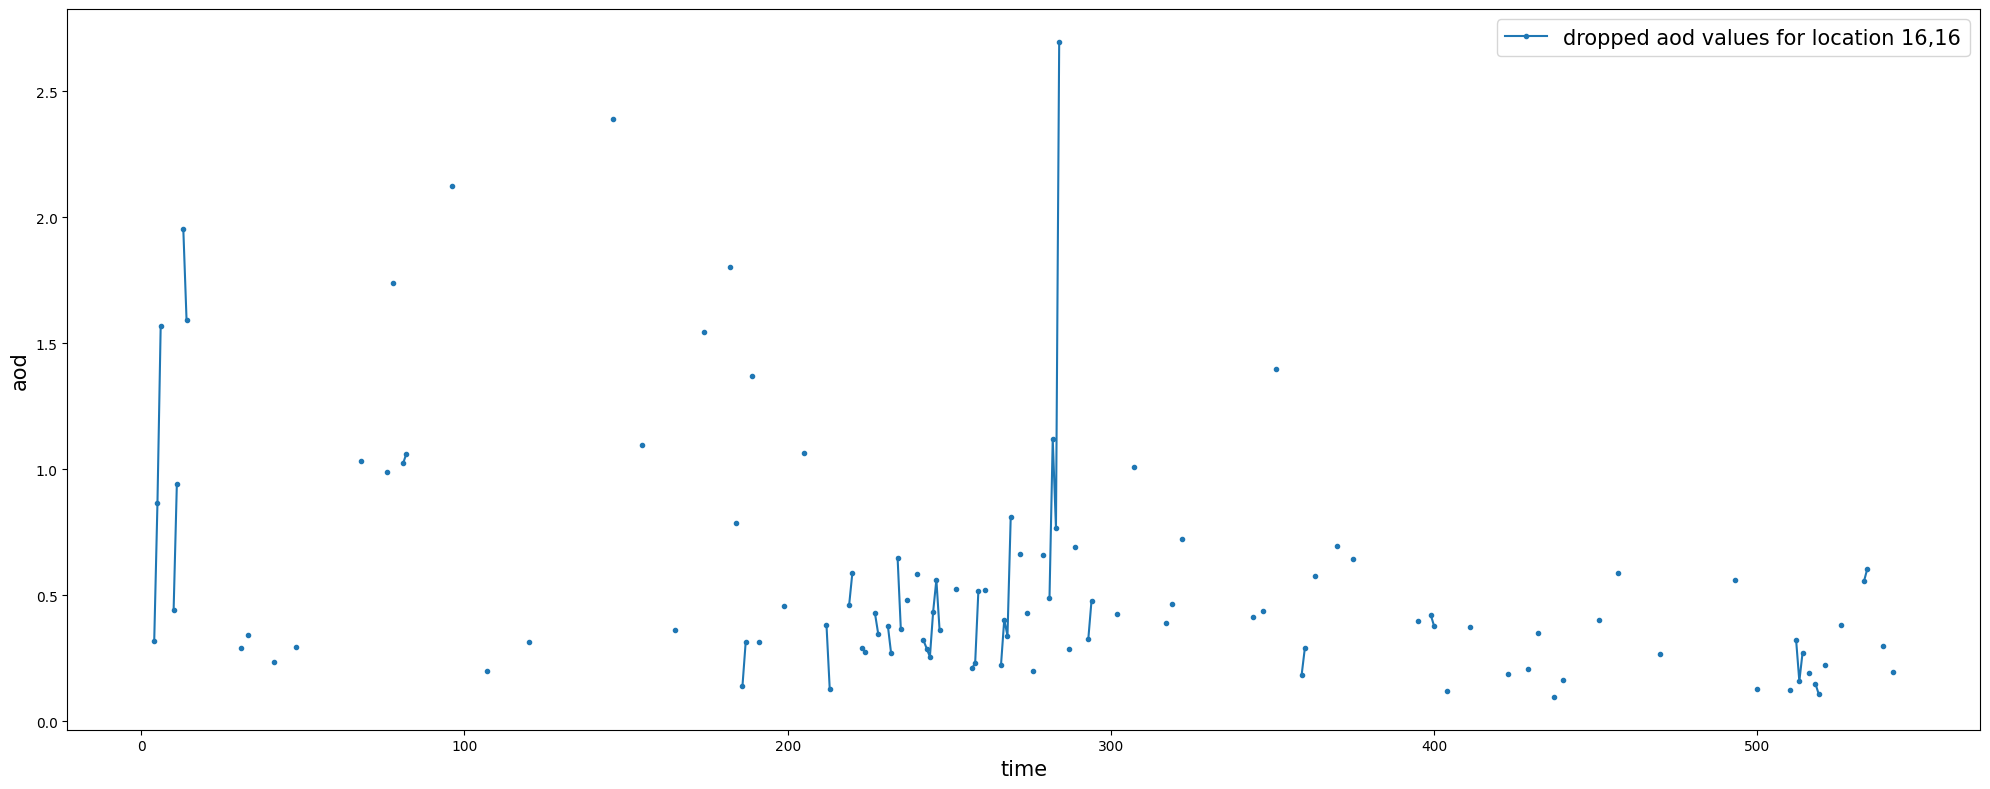

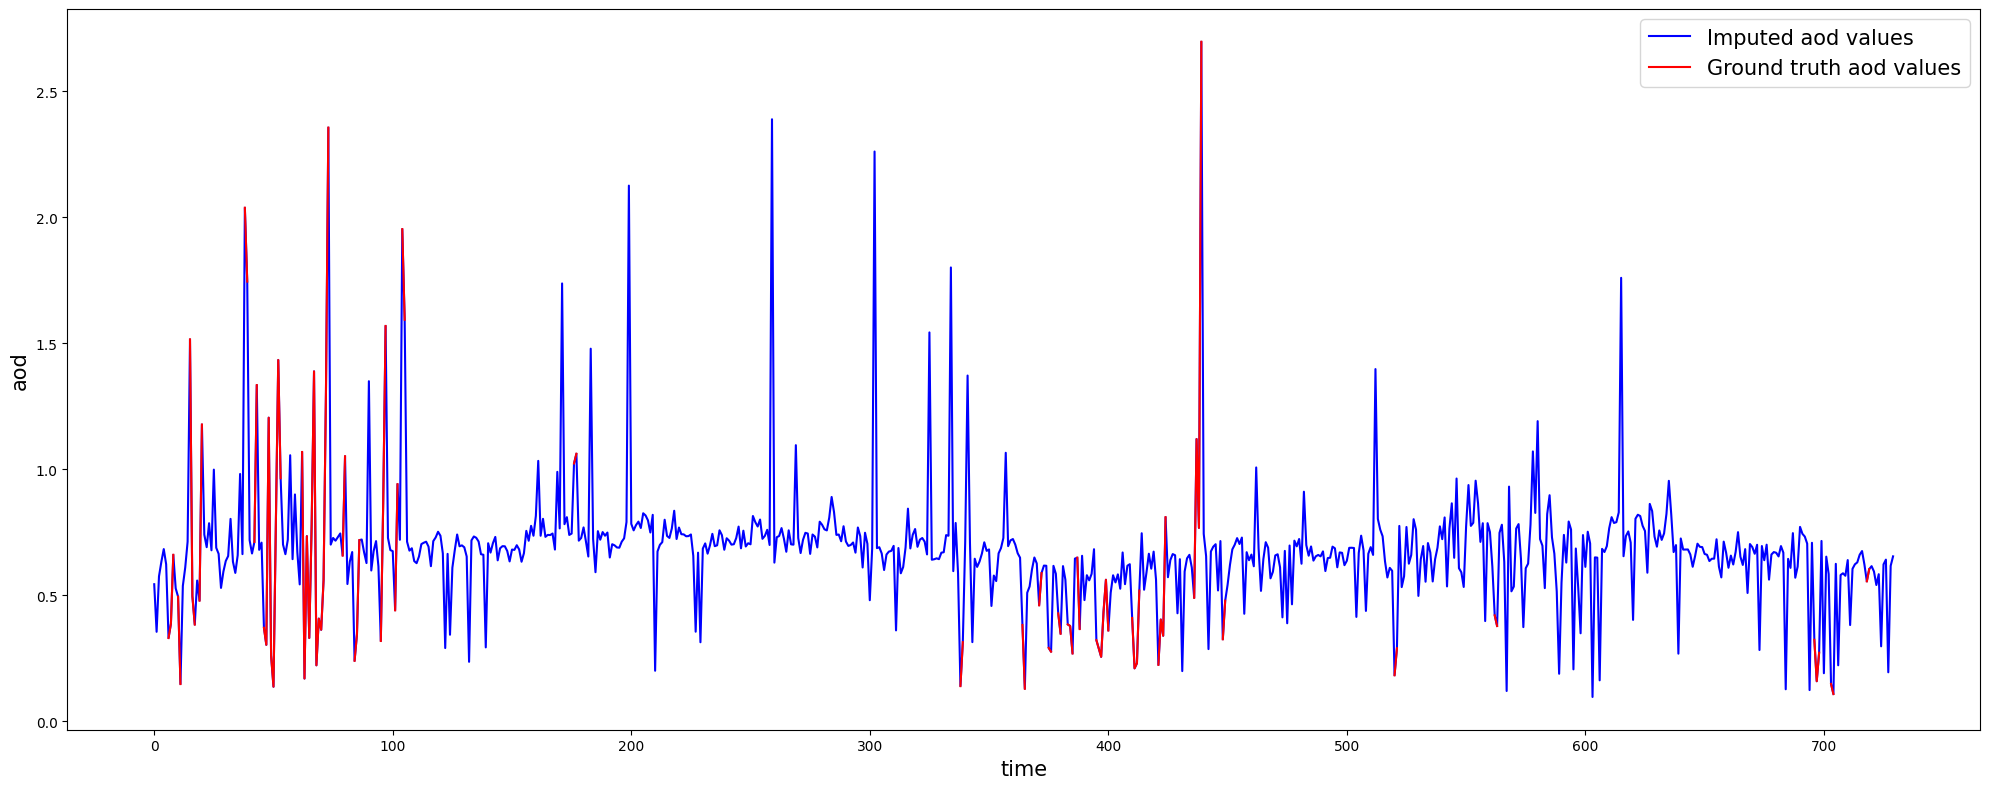


Handling label and dynamic features for 16, 17...



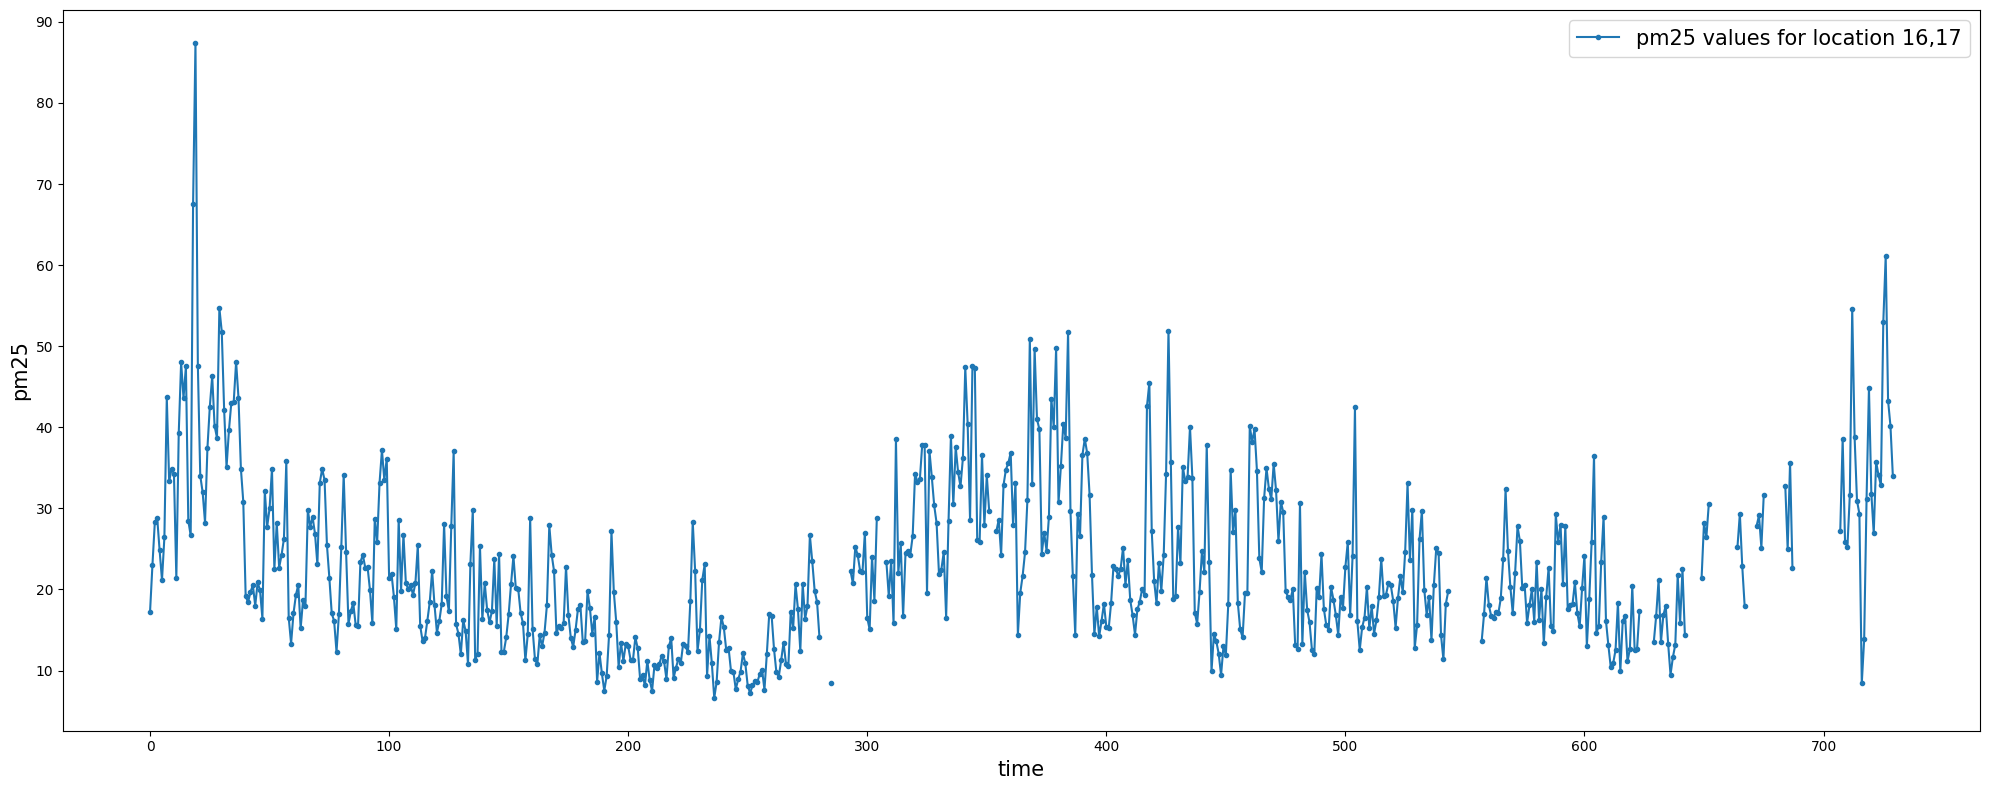

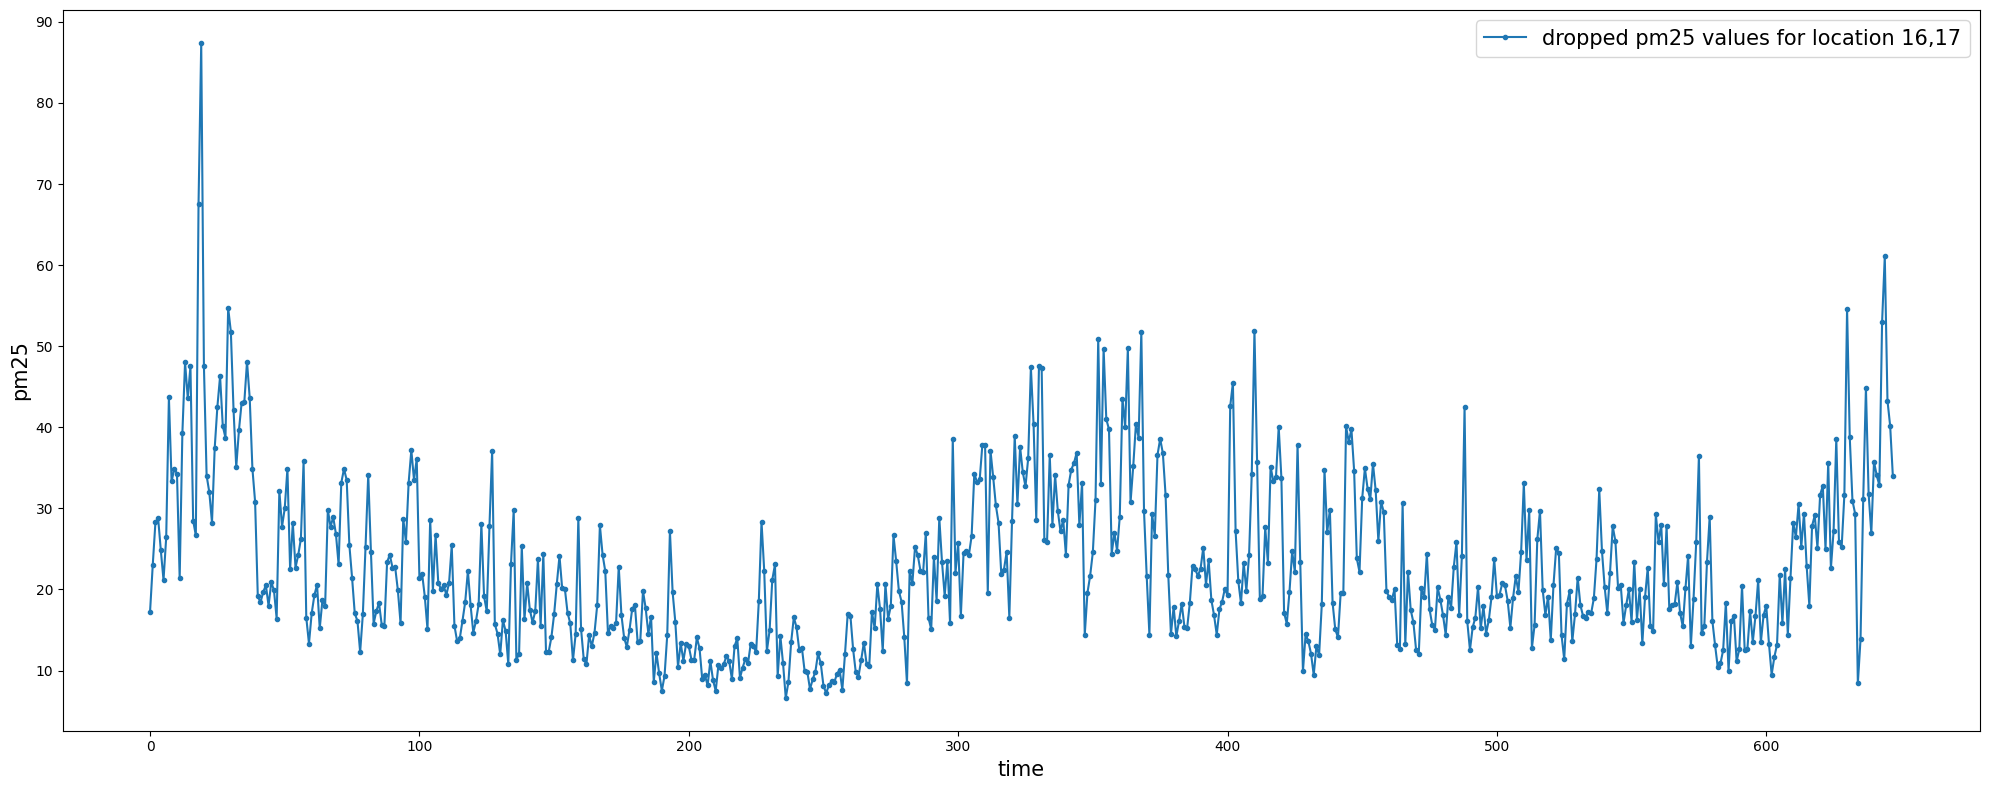

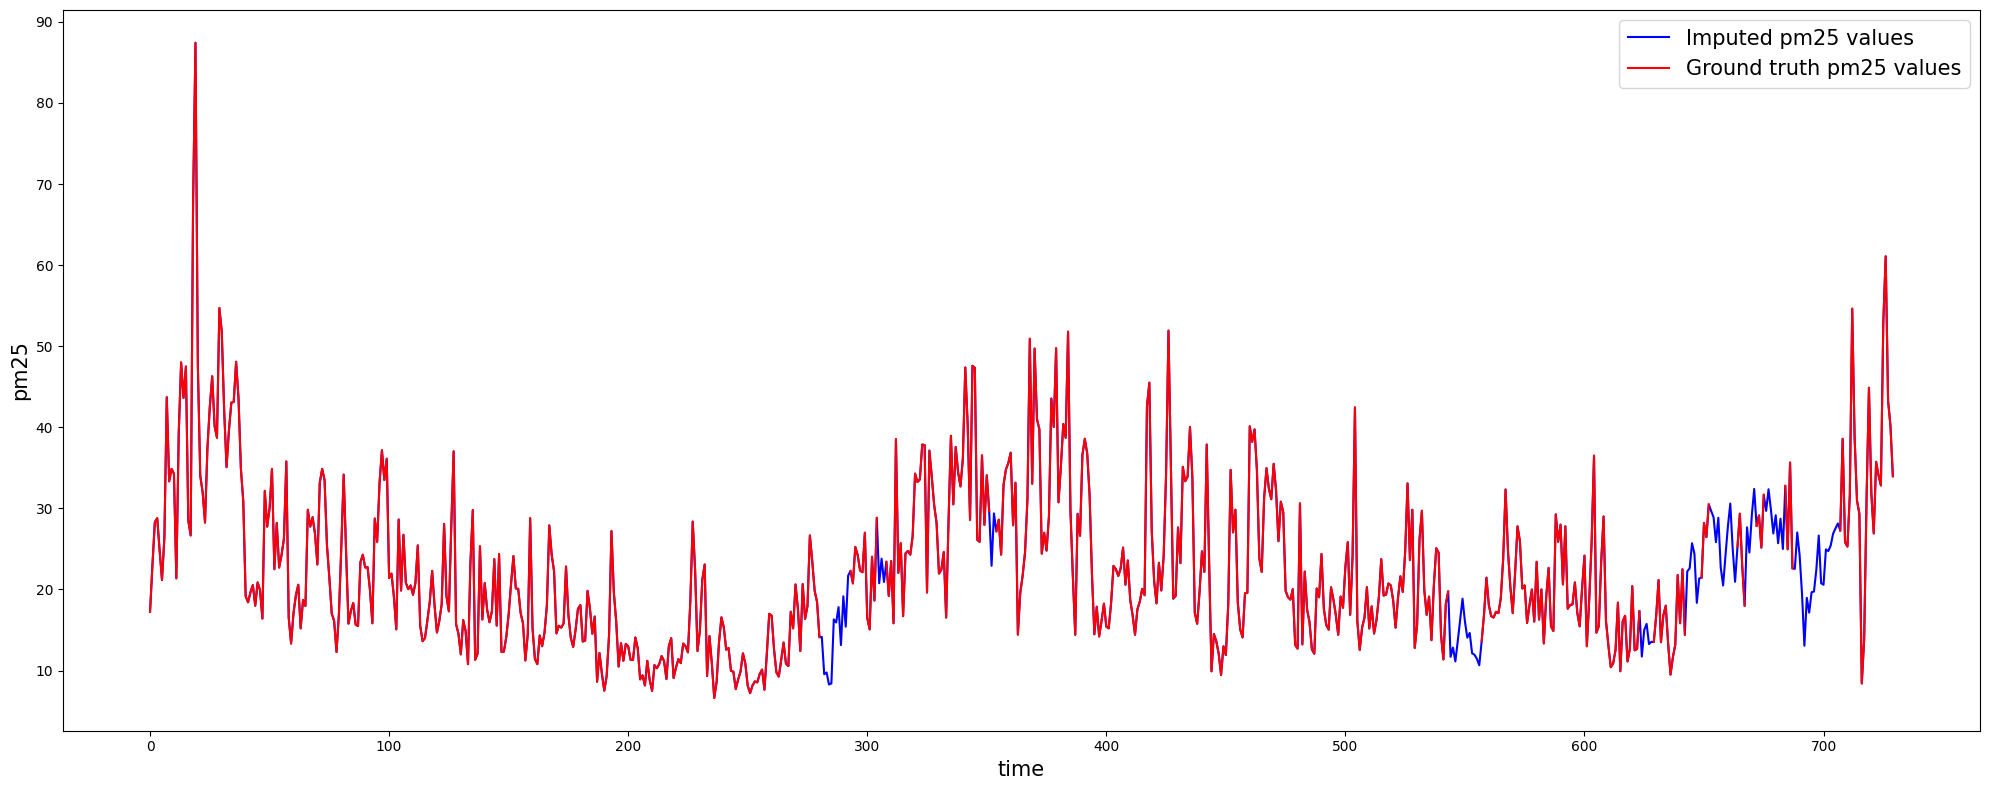

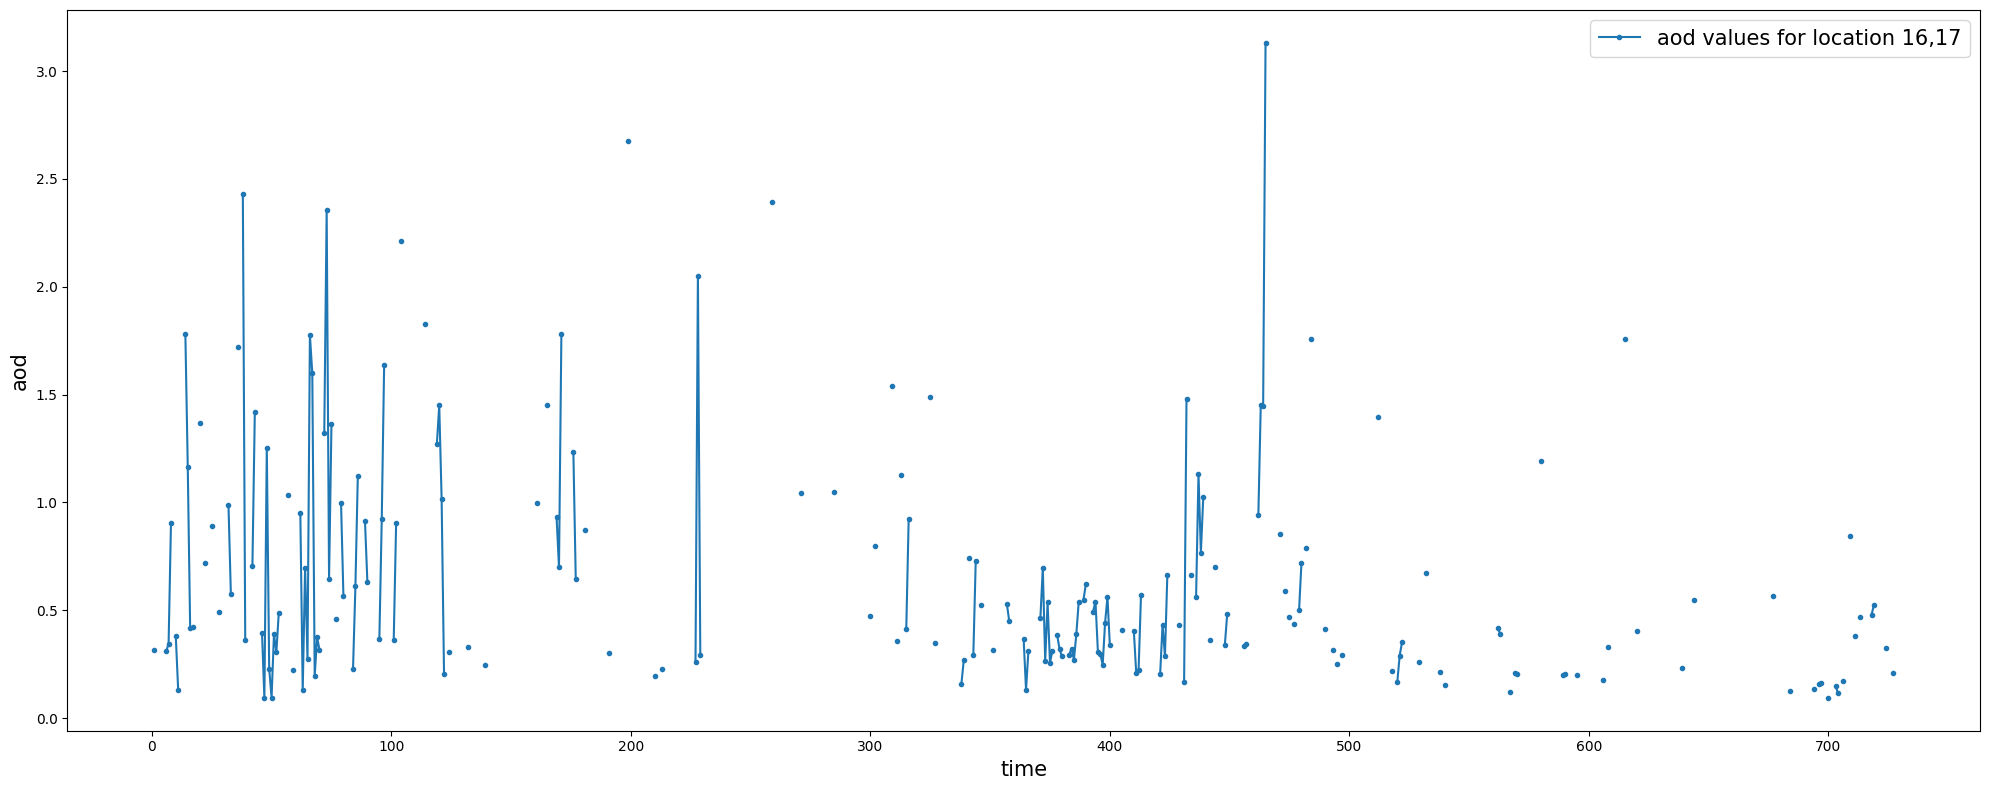

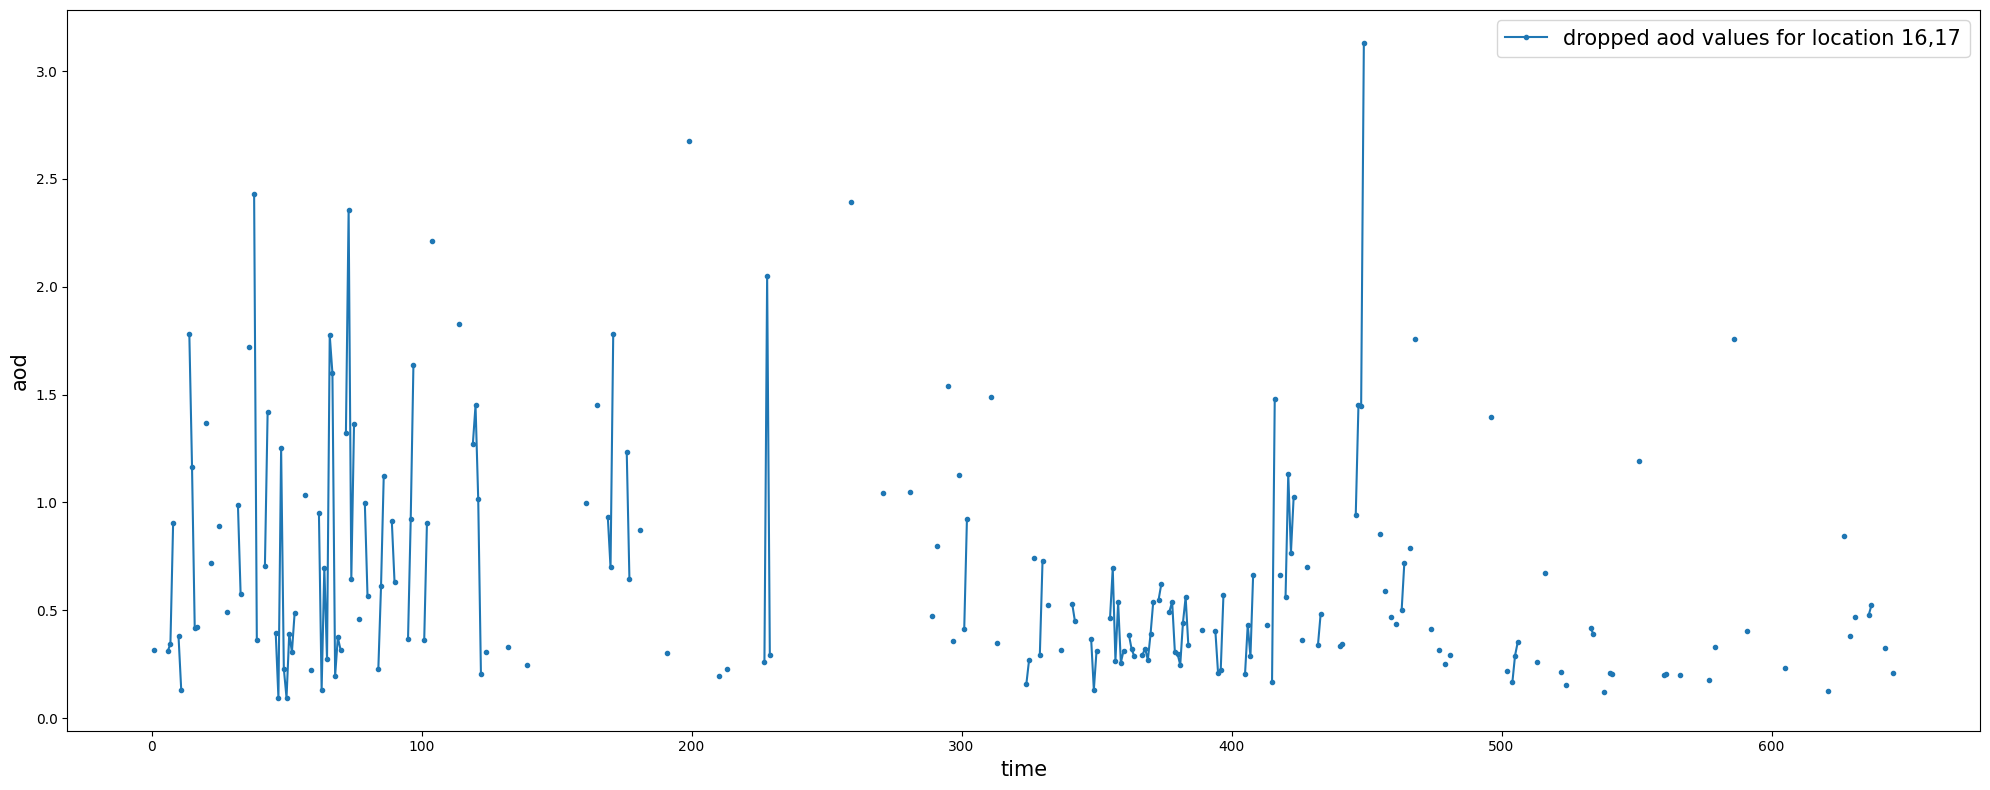

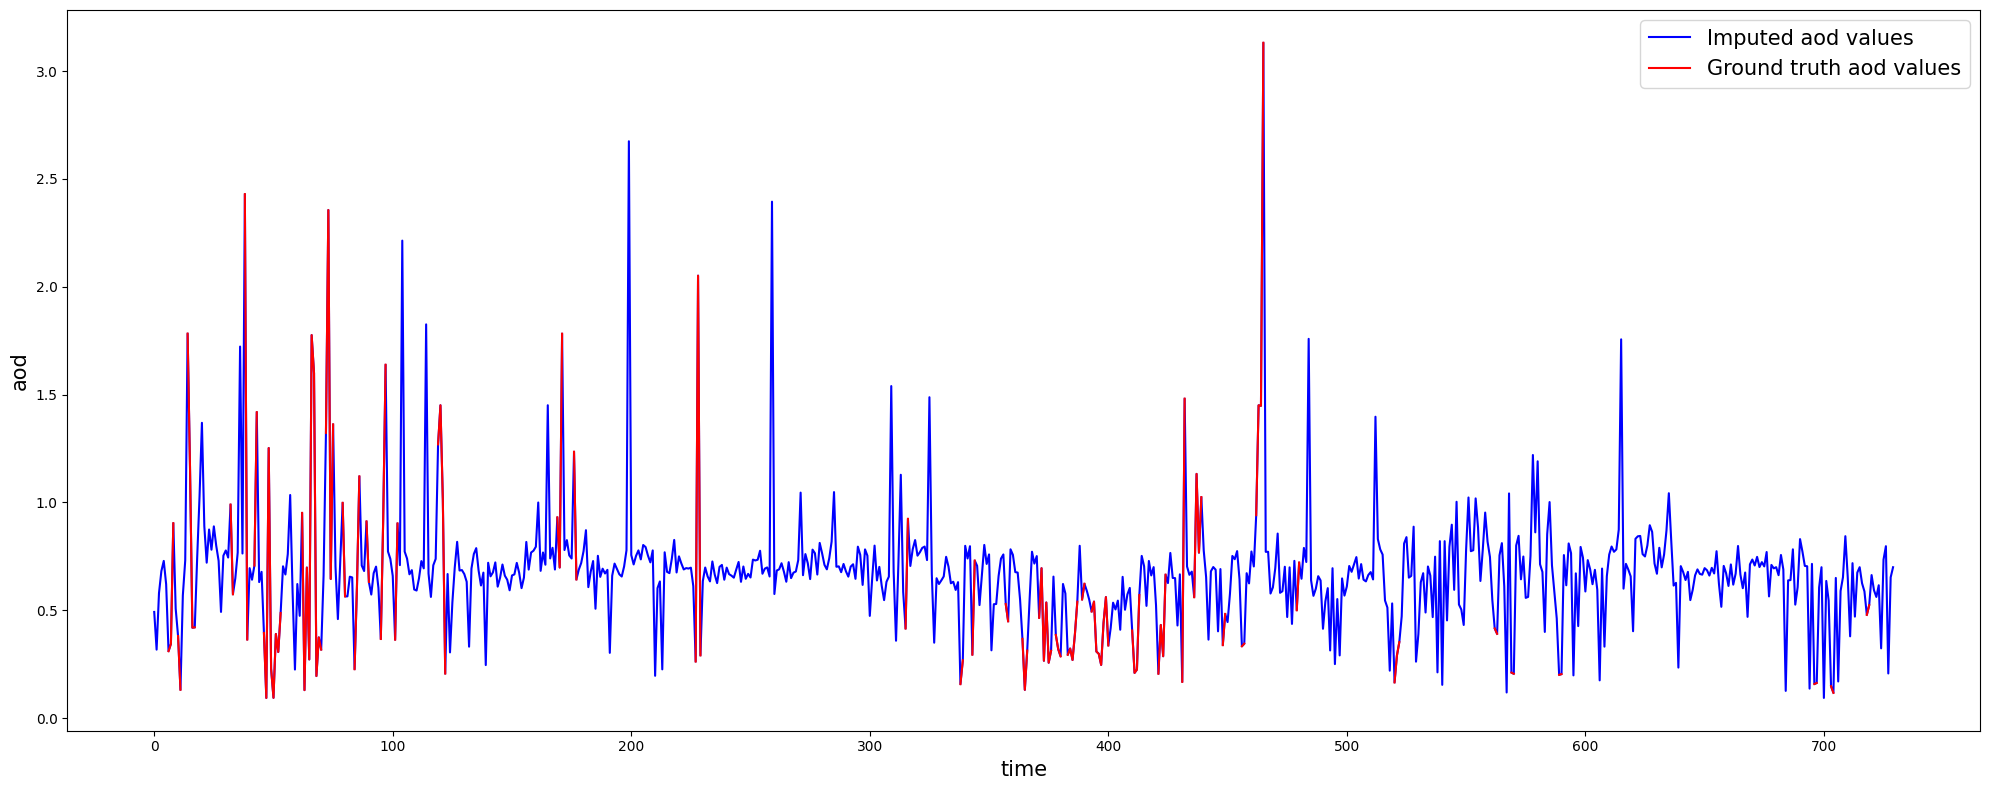


Handling label and dynamic features for 17, 17...



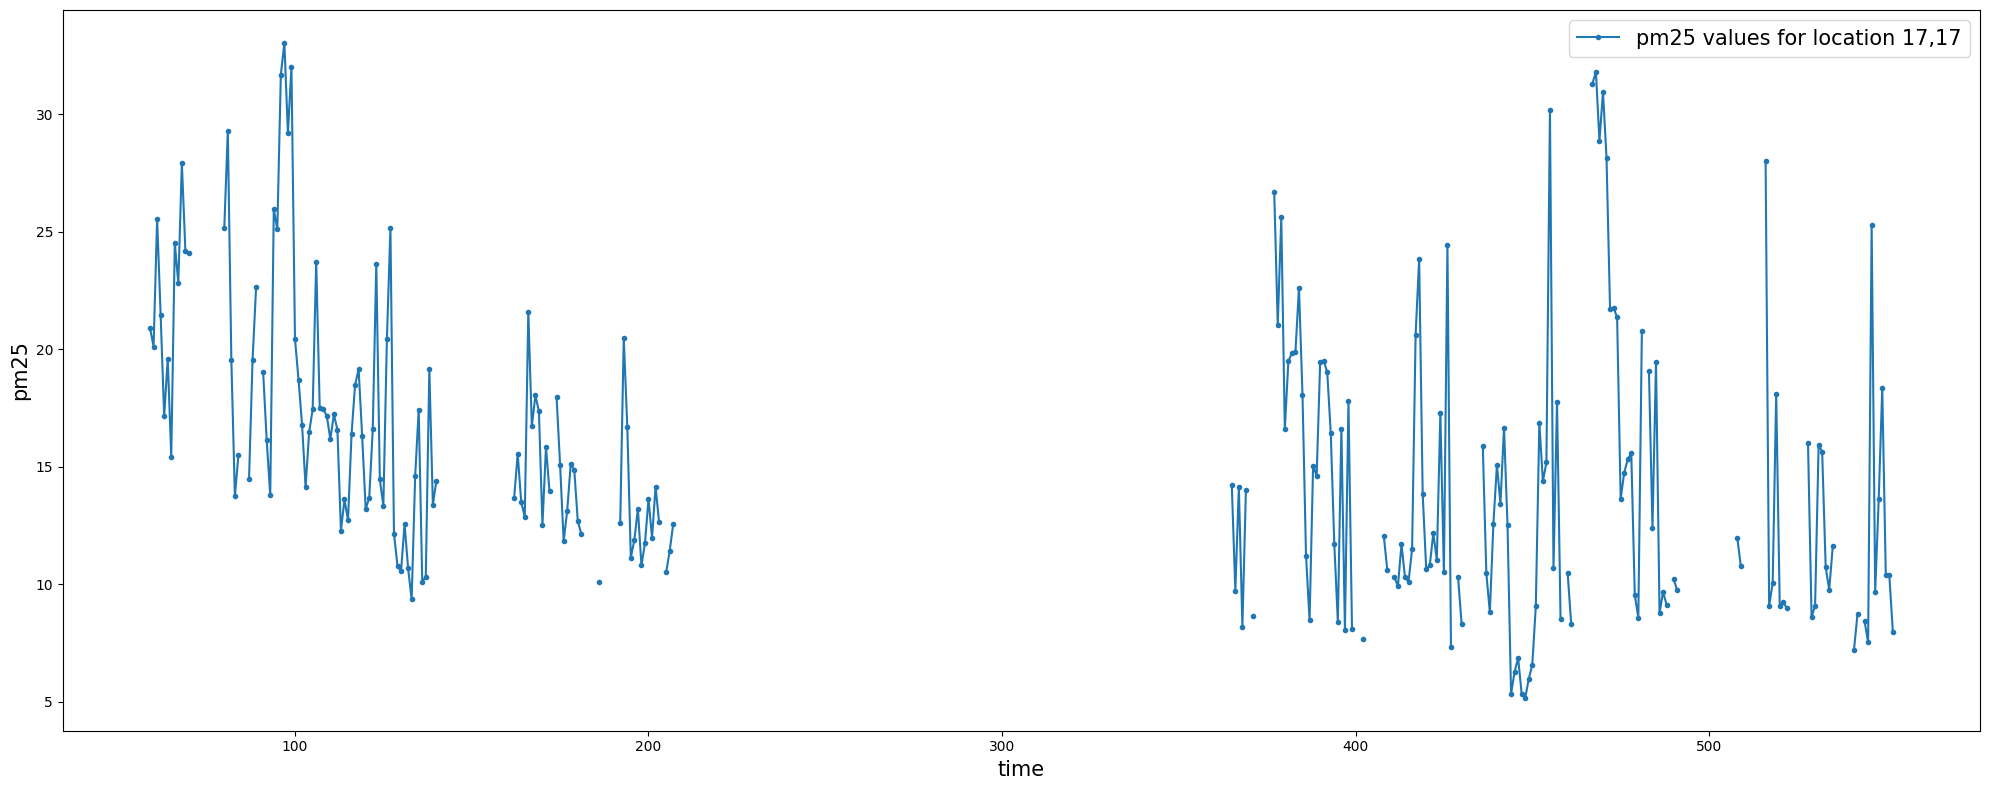

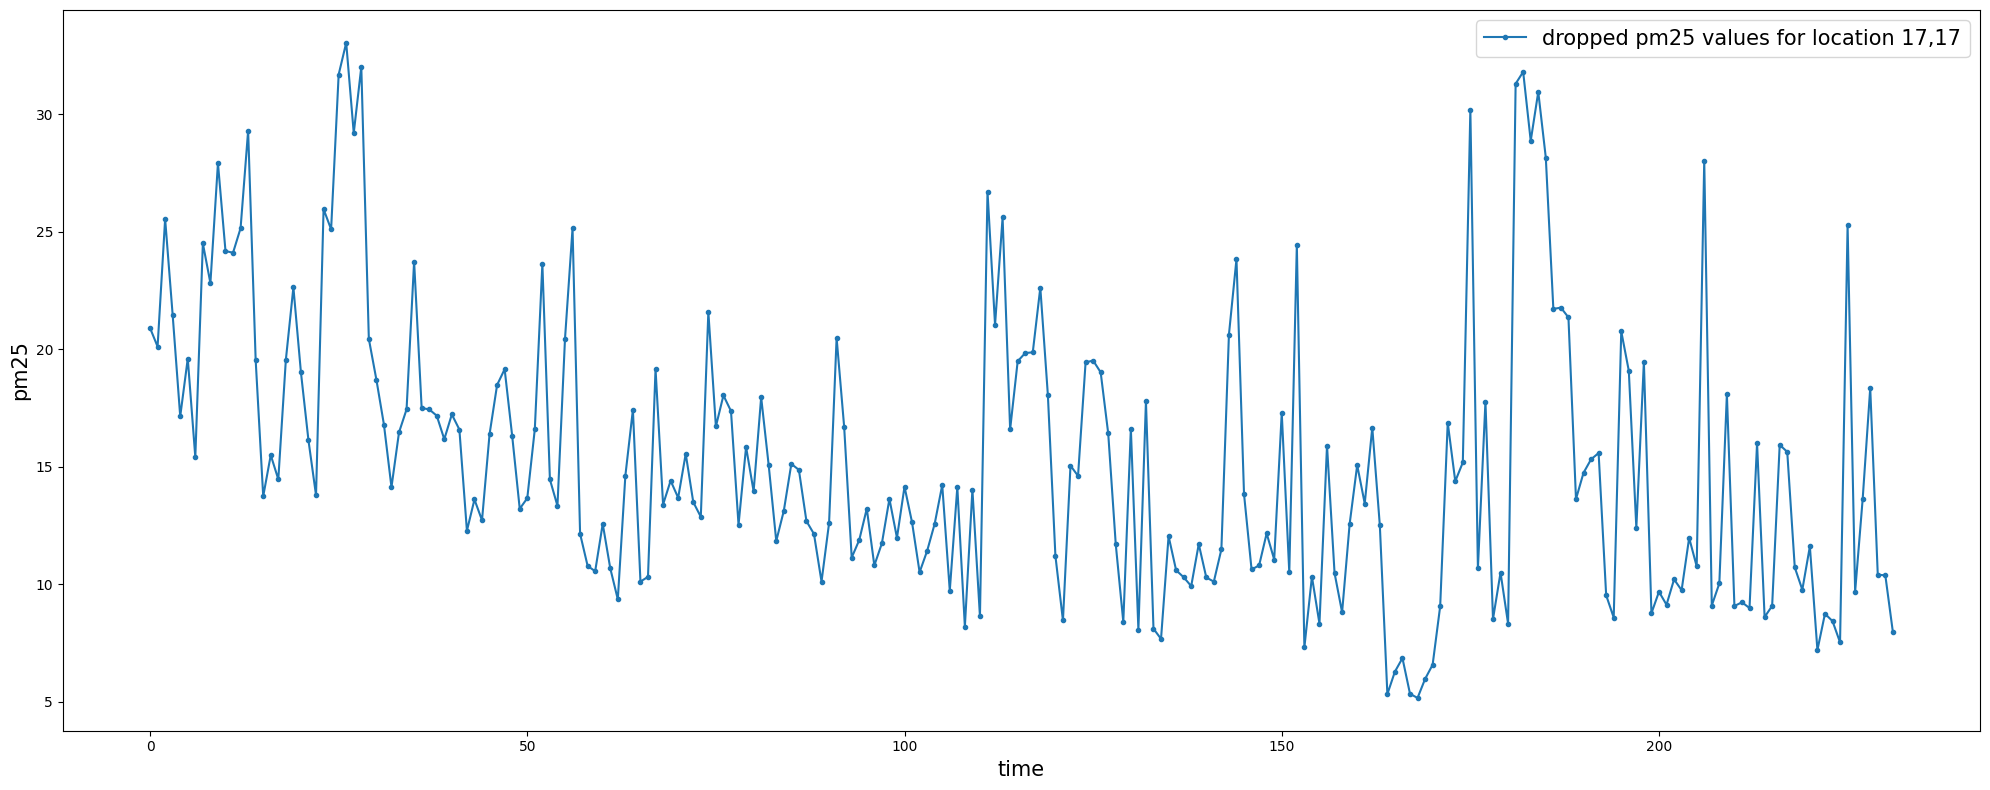

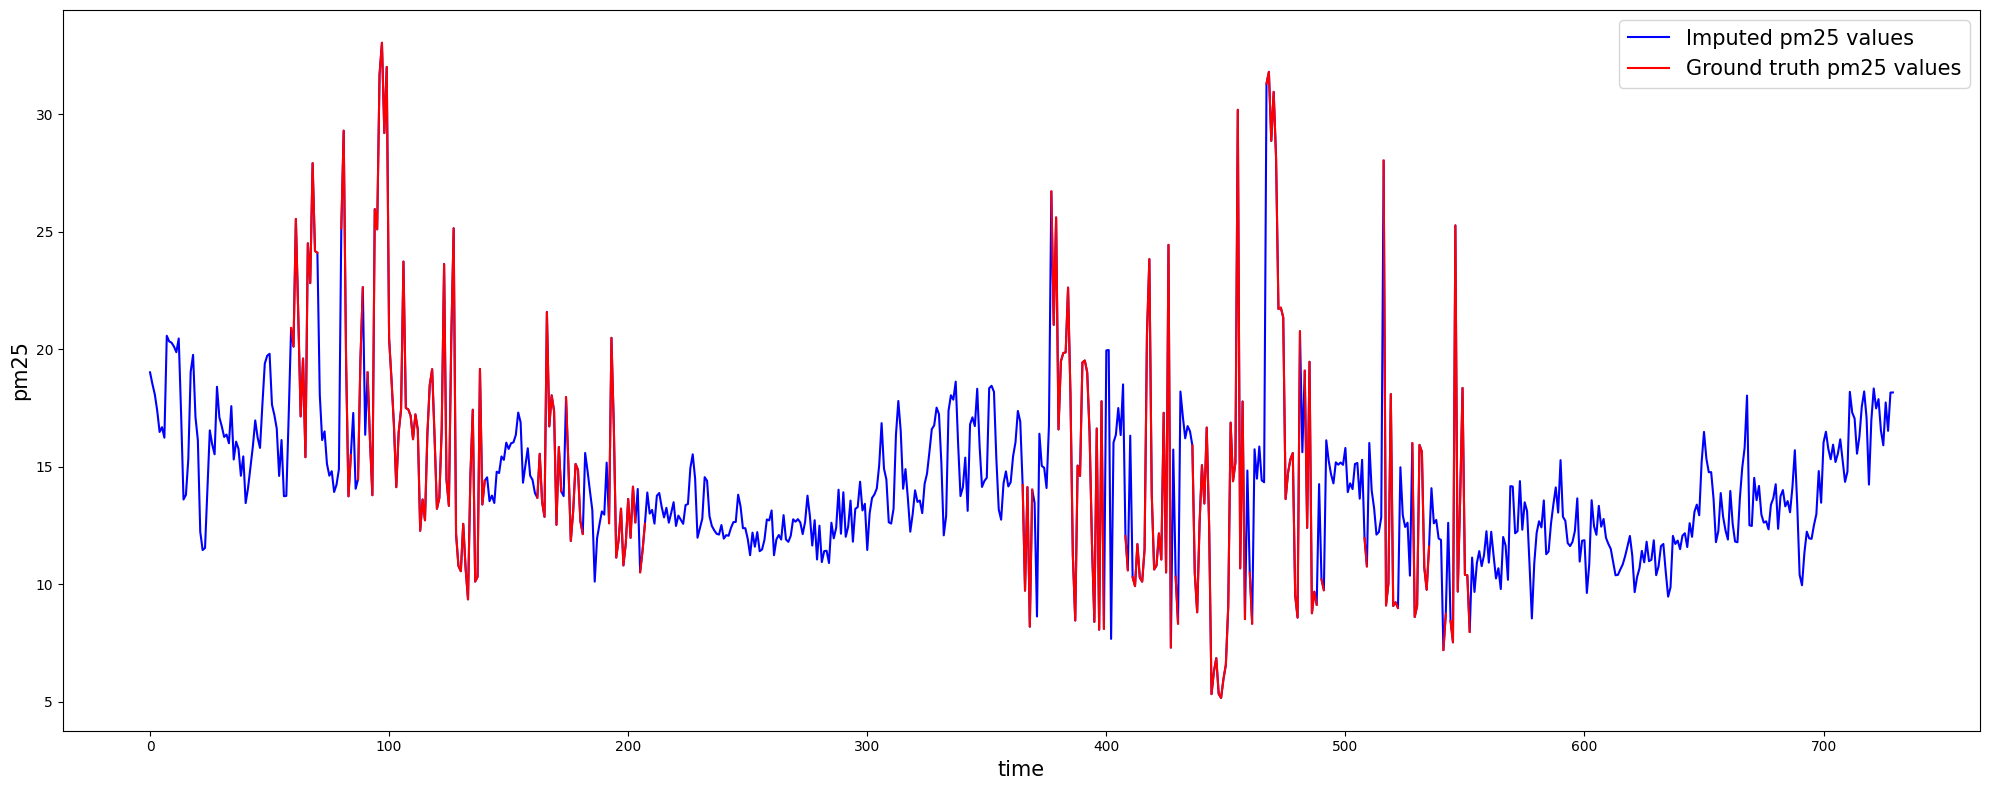

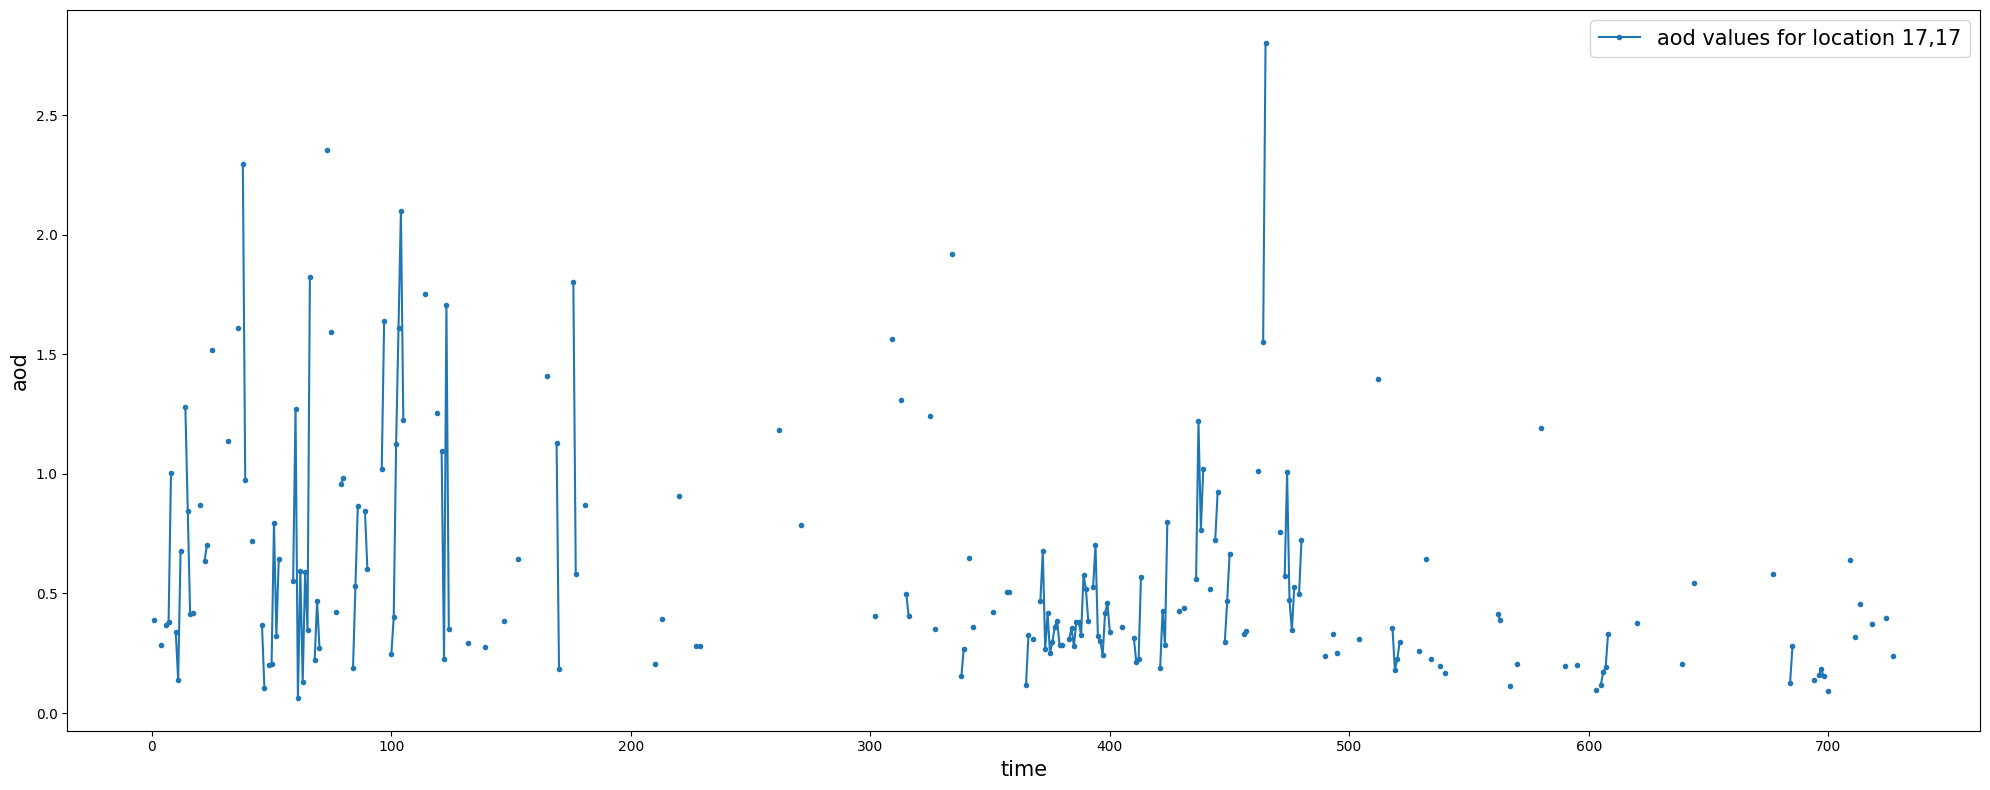

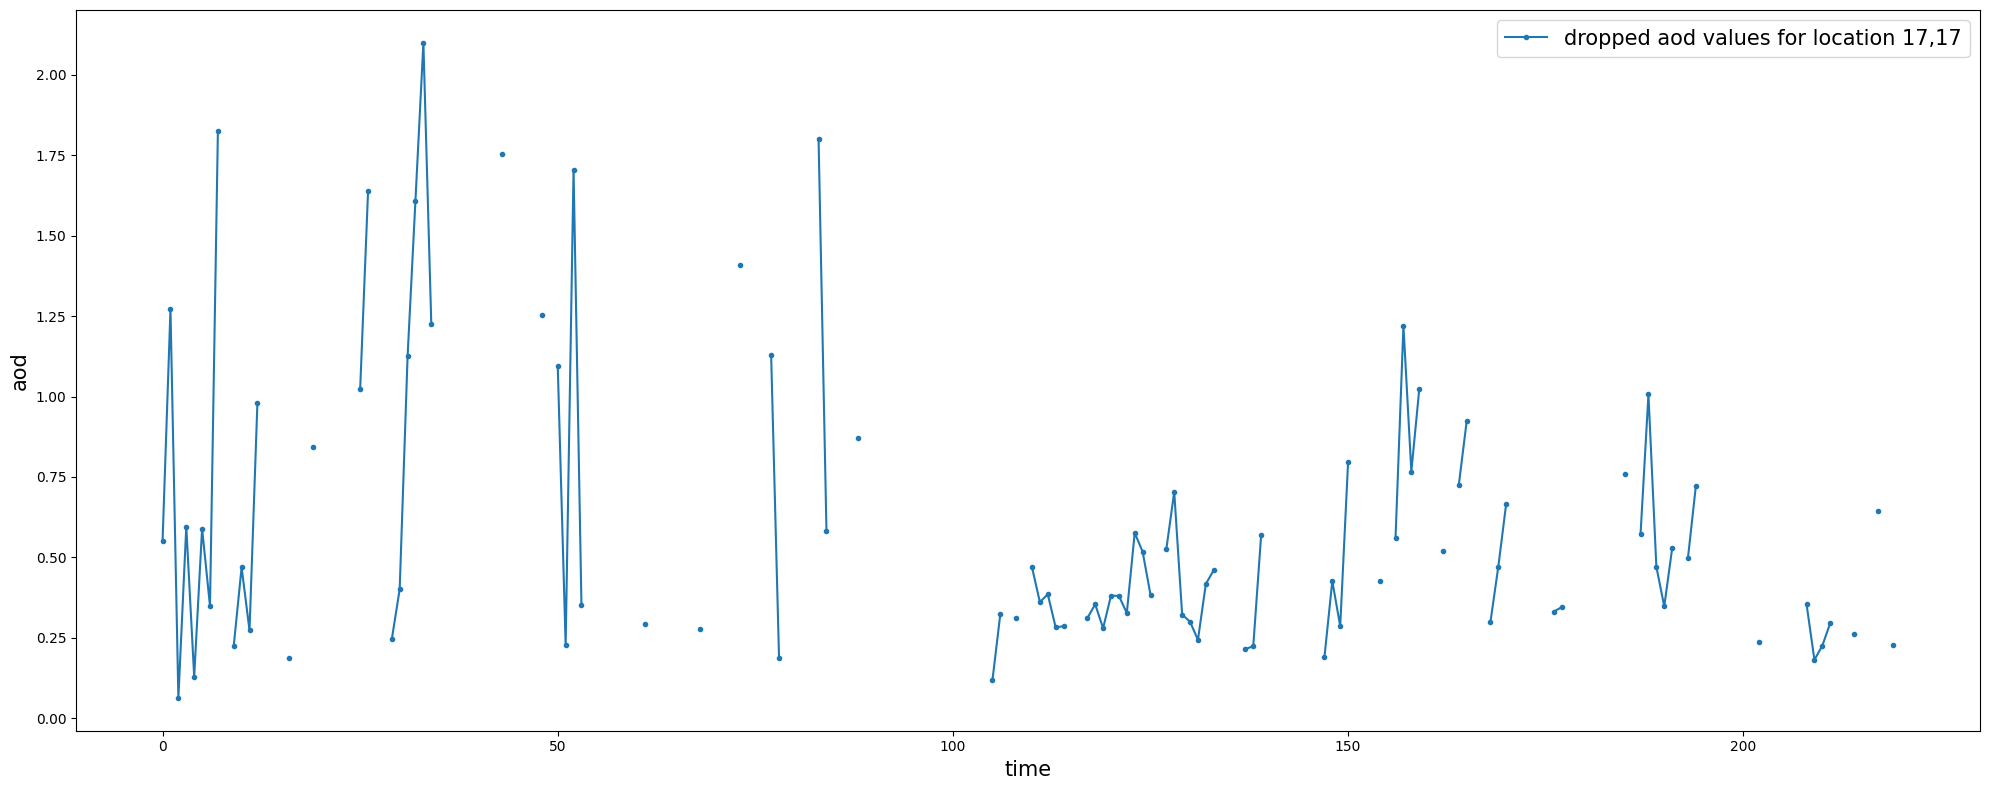

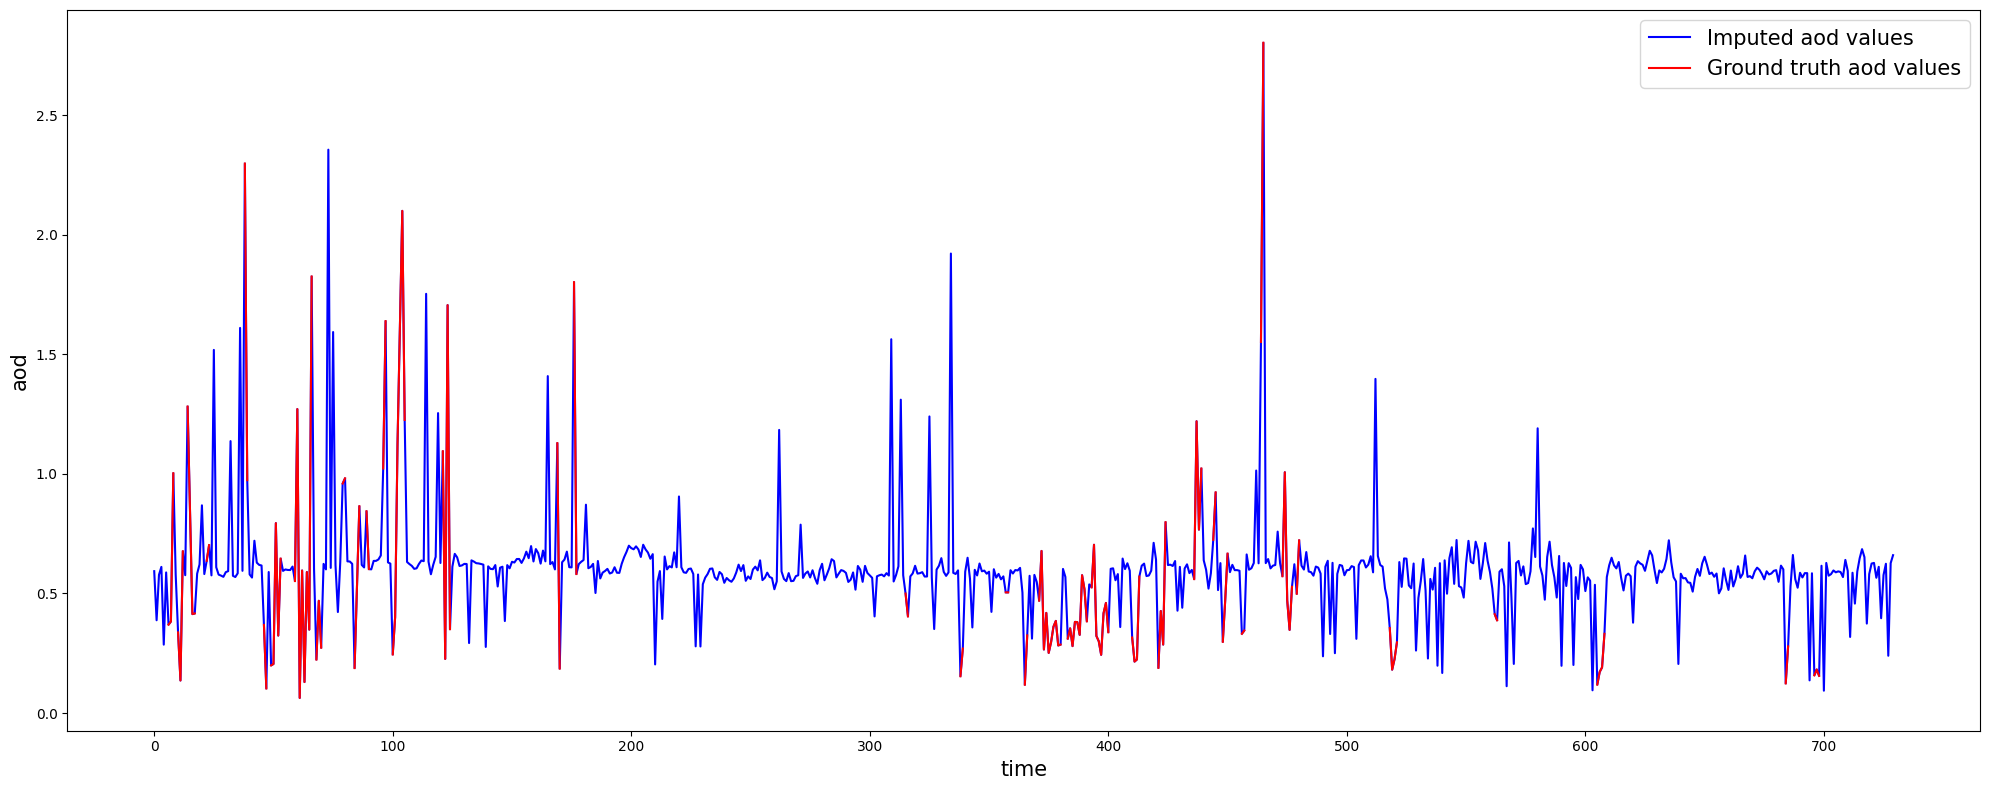


Handling label and dynamic features for 18, 14...



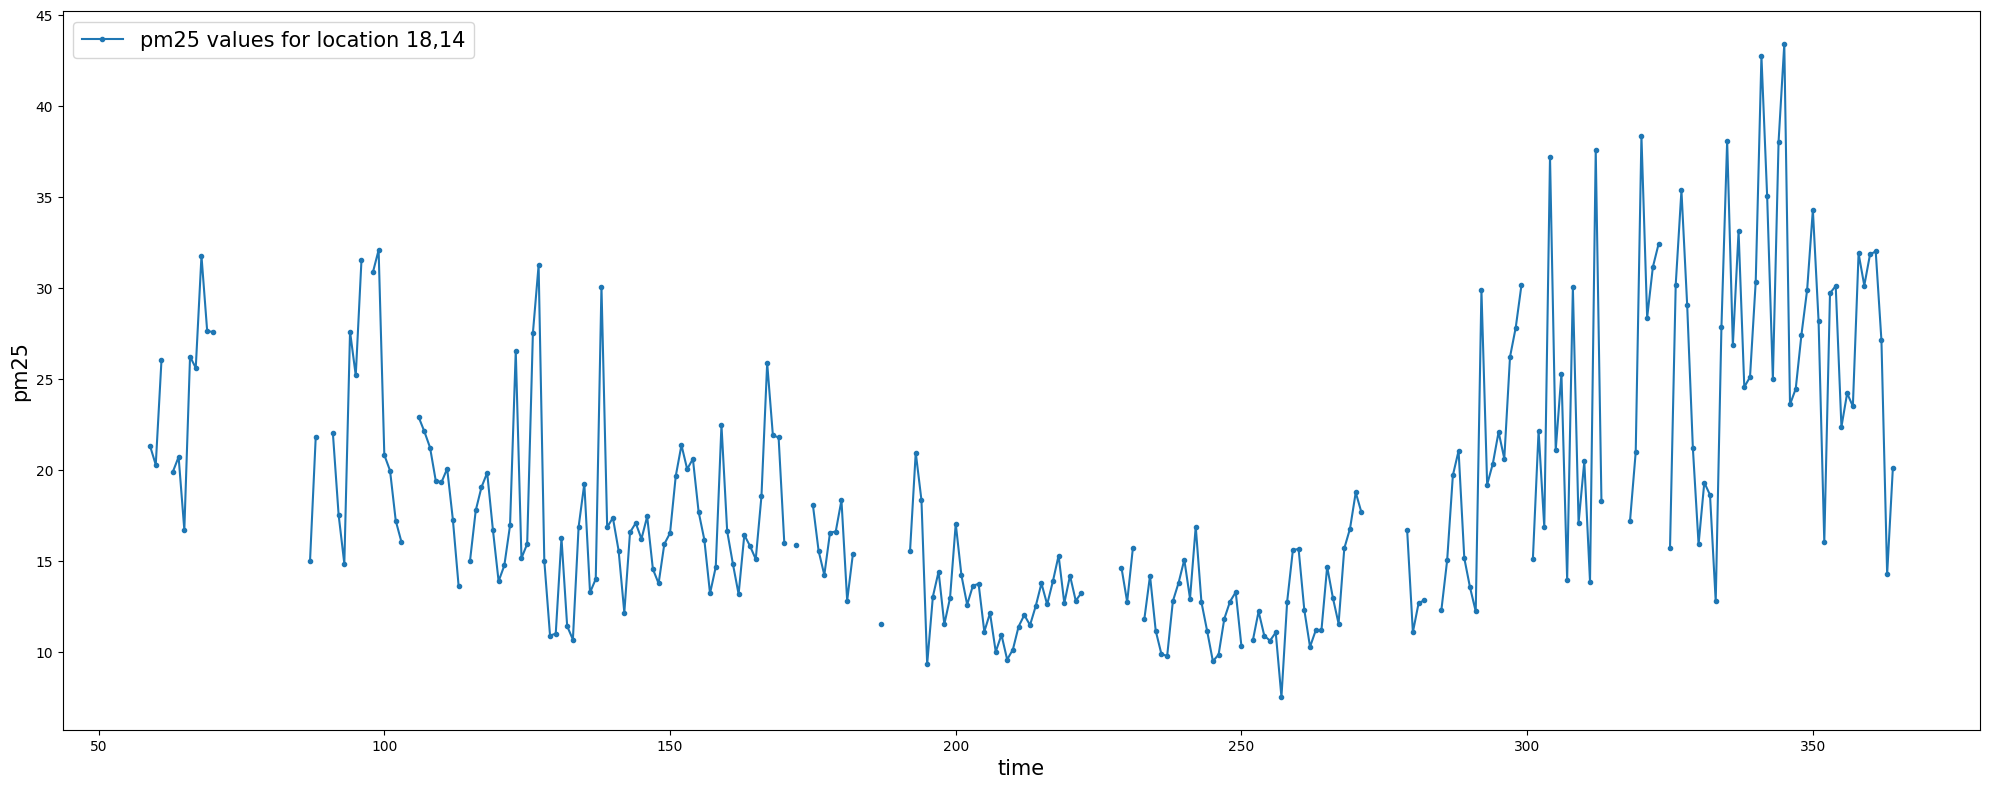

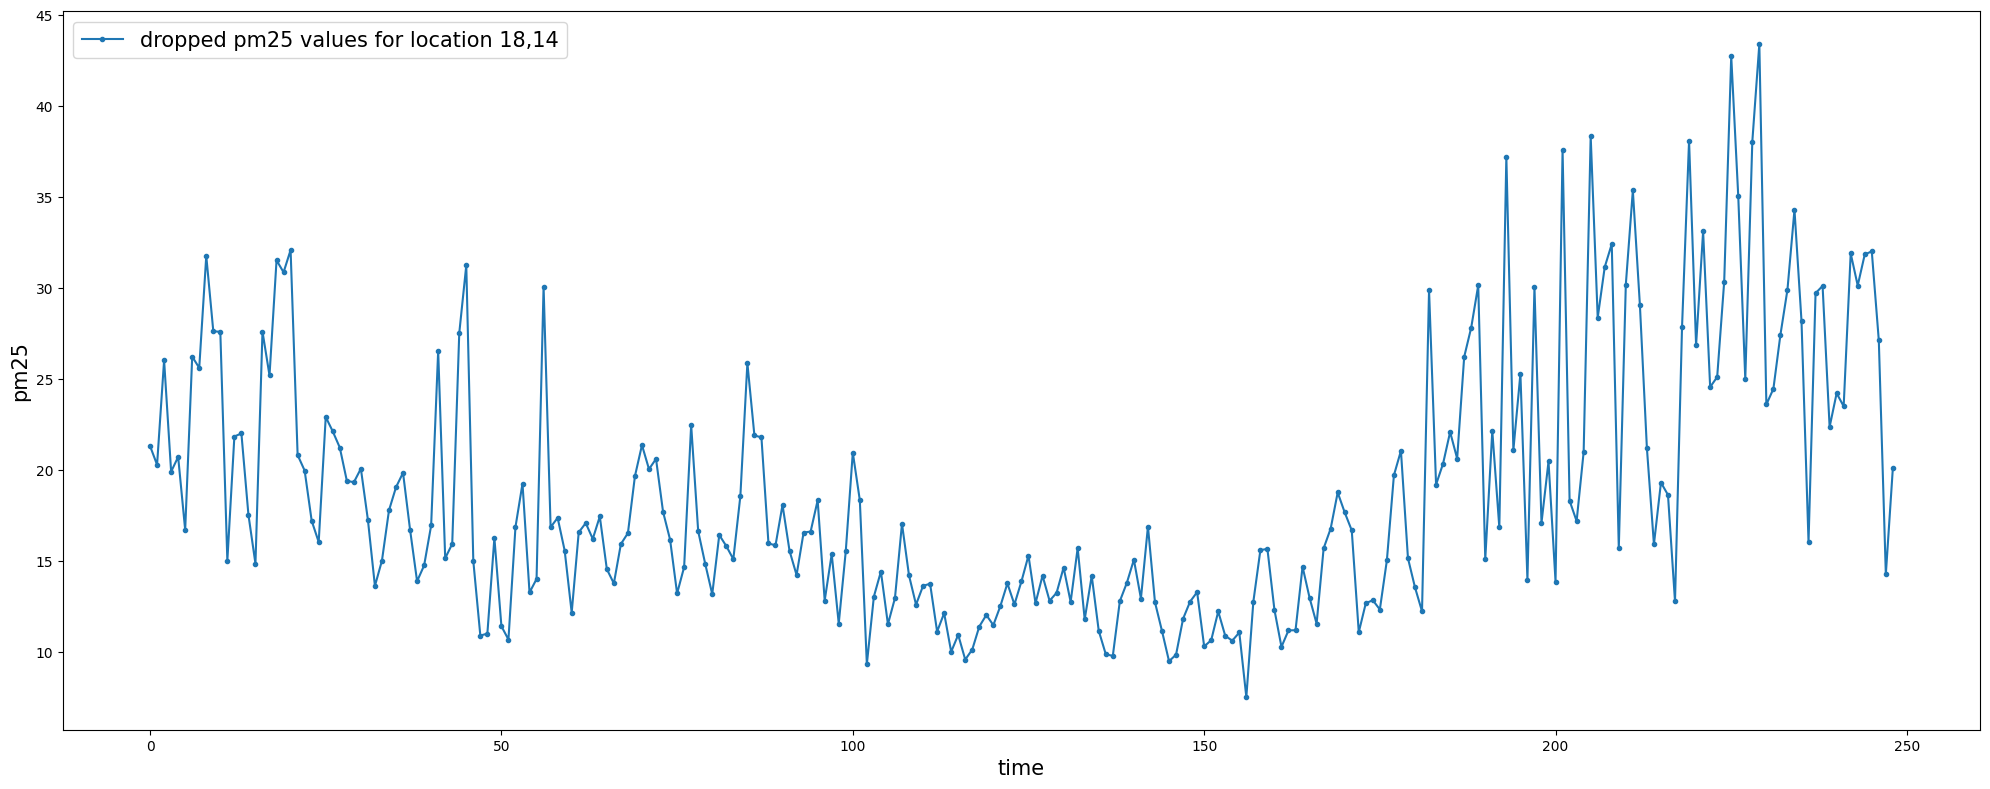

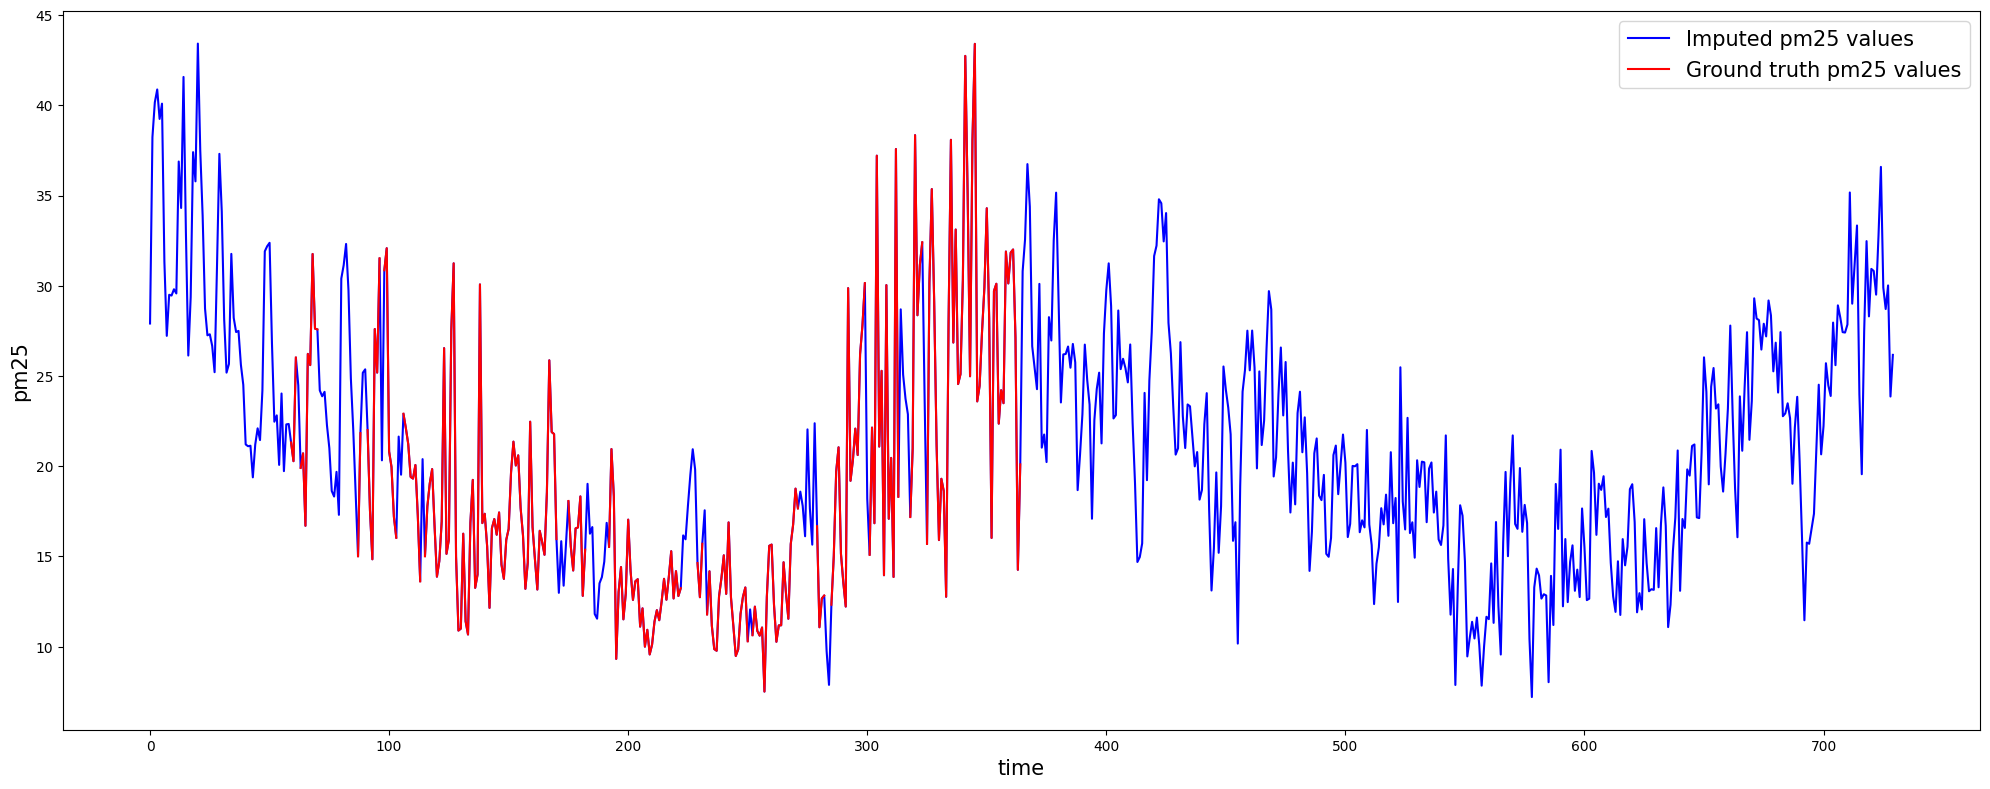

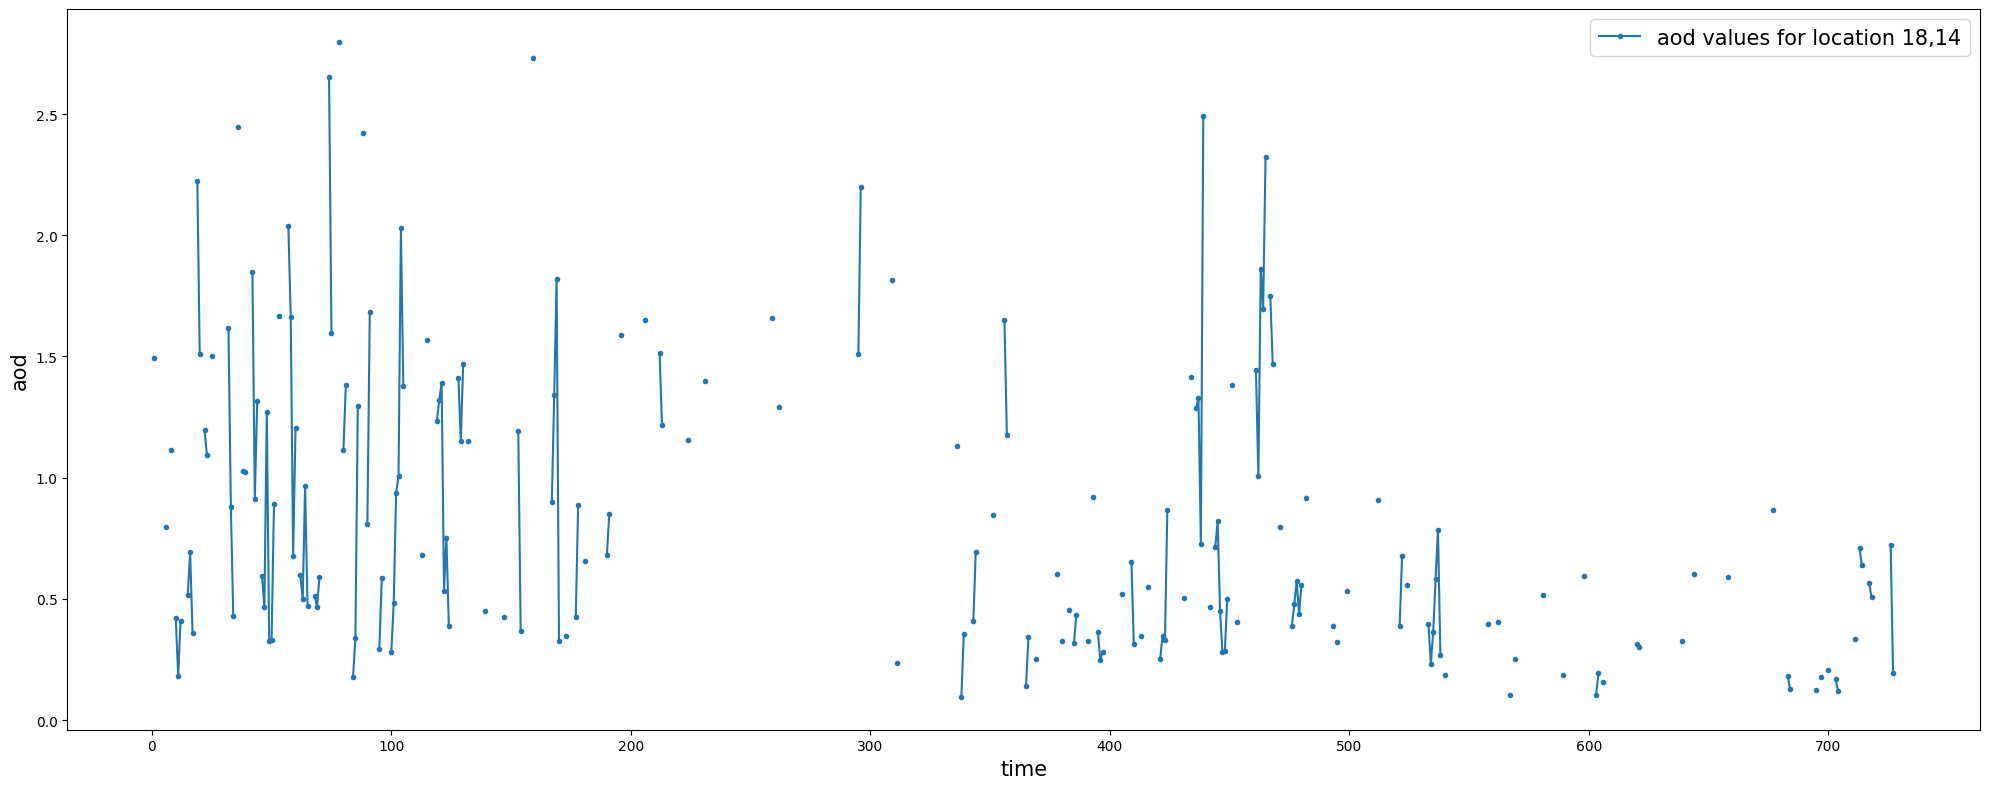

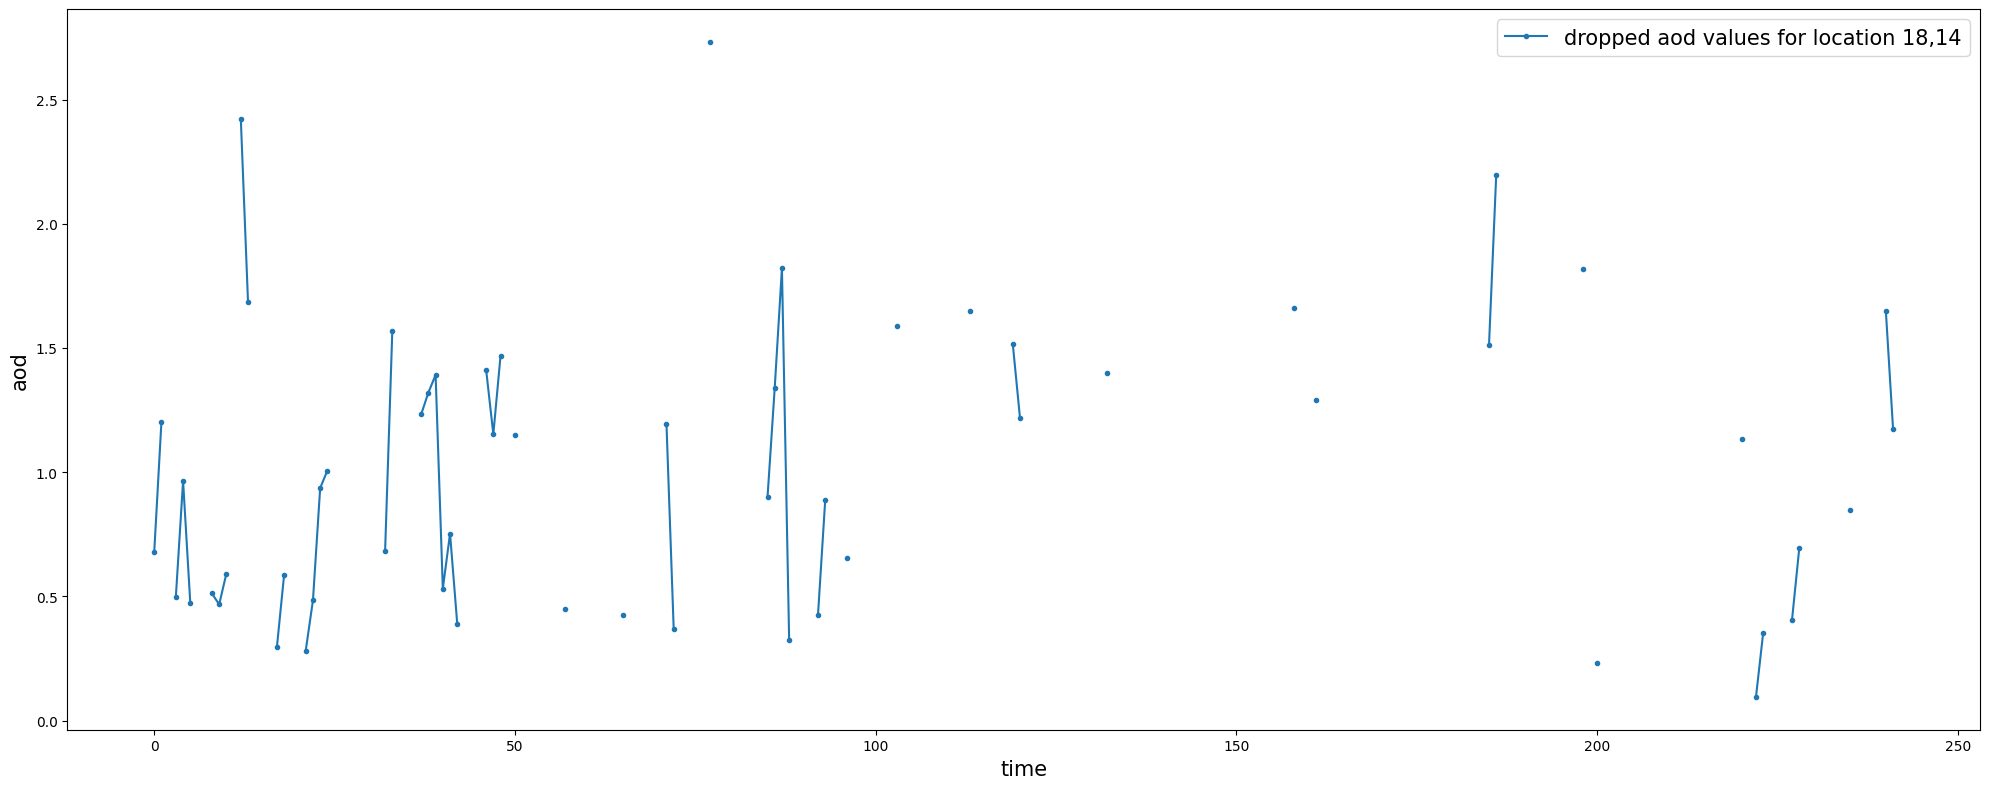

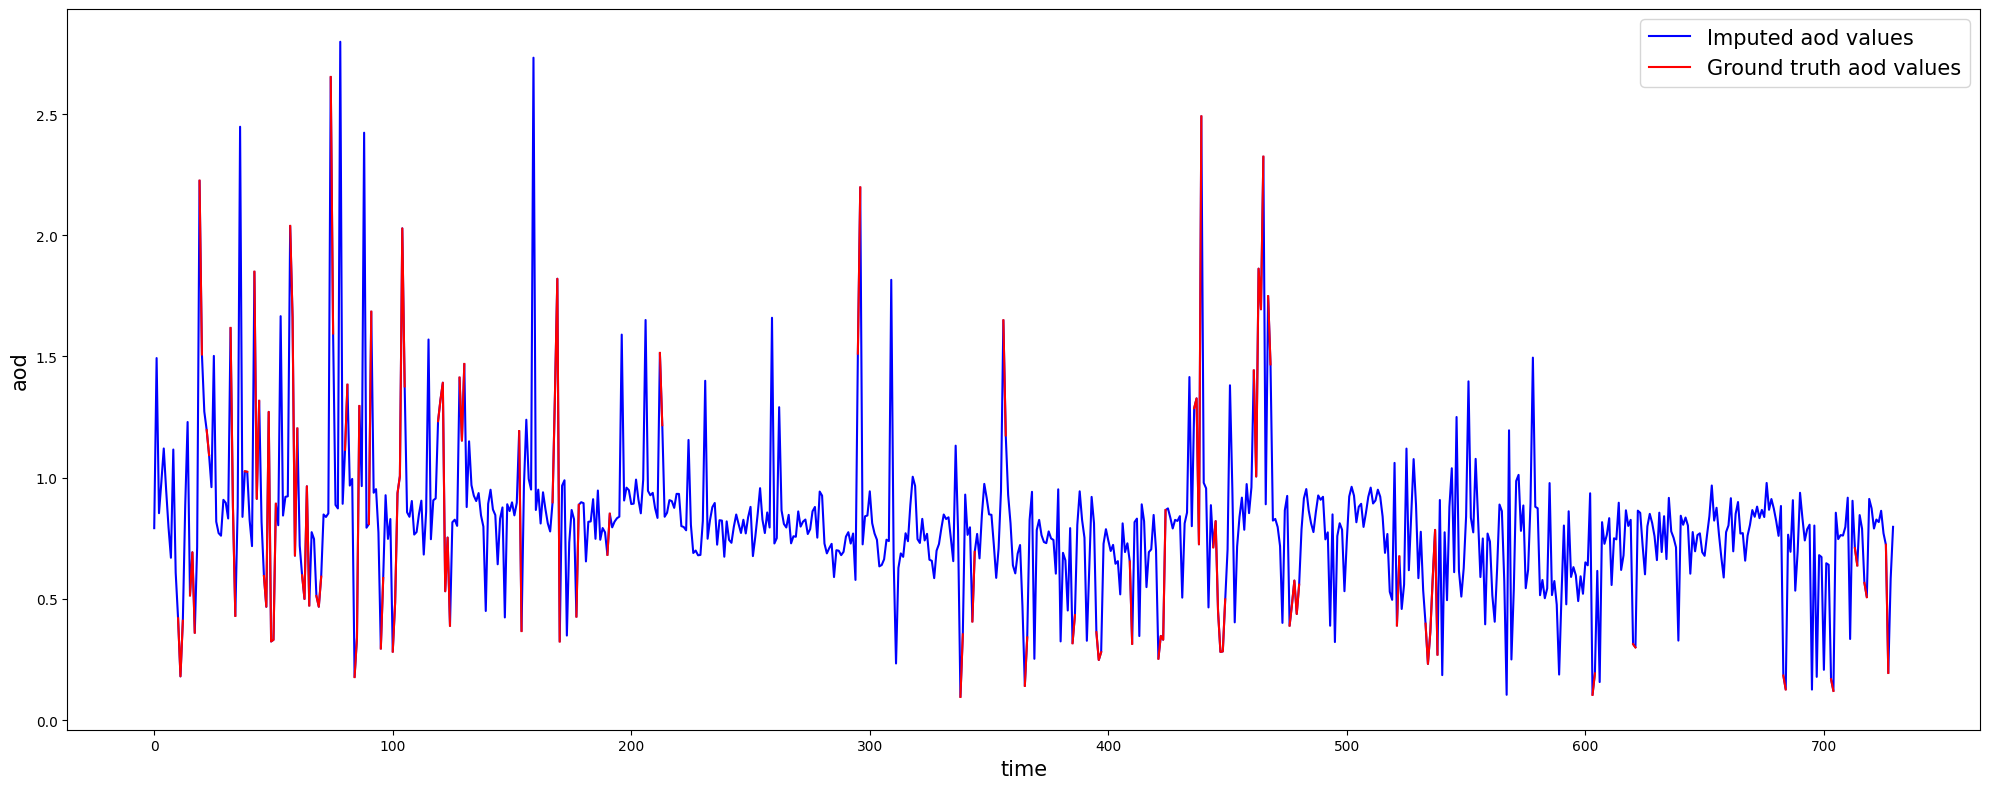

In [52]:
imputed_training_data = []

for (i, j) in locations_with_stations:
    df_current_ij = df_training.loc[(df_training["i"] == i) & (df_training["j"] == j)]
    print(f"\nHandling label and dynamic features for {i}, {j}...\n")

    # Drop label
    df_current_ij_dropped = df_current_ij.dropna(subset=["pm25"])
    
    # Impute data
    df_current_ij_imputed = mice(df_current_ij)
    df_current_ij_dropped_imputed = mice(df_current_ij_dropped)
    
    # Visualization pm25
    visual_columns = ["pm25", "aod"]
    for col in visual_columns:
        plot_1_data(data=df_current_ij[col], datalabel=f"{col} values for location {i},{j}", xlabel="time", ylabel=f"{col}")
        plot_1_data(data=df_current_ij_dropped[col], datalabel=f"dropped {col} values for location {i},{j}", xlabel="time", ylabel=f"{col}")
        plot_2_data(data1=df_current_ij_imputed[col],
                    datalabel1=f"Imputed {col} values",
                    data2=df_current_ij[col],
                    datalabel2=f"Ground truth {col} values",
                    xlabel="time",
                    ylabel=f"{col}")
        
    # Append imputed data
    imputed_training_data.append(df_current_ij_imputed)

df_training = pd.concat(imputed_training_data)

In [53]:
imputed_inference_data = []

for (i, j) in locations_without_stations:
    df_current_ij = df_inference.loc[(df_inference["i"] == i) & (df_inference["j"] == j)]
    # Impute data
    # Do not impute pm25 and station column
    noimpute_cols = df_current_ij.loc[:, ["pm25", "station"]]
    df_current_ij_imputed = mice(df_current_ij.drop(columns=["pm25", "station"]))
    # Append imputed data
    imputed_inference_data.append(pd.concat([df_current_ij_imputed, noimpute_cols], axis=1))

df_inference = pd.concat(imputed_inference_data)

In [54]:
display(df_training.isnull().sum())
display(df_inference.isnull().sum())

i                    0
j                    0
lat                  0
lon                  0
pm25_3km             0
tmp                  0
rh                   0
hpbl                 0
wspd                 0
pop                  0
road_den_1km         0
prim_road_len_1km    0
near_dist            0
bareland             0
builtup              0
cropland             0
grassland            0
treecover            0
water                0
ndvi                 0
aod                  0
station              0
pm25                 0
dtype: int64

i                         0
j                         0
lat                       0
lon                       0
pm25_3km                  0
tmp                       0
rh                        0
hpbl                      0
wspd                      0
pop                       0
road_den_1km              0
prim_road_len_1km         0
near_dist                 0
bareland                  0
builtup                   0
cropland                  0
grassland                 0
treecover                 0
water                     0
ndvi                      0
aod                       0
pm25                 708100
station              708100
dtype: int64

### Append training with cmaq

In [55]:
df_cmaq = copy.deepcopy(df_cmaq_raw)

In [56]:
display(df_training)
display(df_cmaq)

i   j        lat         lon   pm25_3km        tmp         rh  \
time                                                                         
2021-01-01  12  22  10.879919  106.803950  30.366625  25.749989  61.403439   
2021-01-02  12  22  10.879919  106.803950  46.732498  25.407879  59.282650   
2021-01-03  12  22  10.879919  106.803950  45.280472  26.828142  61.058357   
2021-01-04  12  22  10.879919  106.803950  49.504631  27.283474  62.222889   
2021-01-05  12  22  10.879919  106.803950  60.881470  27.231569  63.081909   
...         ..  ..        ...         ...        ...        ...        ...   
2022-12-27  18  14  10.745004  106.620857  31.512344  25.295406  66.642159   
2022-12-28  18  14  10.745004  106.620857  22.765150  26.981958  59.168281   
2022-12-29  18  14  10.745004  106.620857  28.393860  26.910824  59.916964   
2022-12-30  18  14  10.745004  106.620857  19.753252  26.303425  56.920258   
2022-12-31  18  14  10.745004  106.620857  26.495485  26.863077  55.219193   

                  hpbl      wspd        pop  ...      bareland        builtup  \
time                                         ...                                
2021-01-01  533.919250  3.311250   7734.378  ...  16058.346676  489934.909940   
2021-01-02  568.372009  2.977586   7734.378  ...  16058.346676  489934.909940   
2021-01-03  500.588928  1.905266   7734.378  ...  16058.346676  489934.909940   
2021-01-04  603.052551  2.034556   7734.378  ...  16058.346676  489934.909940   
2021-01-05  524.814148  2.716187   7734.378  ...  16058.346676  489934.909940   
...                ...       ...        ...  ...           ...            ...   
2022-12-27  484.068359  1.859084  45417.710  ...   5573.831706  911973.882028   
2022-12-28  624.954895  2.308777  45417.710  ...   5573.831706  911973.882028   
2022-12-29  638.658203  2.330085  45417.710  ...   5573.831706  911973.882028   
2022-12-30  464.635223  4.181359  45417.710  ...   5573.831706  911973.882028   
2022-12-31  675.680054  3.887247  45417.710  ...   5573.831706  911973.882028   

                cropland      grassland      treecover         water  \
time                                                                   
2021-01-01  20562.897823  151361.367404  282947.325347  39120.320073   
2021-01-02  20562.897823  151361.367404  282947.325347  39120.320073   
2021-01-03  20562.897823  151361.367404  282947.325347  39120.320073   
2021-01-04  20562.897823  151361.367404  282947.325347  39120.320073   
2021-01-05  20562.897823  151361.367404  282947.325347  39120.320073   
...                  ...            ...            ...           ...   
2022-12-27   2465.050483   14041.052167   57668.133163   8249.960386   
2022-12-28   2465.050483   14041.052167   57668.133163   8249.960386   
2022-12-29   2465.050483   14041.052167   57668.133163   8249.960386   
2022-12-30   2465.050483   14041.052167   57668.133163   8249.960386   
2022-12-31   2465.050483   14041.052167   57668.133163   8249.960386   

                   ndvi       aod  station       pm25  
time                                                   
2021-01-01  3579.160484  0.623023    211.0  22.138709  
2021-01-02  3579.160484  0.247559    211.0  26.267359  
2021-01-03  3579.160484  0.617640    211.0  29.685455  
2021-01-04  3579.160484  0.652740    211.0  30.641046  
2021-01-05  3579.160484  0.632474    211.0  30.088246  
...                 ...       ...      ...        ...  
2022-12-27  3266.283480  0.770256    212.0  29.897778  
2022-12-28  3266.283480  0.723000    212.0  28.710597  
2022-12-29  3266.283480  0.194074    212.0  30.017988  
2022-12-30  3266.283480  0.583469    212.0  23.861460  
2022-12-31  3266.283480  0.797105    212.0  26.169353  

[5110 rows x 23 columns]

pm25       pm10        o3       so2       no2  station  \
0       4.962867  17.781220  0.098060  0.000077  0.000981      216   
1       6.538577  23.655580  0.079992  0.000105  0.001294      216   
2       7.173492  25.594369  0.063973  0.000132  0.001035      216   
3       7.377719  26.746649  0.052615  0.000131  0.000818      216   
4       6.629785  23.692133  0.044166  0.000090  0.000607      216   
...          ...        ...       ...       ...       ...      ...   
52327  12.338016  44.975750  0.027149  0.000055  0.000068      211   
52328  12.207455  43.493079  0.026779  0.000055  0.000067      211   
52329  12.345228  45.676369  0.026994  0.000056  0.000067      211   
52330  12.455814  47.065511  0.026826  0.000057  0.000067      211   
52331  12.337399  44.779930  0.026044  0.000057  0.000066      211   

                     time  
0     2022-01-01 07:00:00  
1     2022-01-01 08:00:00  
2     2022-01-01 09:00:00  
3     2022-01-01 10:00:00  
4     2022-01-01 11:00:00  
...                   ...  
52327 2022-12-31 01:00:00  
52328 2022-12-31 02:00:00  
52329 2022-12-31 03:00:00  
52330 2022-12-31 04:00:00  
52331 2022-12-31 05:00:00  

[52332 rows x 7 columns]

In [57]:
for station in df_training["station"].unique():
    df_current_training = df_training.loc[df_training["station"] == station]
    df_current_cmaq = df_cmaq[df_cmaq["station"] == station]
    display(df_current_training)
    display(df_current_cmaq)

i   j        lat        lon   pm25_3km        tmp         rh  \
time                                                                        
2021-01-01  12  22  10.879919  106.80395  30.366625  25.749989  61.403439   
2021-01-02  12  22  10.879919  106.80395  46.732498  25.407879  59.282650   
2021-01-03  12  22  10.879919  106.80395  45.280472  26.828142  61.058357   
2021-01-04  12  22  10.879919  106.80395  49.504631  27.283474  62.222889   
2021-01-05  12  22  10.879919  106.80395  60.881470  27.231569  63.081909   
...         ..  ..        ...        ...        ...        ...        ...   
2022-12-27  12  22  10.879919  106.80395  26.963791  25.062197  69.734555   
2022-12-28  12  22  10.879919  106.80395  24.399542  26.181444  63.291563   
2022-12-29  12  22  10.879919  106.80395  24.792582  26.005444  66.220866   
2022-12-30  12  22  10.879919  106.80395  17.312630  25.555567  63.754451   
2022-12-31  12  22  10.879919  106.80395  23.956995  25.837164  60.134014   

                  hpbl      wspd       pop  ...      bareland       builtup  \
time                                        ...                               
2021-01-01  533.919250  3.311250  7734.378  ...  16058.346676  489934.90994   
2021-01-02  568.372009  2.977586  7734.378  ...  16058.346676  489934.90994   
2021-01-03  500.588928  1.905266  7734.378  ...  16058.346676  489934.90994   
2021-01-04  603.052551  2.034556  7734.378  ...  16058.346676  489934.90994   
2021-01-05  524.814148  2.716187  7734.378  ...  16058.346676  489934.90994   
...                ...       ...       ...  ...           ...           ...   
2022-12-27  596.710205  1.659278  7734.378  ...  16058.346676  489934.90994   
2022-12-28  592.113342  2.179807  7734.378  ...  16058.346676  489934.90994   
2022-12-29  586.150024  2.529271  7734.378  ...  16058.346676  489934.90994   
2022-12-30  428.374969  2.997863  7734.378  ...  16058.346676  489934.90994   
2022-12-31  551.178955  4.275155  7734.378  ...  16058.346676  489934.90994   

                cropland      grassland      treecover         water  \
time                                                                   
2021-01-01  20562.897823  151361.367404  282947.325347  39120.320073   
2021-01-02  20562.897823  151361.367404  282947.325347  39120.320073   
2021-01-03  20562.897823  151361.367404  282947.325347  39120.320073   
2021-01-04  20562.897823  151361.367404  282947.325347  39120.320073   
2021-01-05  20562.897823  151361.367404  282947.325347  39120.320073   
...                  ...            ...            ...           ...   
2022-12-27  20562.897823  151361.367404  282947.325347  39120.320073   
2022-12-28  20562.897823  151361.367404  282947.325347  39120.320073   
2022-12-29  20562.897823  151361.367404  282947.325347  39120.320073   
2022-12-30  20562.897823  151361.367404  282947.325347  39120.320073   
2022-12-31  20562.897823  151361.367404  282947.325347  39120.320073   

                   ndvi       aod  station       pm25  
time                                                   
2021-01-01  3579.160484  0.623023    211.0  22.138709  
2021-01-02  3579.160484  0.247559    211.0  26.267359  
2021-01-03  3579.160484  0.617640    211.0  29.685455  
2021-01-04  3579.160484  0.652740    211.0  30.641046  
2021-01-05  3579.160484  0.632474    211.0  30.088246  
...                 ...       ...      ...        ...  
2022-12-27  3579.160484  0.646471    211.0  26.287964  
2022-12-28  3579.160484  0.640347    211.0  24.969229  
2022-12-29  3579.160484  0.168941    211.0  23.313086  
2022-12-30  3579.160484  0.585407    211.0  19.924521  
2022-12-31  3579.160484  0.625433    211.0  18.039798  

[730 rows x 23 columns]

pm25       pm10        o3       so2       no2  station  \
44856   7.645263  30.511967  0.096425  0.000027  0.000072      211   
44857   9.510731  40.518769  0.077419  0.000038  0.000074      211   
44858  11.018156  48.769837  0.061006  0.000050  0.000055      211   
44859  12.187188  53.539206  0.048525  0.000057  0.000040      211   
44860  12.496275  49.560176  0.029449  0.000047  0.000034      211   
...          ...        ...       ...       ...       ...      ...   
52327  12.338016  44.975750  0.027149  0.000055  0.000068      211   
52328  12.207455  43.493079  0.026779  0.000055  0.000067      211   
52329  12.345228  45.676369  0.026994  0.000056  0.000067      211   
52330  12.455814  47.065511  0.026826  0.000057  0.000067      211   
52331  12.337399  44.779930  0.026044  0.000057  0.000066      211   

                     time  
44856 2022-01-01 07:00:00  
44857 2022-01-01 08:00:00  
44858 2022-01-01 09:00:00  
44859 2022-01-01 10:00:00  
44860 2022-01-01 11:00:00  
...                   ...  
52327 2022-12-31 01:00:00  
52328 2022-12-31 02:00:00  
52329 2022-12-31 03:00:00  
52330 2022-12-31 04:00:00  
52331 2022-12-31 05:00:00  

[7476 rows x 7 columns]

i   j        lat         lon   pm25_3km        tmp         rh  \
time                                                                         
2021-01-01  15  14  10.812461  106.620857  36.621094  25.925655  58.359192   
2021-01-02  15  14  10.812461  106.620857  54.657215  26.050774  55.568081   
2021-01-03  15  14  10.812461  106.620857  54.141926  27.342506  56.149071   
2021-01-04  15  14  10.812461  106.620857  57.921165  27.931528  58.860336   
2021-01-05  15  14  10.812461  106.620857  71.205719  27.777197  59.314663   
...         ..  ..        ...         ...        ...        ...        ...   
2022-12-27  15  14  10.812461  106.620857  32.735374  25.777687  63.573074   
2022-12-28  15  14  10.812461  106.620857  24.128731  26.709297  59.672985   
2022-12-29  15  14  10.812461  106.620857  26.937292  26.941156  60.381237   
2022-12-30  15  14  10.812461  106.620857  20.472824  26.132719  57.198399   
2022-12-31  15  14  10.812461  106.620857  28.846502  26.590109  56.492901   

                  hpbl      wspd        pop  ...     bareland       builtup  \
time                                         ...                              
2021-01-01  536.831421  4.195177  22221.086  ...  21079.58333  790575.37273   
2021-01-02  651.484680  3.142416  22221.086  ...  21079.58333  790575.37273   
2021-01-03  600.507019  1.772476  22221.086  ...  21079.58333  790575.37273   
2021-01-04  715.346313  2.016433  22221.086  ...  21079.58333  790575.37273   
2021-01-05  588.924133  3.219786  22221.086  ...  21079.58333  790575.37273   
...                ...       ...        ...  ...          ...           ...   
2022-12-27  554.848633  1.798615  22221.086  ...  21079.58333  790575.37273   
2022-12-28  622.799500  2.457187  22221.086  ...  21079.58333  790575.37273   
2022-12-29  649.017395  2.869909  22221.086  ...  21079.58333  790575.37273   
2022-12-30  481.033081  4.313362  22221.086  ...  21079.58333  790575.37273   
2022-12-31  538.197754  3.974009  22221.086  ...  21079.58333  790575.37273   

                cropland     grassland      treecover       water  \
time                                                                
2021-01-01  20717.659283  58947.442429  108246.100356  492.146554   
2021-01-02  20717.659283  58947.442429  108246.100356  492.146554   
2021-01-03  20717.659283  58947.442429  108246.100356  492.146554   
2021-01-04  20717.659283  58947.442429  108246.100356  492.146554   
2021-01-05  20717.659283  58947.442429  108246.100356  492.146554   
...                  ...           ...            ...         ...   
2022-12-27  20717.659283  58947.442429  108246.100356  492.146554   
2022-12-28  20717.659283  58947.442429  108246.100356  492.146554   
2022-12-29  20717.659283  58947.442429  108246.100356  492.146554   
2022-12-30  20717.659283  58947.442429  108246.100356  492.146554   
2022-12-31  20717.659283  58947.442429  108246.100356  492.146554   

                   ndvi       aod  station       pm25  
time                                                   
2021-01-01  2535.126792  0.626675    213.0  32.480901  
2021-01-02  2535.126792  0.484351    213.0  44.931935  
2021-01-03  2535.126792  0.872198    213.0  52.310826  
2021-01-04  2535.126792  1.062206    213.0  50.794432  
2021-01-05  2535.126792  0.955188    213.0  52.556760  
...                 ...       ...      ...        ...  
2022-12-27  2535.126792  0.736838    213.0  37.843260  
2022-12-28  2535.126792  0.789000    213.0  33.439382  
2022-12-29  2535.126792  0.168730    213.0  31.853402  
2022-12-30  2535.126792  0.440397    213.0  26.278266  
2022-12-31  2535.126792  0.571410    213.0  31.590277  

[730 rows x 23 columns]

pm25       pm10        o3       so2       no2  station  \
29904   3.846258  14.143654  0.098008  0.000117  0.000837      213   
29905   7.898129  28.515455  0.077339  0.000210  0.001608      213   
29906  10.513749  39.024032  0.062040  0.000241  0.001213      213   
29907  11.600036  43.286949  0.054009  0.000220  0.000862      213   
29908  10.344869  37.658421  0.051603  0.000168  0.000675      213   
...          ...        ...       ...       ...       ...      ...   
37375  10.359705  31.346948  0.026384  0.000379  0.005501      213   
37376   9.844615  30.468255  0.026273  0.000355  0.005007      213   
37377   9.442112  29.874749  0.026267  0.000338  0.004596      213   
37378   9.680201  31.394168  0.026342  0.000359  0.004622      213   
37379  10.636482  33.709879  0.026079  0.000403  0.005120      213   

                     time  
29904 2022-01-01 07:00:00  
29905 2022-01-01 08:00:00  
29906 2022-01-01 09:00:00  
29907 2022-01-01 10:00:00  
29908 2022-01-01 11:00:00  
...                   ...  
37375 2022-12-31 01:00:00  
37376 2022-12-31 02:00:00  
37377 2022-12-31 03:00:00  
37378 2022-12-31 04:00:00  
37379 2022-12-31 05:00:00  

[7476 rows x 7 columns]

i   j        lat         lon   pm25_3km        tmp         rh  \
time                                                                         
2021-01-01  15  18  10.812461  106.712403  36.649185  26.025026  59.134865   
2021-01-02  15  18  10.812461  106.712403  55.188465  25.996798  56.288990   
2021-01-03  15  18  10.812461  106.712403  55.585621  27.420185  57.285046   
2021-01-04  15  18  10.812461  106.712403  58.950806  28.246775  57.324036   
2021-01-05  15  18  10.812461  106.712403  71.633087  28.046633  58.035488   
...         ..  ..        ...         ...        ...        ...        ...   
2022-12-27  15  18  10.812461  106.712403  31.492285  25.832188  63.445074   
2022-12-28  15  18  10.812461  106.712403  27.844658  26.983047  58.549796   
2022-12-29  15  18  10.812461  106.712403  15.796911  27.106907  59.661095   
2022-12-30  15  18  10.812461  106.712403  20.270622  26.172220  57.614312   
2022-12-31  15  18  10.812461  106.712403  28.247709  26.630608  55.478946   

                  hpbl      wspd       pop  ...     bareland       builtup  \
time                                        ...                              
2021-01-01  579.871704  3.491554  29013.39  ...  3048.030444  750386.33479   
2021-01-02  592.940796  2.747957  29013.39  ...  3048.030444  750386.33479   
2021-01-03  538.353271  2.024486  29013.39  ...  3048.030444  750386.33479   
2021-01-04  717.689026  1.896196  29013.39  ...  3048.030444  750386.33479   
2021-01-05  611.999817  3.071960  29013.39  ...  3048.030444  750386.33479   
...                ...       ...       ...  ...          ...           ...   
2022-12-27  668.098572  1.945686  29013.39  ...  3048.030444  750386.33479   
2022-12-28  738.724548  2.161627  29013.39  ...  3048.030444  750386.33479   
2022-12-29  837.067383  3.001085  29013.39  ...  3048.030444  750386.33479   
2022-12-30  493.433075  3.790832  29013.39  ...  3048.030444  750386.33479   
2022-12-31  607.372803  4.216505  29013.39  ...  3048.030444  750386.33479   

               cropland    grassland     treecover          water  \
time                                                                
2021-01-01  6083.319648  17783.77181  95404.824438  127492.687793   
2021-01-02  6083.319648  17783.77181  95404.824438  127492.687793   
2021-01-03  6083.319648  17783.77181  95404.824438  127492.687793   
2021-01-04  6083.319648  17783.77181  95404.824438  127492.687793   
2021-01-05  6083.319648  17783.77181  95404.824438  127492.687793   
...                 ...          ...           ...            ...   
2022-12-27  6083.319648  17783.77181  95404.824438  127492.687793   
2022-12-28  6083.319648  17783.77181  95404.824438  127492.687793   
2022-12-29  6083.319648  17783.77181  95404.824438  127492.687793   
2022-12-30  6083.319648  17783.77181  95404.824438  127492.687793   
2022-12-31  6083.319648  17783.77181  95404.824438  127492.687793   

                   ndvi       aod  station       pm25  
time                                                   
2021-01-01  1818.661486  0.695944    214.0  29.639724  
2021-01-02  1818.661486  0.315000    214.0  34.918797  
2021-01-03  1818.661486  0.671072    214.0  36.854901  
2021-01-04  1818.661486  0.724655    214.0  36.480029  
2021-01-05  1818.661486  0.733425    214.0  35.809704  
...                 ...       ...      ...        ...  
2022-12-27  1818.661486  0.776030    214.0  43.794261  
2022-12-28  1818.661486  0.697268    214.0  45.516783  
2022-12-29  1818.661486  0.732570    214.0  37.597138  
2022-12-30  1818.661486  0.611600    214.0  38.940249  
2022-12-31  1818.661486  0.625071    214.0  27.879261  

[730 rows x 23 columns]

pm25       pm10        o3       so2       no2  station  \
37380   7.550077  27.656064  0.097720  0.000033  0.001070      214   
37381   9.214705  35.826156  0.073768  0.000049  0.000953      214   
37382   9.780873  39.517659  0.059603  0.000064  0.000667      214   
37383  10.392886  42.982326  0.049264  0.000070  0.000483      214   
37384  10.021362  38.525421  0.039758  0.000057  0.000419      214   
...          ...        ...       ...       ...       ...      ...   
44851  16.292831  54.826836  0.026622  0.000073  0.003449      214   
44852  16.437155  55.074300  0.026347  0.000073  0.003513      214   
44853  16.222981  55.691070  0.026656  0.000075  0.003364      214   
44854  15.969438  54.991848  0.026848  0.000078  0.003203      214   
44855  16.490310  55.258119  0.026025  0.000078  0.003413      214   

                     time  
37380 2022-01-01 07:00:00  
37381 2022-01-01 08:00:00  
37382 2022-01-01 09:00:00  
37383 2022-01-01 10:00:00  
37384 2022-01-01 11:00:00  
...                   ...  
44851 2022-12-31 01:00:00  
44852 2022-12-31 02:00:00  
44853 2022-12-31 03:00:00  
44854 2022-12-31 04:00:00  
44855 2022-12-31 05:00:00  

[7476 rows x 7 columns]

i   j        lat        lon   pm25_3km        tmp         rh  \
time                                                                        
2021-01-01  16  16  10.789976  106.66663  39.352276  25.633114  61.730026   
2021-01-02  16  16  10.789976  106.66663  58.449280  25.177198  62.542702   
2021-01-03  16  16  10.789976  106.66663  58.434776  26.445799  64.076065   
2021-01-04  16  16  10.789976  106.66663  63.236160  27.276741  64.266830   
2021-01-05  16  16  10.789976  106.66663  71.936394  27.027157  65.134850   
...         ..  ..        ...        ...        ...        ...        ...   
2022-12-27  16  16  10.789976  106.66663  34.151028  24.213715  69.134701   
2022-12-28  16  16  10.789976  106.66663  29.592785  25.896009  62.308920   
2022-12-29  16  16  10.789976  106.66663  27.141323  25.894251  63.947048   
2022-12-30  16  16  10.789976  106.66663  19.889748  25.035917  61.037365   
2022-12-31  16  16  10.789976  106.66663  27.739468  25.420719  59.543566   

                  hpbl      wspd       pop  ...     bareland        builtup  \
time                                        ...                               
2021-01-01  479.575165  4.054595  51071.23  ...  2272.289336  929982.248561   
2021-01-02  513.296814  2.632837  51071.23  ...  2272.289336  929982.248561   
2021-01-03  455.965454  1.933693  51071.23  ...  2272.289336  929982.248561   
2021-01-04  573.394043  1.625577  51071.23  ...  2272.289336  929982.248561   
2021-01-05  651.771362  2.987280  51071.23  ...  2272.289336  929982.248561   
...                ...       ...       ...  ...          ...            ...   
2022-12-27  463.417114  2.020892  51071.23  ...  2272.289336  929982.248561   
2022-12-28  647.989014  2.376687  51071.23  ...  2272.289336  929982.248561   
2022-12-29  813.575928  2.991689  51071.23  ...  2272.289336  929982.248561   
2022-12-30  668.597046  4.194347  51071.23  ...  2272.289336  929982.248561   
2022-12-31  783.973083  4.161581  51071.23  ...  2272.289336  929982.248561   

             cropland    grassland    treecover         water         ndvi  \
time                                                                         
2021-01-01  28.761909  7179.267694  48393.44678  12262.365566  1879.344348   
2021-01-02  28.761909  7179.267694  48393.44678  12262.365566  1879.344348   
2021-01-03  28.761909  7179.267694  48393.44678  12262.365566  1879.344348   
2021-01-04  28.761909  7179.267694  48393.44678  12262.365566  1879.344348   
2021-01-05  28.761909  7179.267694  48393.44678  12262.365566  1879.344348   
...               ...          ...          ...           ...          ...   
2022-12-27  28.761909  7179.267694  48393.44678  12262.365566  1879.344348   
2022-12-28  28.761909  7179.267694  48393.44678  12262.365566  1879.344348   
2022-12-29  28.761909  7179.267694  48393.44678  12262.365566  1879.344348   
2022-12-30  28.761909  7179.267694  48393.44678  12262.365566  1879.344348   
2022-12-31  28.761909  7179.267694  48393.44678  12262.365566  1879.344348   

                 aod  station       pm25  
time                                      
2021-01-01  0.543319    216.0  25.526978  
2021-01-02  0.354433    216.0  29.990895  
2021-01-03  0.574585    216.0  29.691703  
2021-01-04  0.632609    216.0  29.737456  
2021-01-05  0.682850    216.0  29.118589  
...              ...      ...        ...  
2022-12-27  0.622002    216.0  39.659816  
2022-12-28  0.640944    216.0  44.679352  
2022-12-29  0.193722    216.0  30.724708  
2022-12-30  0.616301    216.0  33.091428  
2022-12-31  0.653913    216.0  28.854069  

[730 rows x 23 columns]

pm25       pm10        o3       so2       no2  station  \
0      4.962867  17.781220  0.098060  0.000077  0.000981      216   
1      6.538577  23.655580  0.079992  0.000105  0.001294      216   
2      7.173492  25.594369  0.063973  0.000132  0.001035      216   
3      7.377719  26.746649  0.052615  0.000131  0.000818      216   
4      6.629785  23.692133  0.044166  0.000090  0.000607      216   
...         ...        ...       ...       ...       ...      ...   
7471   9.481827  34.121409  0.026421  0.000149  0.002276      216   
7472   9.389163  34.542116  0.026171  0.000148  0.002208      216   
7473   9.472814  34.649932  0.026087  0.000151  0.002249      216   
7474  10.222586  36.111460  0.026347  0.000166  0.002680      216   
7475  10.196095  36.470190  0.026102  0.000164  0.002590      216   

                    time  
0    2022-01-01 07:00:00  
1    2022-01-01 08:00:00  
2    2022-01-01 09:00:00  
3    2022-01-01 10:00:00  
4    2022-01-01 11:00:00  
...                  ...  
7471 2022-12-31 01:00:00  
7472 2022-12-31 02:00:00  
7473 2022-12-31 03:00:00  
7474 2022-12-31 04:00:00  
7475 2022-12-31 05:00:00  

[7476 rows x 7 columns]

i   j        lat         lon   pm25_3km        tmp         rh  \
time                                                                         
2021-01-01  16  17  10.789976  106.689516  38.528156  25.759054  61.073494   
2021-01-02  16  17  10.789976  106.689516  57.013439  25.378061  61.142441   
2021-01-03  16  17  10.789976  106.689516  57.202629  26.691256  62.528309   
2021-01-04  16  17  10.789976  106.689516  61.890816  27.549019  62.431583   
2021-01-05  16  17  10.789976  106.689516  70.329758  27.360172  63.041634   
...         ..  ..        ...         ...        ...        ...        ...   
2022-12-27  16  17  10.789976  106.689516  33.140369  24.268641  69.197614   
2022-12-28  16  17  10.789976  106.689516  28.717241  25.947111  62.343833   
2022-12-29  16  17  10.789976  106.689516  26.356318  25.948282  64.016703   
2022-12-30  16  17  10.789976  106.689516  19.311808  25.086349  61.096258   
2022-12-31  16  17  10.789976  106.689516  26.935106  25.481535  59.598768   

                  hpbl      wspd        pop  ...     bareland        builtup  \
time                                         ...                               
2021-01-01  520.164246  3.809916  47421.883  ...  1056.256477  878404.088663   
2021-01-02  524.404724  2.527972  47421.883  ...  1056.256477  878404.088663   
2021-01-03  467.049805  1.928542  47421.883  ...  1056.256477  878404.088663   
2021-01-04  600.658997  1.653818  47421.883  ...  1056.256477  878404.088663   
2021-01-05  654.842773  2.941231  47421.883  ...  1056.256477  878404.088663   
...                ...       ...        ...  ...          ...            ...   
2022-12-27  467.452484  2.026138  47421.883  ...  1056.256477  878404.088663   
2022-12-28  653.923401  2.375919  47421.883  ...  1056.256477  878404.088663   
2022-12-29  816.279663  2.998495  47421.883  ...  1056.256477  878404.088663   
2022-12-30  658.158020  4.193315  47421.883  ...  1056.256477  878404.088663   
2022-12-31  778.749390  4.166253  47421.883  ...  1056.256477  878404.088663   

            cropland    grassland     treecover         water         ndvi  \
time                                                                         
2021-01-01  9.037443  1221.246398  86858.898791  32195.290892  2700.122924   
2021-01-02  9.037443  1221.246398  86858.898791  32195.290892  2700.122924   
2021-01-03  9.037443  1221.246398  86858.898791  32195.290892  2700.122924   
2021-01-04  9.037443  1221.246398  86858.898791  32195.290892  2700.122924   
2021-01-05  9.037443  1221.246398  86858.898791  32195.290892  2700.122924   
...              ...          ...           ...           ...          ...   
2022-12-27  9.037443  1221.246398  86858.898791  32195.290892  2700.122924   
2022-12-28  9.037443  1221.246398  86858.898791  32195.290892  2700.122924   
2022-12-29  9.037443  1221.246398  86858.898791  32195.290892  2700.122924   
2022-12-30  9.037443  1221.246398  86858.898791  32195.290892  2700.122924   
2022-12-31  9.037443  1221.246398  86858.898791  32195.290892  2700.122924   

                 aod  station       pm25  
time                                      
2021-01-01  0.492166    201.0  17.250000  
2021-01-02  0.317342    201.0  23.000000  
2021-01-03  0.579520    201.0  28.291667  
2021-01-04  0.681540    201.0  28.791667  
2021-01-05  0.728634    201.0  24.833333  
...              ...      ...        ...  
2022-12-27  0.734855    201.0  52.958333  
2022-12-28  0.796974    201.0  61.083333  
2022-12-29  0.206818    201.0  43.291667  
2022-12-30  0.652773    201.0  40.166667  
2022-12-31  0.699512    201.0  33.958333  

[730 rows x 23 columns]

pm25       pm10        o3       so2       no2  station  \
14952   8.070718  28.069728  0.098301  0.000047  0.001115      201   
14953   9.922100  35.973360  0.078072  0.000062  0.001141      201   
14954  11.191617  40.858557  0.061198  0.000082  0.000941      201   
14955  11.655973  43.331055  0.050983  0.000087  0.000761      201   
14956  11.074831  39.380184  0.042117  0.000068  0.000600      201   
...          ...        ...       ...       ...       ...      ...   
22423  13.426283  42.248529  0.027238  0.000088  0.001994      201   
22424  13.927929  43.350003  0.026870  0.000093  0.002166      201   
22425  14.548180  45.345963  0.026731  0.000098  0.002358      201   
22426  15.374568  48.889464  0.026763  0.000104  0.002585      201   
22427  15.378665  48.231045  0.026382  0.000102  0.002589      201   

                     time  
14952 2022-01-01 07:00:00  
14953 2022-01-01 08:00:00  
14954 2022-01-01 09:00:00  
14955 2022-01-01 10:00:00  
14956 2022-01-01 11:00:00  
...                   ...  
22423 2022-12-31 01:00:00  
22424 2022-12-31 02:00:00  
22425 2022-12-31 03:00:00  
22426 2022-12-31 04:00:00  
22427 2022-12-31 05:00:00  

[7476 rows x 7 columns]

i   j       lat         lon   pm25_3km        tmp         rh  \
time                                                                        
2021-01-01  17  17  10.76749  106.689516  37.391205  25.721647  61.569466   
2021-01-02  17  17  10.76749  106.689516  55.587254  25.242722  62.246819   
2021-01-03  17  17  10.76749  106.689516  56.124084  26.548933  63.638577   
2021-01-04  17  17  10.76749  106.689516  61.092350  27.422308  63.462780   
2021-01-05  17  17  10.76749  106.689516  69.570236  27.245270  64.039818   
...         ..  ..       ...         ...        ...        ...        ...   
2022-12-27  17  17  10.76749  106.689516  33.102547  24.194340  73.973083   
2022-12-28  17  17  10.76749  106.689516  28.680208  25.897882  65.530487   
2022-12-29  17  17  10.76749  106.689516  27.491894  25.897594  67.093735   
2022-12-30  17  17  10.76749  106.689516  19.083696  25.032667  64.868401   
2022-12-31  17  17  10.76749  106.689516  26.584717  25.428596  62.377899   

                  hpbl      wspd       pop  ...     bareland        builtup  \
time                                        ...                               
2021-01-01  525.167664  3.723659  44587.59  ...  1895.437302  879546.385595   
2021-01-02  514.603516  2.404875  44587.59  ...  1895.437302  879546.385595   
2021-01-03  452.193695  1.874382  44587.59  ...  1895.437302  879546.385595   
2021-01-04  576.146484  1.588776  44587.59  ...  1895.437302  879546.385595   
2021-01-05  651.270752  2.831271  44587.59  ...  1895.437302  879546.385595   
...                ...       ...       ...  ...          ...            ...   
2022-12-27  461.808990  2.002987  44587.59  ...  1895.437302  879546.385595   
2022-12-28  651.157288  2.298220  44587.59  ...  1895.437302  879546.385595   
2022-12-29  827.818787  2.823764  44587.59  ...  1895.437302  879546.385595   
2022-12-30  669.416260  3.893373  44587.59  ...  1895.437302  879546.385595   
2022-12-31  793.388794  4.161542  44587.59  ...  1895.437302  879546.385595   

              cropland    grassland     treecover         water         ndvi  \
time                                                                           
2021-01-01  229.889184  2906.313289  68310.042059  46929.703983  1721.431568   
2021-01-02  229.889184  2906.313289  68310.042059  46929.703983  1721.431568   
2021-01-03  229.889184  2906.313289  68310.042059  46929.703983  1721.431568   
2021-01-04  229.889184  2906.313289  68310.042059  46929.703983  1721.431568   
2021-01-05  229.889184  2906.313289  68310.042059  46929.703983  1721.431568   
...                ...          ...           ...           ...          ...   
2022-12-27  229.889184  2906.313289  68310.042059  46929.703983  1721.431568   
2022-12-28  229.889184  2906.313289  68310.042059  46929.703983  1721.431568   
2022-12-29  229.889184  2906.313289  68310.042059  46929.703983  1721.431568   
2022-12-30  229.889184  2906.313289  68310.042059  46929.703983  1721.431568   
2022-12-31  229.889184  2906.313289  68310.042059  46929.703983  1721.431568   

                 aod  station       pm25  
time                                      
2021-01-01  0.593185    215.0  19.019228  
2021-01-02  0.387984    215.0  18.516209  
2021-01-03  0.578227    215.0  18.077374  
2021-01-04  0.611048    215.0  17.386316  
2021-01-05  0.286000    215.0  16.479526  
...              ...      ...        ...  
2022-12-27  0.577029    215.0  15.913295  
2022-12-28  0.624217    215.0  17.736917  
2022-12-29  0.239528    215.0  16.529303  
2022-12-30  0.626987    215.0  18.157469  
2022-12-31  0.660170    215.0  18.162727  

[730 rows x 23 columns]

pm25       pm10        o3       so2       no2  station  \
22428  3.034806  11.950289  0.098110  0.000053  0.000685      215   
22429  3.821676  15.368586  0.079600  0.000072  0.000877      215   
22430  4.494337  17.239493  0.062343  0.000098  0.000757      215   
22431  4.809616  18.393530  0.052573  0.000105  0.000629      215   
22432  4.503575  16.411762  0.043486  0.000079  0.000462      215   
...         ...        ...       ...       ...       ...      ...   
29899  5.497350  21.933053  0.026434  0.000117  0.001468      215   
29900  5.495074  22.183428  0.026124  0.000117  0.001441      215   
29901  5.582233  22.318126  0.026056  0.000119  0.001513      215   
29902  5.873950  23.017715  0.026438  0.000128  0.001834      215   
29903  5.829871  23.088994  0.026094  0.000127  0.001694      215   

                     time  
22428 2022-01-01 07:00:00  
22429 2022-01-01 08:00:00  
22430 2022-01-01 09:00:00  
22431 2022-01-01 10:00:00  
22432 2022-01-01 11:00:00  
...                   ...  
29899 2022-12-31 01:00:00  
29900 2022-12-31 02:00:00  
29901 2022-12-31 03:00:00  
29902 2022-12-31 04:00:00  
29903 2022-12-31 05:00:00  

[7476 rows x 7 columns]

i   j        lat         lon   pm25_3km        tmp         rh  \
time                                                                         
2021-01-01  18  14  10.745004  106.620857  33.896591  26.069902  58.469486   
2021-01-02  18  14  10.745004  106.620857  52.137863  25.978485  56.942371   
2021-01-03  18  14  10.745004  106.620857  51.623909  27.402901  56.972969   
2021-01-04  18  14  10.745004  106.620857  55.599392  28.173889  58.460876   
2021-01-05  18  14  10.745004  106.620857  64.864235  28.169855  58.160465   
...         ..  ..        ...         ...        ...        ...        ...   
2022-12-27  18  14  10.745004  106.620857  31.512344  25.295406  66.642159   
2022-12-28  18  14  10.745004  106.620857  22.765150  26.981958  59.168281   
2022-12-29  18  14  10.745004  106.620857  28.393860  26.910824  59.916964   
2022-12-30  18  14  10.745004  106.620857  19.753252  26.303425  56.920258   
2022-12-31  18  14  10.745004  106.620857  26.495485  26.863077  55.219193   

                  hpbl      wspd       pop  ...     bareland        builtup  \
time                                        ...                               
2021-01-01  554.986267  3.763105  45417.71  ...  5573.831706  911973.882028   
2021-01-02  593.004944  2.223863  45417.71  ...  5573.831706  911973.882028   
2021-01-03  529.443542  1.848004  45417.71  ...  5573.831706  911973.882028   
2021-01-04  627.017639  1.597830  45417.71  ...  5573.831706  911973.882028   
2021-01-05  667.535095  2.906787  45417.71  ...  5573.831706  911973.882028   
...                ...       ...       ...  ...          ...            ...   
2022-12-27  484.068359  1.859084  45417.71  ...  5573.831706  911973.882028   
2022-12-28  624.954895  2.308777  45417.71  ...  5573.831706  911973.882028   
2022-12-29  638.658203  2.330085  45417.71  ...  5573.831706  911973.882028   
2022-12-30  464.635223  4.181359  45417.71  ...  5573.831706  911973.882028   
2022-12-31  675.680054  3.887247  45417.71  ...  5573.831706  911973.882028   

               cropland     grassland     treecover        water        ndvi  \
time                                                                           
2021-01-01  2465.050483  14041.052167  57668.133163  8249.960386  3266.28348   
2021-01-02  2465.050483  14041.052167  57668.133163  8249.960386  3266.28348   
2021-01-03  2465.050483  14041.052167  57668.133163  8249.960386  3266.28348   
2021-01-04  2465.050483  14041.052167  57668.133163  8249.960386  3266.28348   
2021-01-05  2465.050483  14041.052167  57668.133163  8249.960386  3266.28348   
...                 ...           ...           ...          ...         ...   
2022-12-27  2465.050483  14041.052167  57668.133163  8249.960386  3266.28348   
2022-12-28  2465.050483  14041.052167  57668.133163  8249.960386  3266.28348   
2022-12-29  2465.050483  14041.052167  57668.133163  8249.960386  3266.28348   
2022-12-30  2465.050483  14041.052167  57668.133163  8249.960386  3266.28348   
2022-12-31  2465.050483  14041.052167  57668.133163  8249.960386  3266.28348   

                 aod  station       pm25  
time                                      
2021-01-01  0.791618    212.0  27.907792  
2021-01-02  1.493429    212.0  38.236011  
2021-01-03  0.853378    212.0  40.164478  
2021-01-04  0.983038    212.0  40.877425  
2021-01-05  1.120436    212.0  39.245769  
...              ...      ...        ...  
2022-12-27  0.770256    212.0  29.897778  
2022-12-28  0.723000    212.0  28.710597  
2022-12-29  0.194074    212.0  30.017988  
2022-12-30  0.583469    212.0  23.861460  
2022-12-31  0.797105    212.0  26.169353  

[730 rows x 23 columns]

pm25       pm10        o3       so2       no2  station  \
7476    4.878905  14.811759  0.097426  0.000165  0.002692      212   
7477    6.771205  21.716939  0.076096  0.000226  0.003342      212   
7478    7.170122  23.216116  0.066343  0.000253  0.002588      212   
7479    7.128181  23.774334  0.056412  0.000227  0.001720      212   
7480    6.519380  21.588541  0.048995  0.000167  0.001217      212   
...          ...        ...       ...       ...       ...      ...   
14947  15.323138  35.115484  0.025961  0.000557  0.012712      212   
14948  15.105006  35.714757  0.025671  0.000528  0.012185      212   
14949  14.731064  36.419211  0.025531  0.000499  0.011695      212   
14950  14.482798  37.667253  0.025647  0.000494  0.011244      212   
14951  14.940934  38.169776  0.025819  0.000509  0.011360      212   

                     time  
7476  2022-01-01 07:00:00  
7477  2022-01-01 08:00:00  
7478  2022-01-01 09:00:00  
7479  2022-01-01 10:00:00  
7480  2022-01-01 11:00:00  
...                   ...  
14947 2022-12-31 01:00:00  
14948 2022-12-31 02:00:00  
14949 2022-12-31 03:00:00  
14950 2022-12-31 04:00:00  
14951 2022-12-31 05:00:00  

[7476 rows x 7 columns]

In [58]:
stop

NameError: name 'stop' is not defined

### Visualization

In [ ]:
plot_1_data(data=df_training["pm25"], datalabel="PM25", xlabel="Time", ylabel="PM25", figsize=(20, 8))

### Extract metadata columns

In [ ]:
inference_ij_columns = df_inference.loc[:, ["i", "j"]]
inference_ij_columns

### Data normalization

In [ ]:
X_train_val_test = df_training.drop(columns=["i", "j", "station", "pm25", "pm25_3km"])
y_train_val_test = df_training.loc[:, ["pm25"]]

feature_scaler = MinMaxScaler()
X_train_val_test_scaled = pd.DataFrame(feature_scaler.fit_transform(X_train_val_test), columns=X_train_val_test.columns)

label_scaler = MinMaxScaler()
y_train_val_test_scaled = pd.DataFrame(label_scaler.fit_transform(y_train_val_test), columns=y_train_val_test.columns)

inference_scaler = MinMaxScaler()
df_inference.drop(columns=["i", "j", "station", "pm25", "pm25_3km"], inplace=True)
X_inference_scaled = pd.DataFrame(inference_scaler.fit_transform(df_inference), columns=df_inference.columns)

display(X_train_val_test_scaled)
display(y_train_val_test_scaled)

## LSTM prediction other locations

### Evaluation board

In [ ]:
evaluation_board = {'dim_reduction_method': [],
                    'dim_after_reduction': [],
                    'prediction_method':[],
                    'mae (test data)': [],
                    'mse (test data)': [],
                    'r2 (test data)': []}

### Prediction no encoder

#### LSTM prediction

In [ ]:
# Prediction
lstmpred = LSTMPrediction(X_train_val_test_scaled, y_train_val_test_scaled,
                            label_scaler,
                            val_percentage=0.2, test_percentage=0.2,
                            n_past=conf["prediction"]["n_past"], n_future=conf["prediction"]["n_future"],
                            epochs=conf["prediction"]["epochs"], batch_size=conf["prediction"]["batch_size"],
                            model_name=f"mpair_{LSTMPrediction.class_name}_no_dim_reduction",
                            verbose=0)
lstmpred.get_model_info()
all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae, all_days_mse, avg_mse, all_days_r2, avg_r2 = lstmpred.execute()

# Visualize the prediction
plot_prediction(all_days_inv_y_pred, all_days_inv_y_test, conf["prediction"]["n_future"])

# Print out the evaluation board
evaluation_board['dim_reduction_method'].append("None")
evaluation_board['dim_after_reduction'].append("None")
evaluation_board['prediction_method'].append("LSTM")
evaluation_board['mae (test data)'].append(avg_mae)
evaluation_board['mse (test data)'].append(avg_mse)
evaluation_board['r2 (test data)'].append(avg_r2)
pd.DataFrame(evaluation_board)

### Padding data for encoding

In [ ]:
n_past = conf["reduction"]["n_past"]
n_future = conf["reduction"]["n_future"]

# Train val test data
print(f"X_train_val_test_scaled.shape = {X_train_val_test_scaled.shape}")
X_train_val_test_scaled_padded = padPastFuture(X_train_val_test_scaled, n_past, n_future)
print(f"X_train_val_test_scaled_padded.shape = {X_train_val_test_scaled_padded.shape}")
X_train_val_test_scaled_reframed, _ = reframePastFuture(X_train_val_test_scaled_padded, n_past=n_past, n_future=n_future)
print(f"X_train_val_test_scaled_reframed.shape = {X_train_val_test_scaled_reframed.shape}")

# Inference data
print(f"X_inference_scaled.shape = {X_inference_scaled.shape}")
X_inference_scaled_padded = padPastFuture(X_inference_scaled, n_past, n_future)
print(f"X_inference_scaled_padded.shape = {X_inference_scaled_padded.shape}")
X_inference_scaled_reframed, _ = reframePastFuture(X_inference_scaled_padded, n_past=n_past, n_future=n_future)
print(f"X_inference_scaled_reframed.shape = {X_inference_scaled_reframed.shape}")

### Prediction with lstms2s encoder from matching data

#### Encode data

In [ ]:
lstms2s_encoder = list(filter(lambda model: (f"aod_{LSTMSeq2SeqReduction.class_name}" in model and "no_pm25_3km" in model), glob.glob(f'{conf["workspace"]["best_reduction_models_dir"]}/*')))[0]
print(lstms2s_encoder)

n_past = conf["reduction"]["n_past"]
n_future = conf["reduction"]["n_future"]

encoder_model = load_model(lstms2s_encoder)
print(encoder_model.summary())

# Encode train val test data
X_train_val_test_lstms2s_encoded = pd.DataFrame(encoder_model.predict(X_train_val_test_scaled_reframed))
print(f"X_train_val_test_lstms2s_encoded.shape = {X_train_val_test_lstms2s_encoded.shape}")
display(X_train_val_test_lstms2s_encoded)

# Encode inference data
X_inference_lstms2s_encoded = pd.DataFrame(encoder_model.predict(X_inference_scaled_reframed))
print(f"X_inference_lstms2s_encoded.shape = {X_inference_lstms2s_encoded.shape}")
display(X_inference_lstms2s_encoded)

#### LSTM prediction

In [ ]:
# Prediction
lstmpred = LSTMPrediction(X_train_val_test_lstms2s_encoded, y_train_val_test_scaled,
                            label_scaler,
                            val_percentage=0.2, test_percentage=0.2,
                            n_past=conf["prediction"]["n_past"], n_future=conf["prediction"]["n_future"],
                            epochs=conf["prediction"]["epochs"], batch_size=conf["prediction"]["batch_size"],
                            model_name=f"mpair_{LSTMPrediction.class_name}_with_{encoder_model.name}",
                            verbose=0)
lstmpred.get_model_info()
all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae, all_days_mse, avg_mse, all_days_r2, avg_r2 = lstmpred.execute()

# Visualize the prediction
plot_prediction(all_days_inv_y_pred, all_days_inv_y_test, conf["prediction"]["n_future"])

# Print out the evaluation board
evaluation_board['dim_reduction_method'].append("LSTM-Seq2Seq")
evaluation_board['dim_after_reduction'].append("None")
evaluation_board['prediction_method'].append("LSTM")
evaluation_board['mae (test data)'].append(avg_mae)
evaluation_board['mse (test data)'].append(avg_mse)
evaluation_board['r2 (test data)'].append(avg_r2)
pd.DataFrame(evaluation_board)

#### Compare with other locations

In [ ]:
'''
print(list(df_mpair_train_val_test[["i", "j"]].drop_duplicates().itertuples(name=None, index=None)))

location_with_station = (15, 14)
nearest_location = (15, 16)
random_location = (34, 27)

df_location_with_station = df_mpair_train_val_test.loc[(df_mpair_train_val_test["i"] == location_with_station[0]) & 
                                                       (df_mpair_train_val_test["j"] == location_with_station[1]),
                                                        ["i", "j", "station", "pm25"]]
display(df_location_with_station)

df_nearest_location = df_mpair_inference.loc[(df_mpair_inference["i"] == nearest_location[0]) & (df_mpair_inference["j"] == nearest_location[1])]
display(df_nearest_location)

df_random_location = df_mpair_inference.loc[(df_mpair_inference["i"] == random_location[0]) & (df_mpair_inference["j"] == random_location[1])]
display(df_random_location)

print(f"location_with_station = {location_with_station}")
print(f"nearest_location = {nearest_location}")
print(f"random_location = {random_location}")
print(f"mae between location_with_station and random_location = {mean_absolute_error(df_location_with_station['pm25'], df_random_location['pm25'])}")
print(f"mae between location_with_station and nearest_location = {mean_absolute_error(df_location_with_station['pm25'], df_nearest_location['pm25'])}")
'''

### Prediction with grus2s encoder from matching data

#### Encode data

In [ ]:
grus2s_encoder = list(filter(lambda model: (f"aod_{GRUSeq2SeqReduction.class_name}" in model and "no_pm25_3km" in model), glob.glob(f'{conf["workspace"]["best_reduction_models_dir"]}/*')))[0]
print(grus2s_encoder)

n_past = conf["reduction"]["n_past"]
n_future = conf["reduction"]["n_future"]

encoder_model = load_model(grus2s_encoder)
print(encoder_model.summary())

# Encode train val test data
X_train_val_test_grus2s_encoded = pd.DataFrame(encoder_model.predict(X_train_val_test_scaled_reframed))
print(f"X_train_val_test_grus2s_encoded.shape = {X_train_val_test_grus2s_encoded.shape}")
display(X_train_val_test_grus2s_encoded)

# Encode inference data
X_inference_grus2s_encoded = pd.DataFrame(encoder_model.predict(X_inference_scaled_reframed))
print(f"X_inference_grus2s_encoded.shape = {X_inference_grus2s_encoded.shape}")
display(X_inference_grus2s_encoded)

#### LSTM prediction

In [ ]:
# Prediction
lstmpred = LSTMPrediction(X_train_val_test_grus2s_encoded, y_train_val_test_scaled,
                            label_scaler,
                            val_percentage=0.2, test_percentage=0.2,
                            n_past=conf["prediction"]["n_past"], n_future=conf["prediction"]["n_future"],
                            epochs=conf["prediction"]["epochs"], batch_size=conf["prediction"]["batch_size"],
                            model_name=f"mpair_{LSTMPrediction.class_name}_with_{encoder_model.name}",
                            verbose=0)
lstmpred.get_model_info()
all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae, all_days_mse, avg_mse, all_days_r2, avg_r2 = lstmpred.execute()

# Visualize the prediction
plot_prediction(all_days_inv_y_pred, all_days_inv_y_test, conf["prediction"]["n_future"])

# Print out the evaluation board
evaluation_board['dim_reduction_method'].append("GRU-Seq2Seq")
evaluation_board['dim_after_reduction'].append("None")
evaluation_board['prediction_method'].append("LSTM")
evaluation_board['mae (test data)'].append(avg_mae)
evaluation_board['mse (test data)'].append(avg_mse)
evaluation_board['r2 (test data)'].append(avg_r2)
pd.DataFrame(evaluation_board)

### Prediction with cnnlstms2s encoder from matching data

#### Encode data

In [ ]:
cnnlstms2s_encoder = list(filter(lambda model: (f"aod_{CNNLSTMSeq2SeqReduction.class_name}" in model and "no_pm25_3km" in model), glob.glob(f'{conf["workspace"]["best_reduction_models_dir"]}/*')))[0]
print(cnnlstms2s_encoder)

n_past = conf["reduction"]["n_past"]
n_future = conf["reduction"]["n_future"]

encoder_model = load_model(cnnlstms2s_encoder)
print(encoder_model.summary())

# Encode train val test data
X_train_val_test_cnnlstms2s_encoded = pd.DataFrame(encoder_model.predict(X_train_val_test_scaled_reframed))
print(f"X_train_val_test_cnnlstms2s_encoded.shape = {X_train_val_test_cnnlstms2s_encoded.shape}")
display(X_train_val_test_cnnlstms2s_encoded)

# Encode inference data
X_inference_cnnlstms2s_encoded = pd.DataFrame(encoder_model.predict(X_inference_scaled_reframed))
print(f"X_inference_cnnlstms2s_encoded.shape = {X_inference_cnnlstms2s_encoded.shape}")
display(X_inference_cnnlstms2s_encoded)

#### LSTM prediction

In [ ]:
# Prediction
lstmpred = LSTMPrediction(X_train_val_test_cnnlstms2s_encoded, y_train_val_test_scaled,
                            label_scaler,
                            val_percentage=0.2, test_percentage=0.2,
                            n_past=conf["prediction"]["n_past"], n_future=conf["prediction"]["n_future"],
                            epochs=conf["prediction"]["epochs"], batch_size=conf["prediction"]["batch_size"],
                            model_name=f"mpair_{LSTMPrediction.class_name}_with_{encoder_model.name}",
                            verbose=0)
lstmpred.get_model_info()
all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae, all_days_mse, avg_mse, all_days_r2, avg_r2 = lstmpred.execute()

# Visualize the prediction
plot_prediction(all_days_inv_y_pred, all_days_inv_y_test, conf["prediction"]["n_future"])

# Print out the evaluation board
evaluation_board['dim_reduction_method'].append("CNNLSTM-Seq2Seq")
evaluation_board['dim_after_reduction'].append("None")
evaluation_board['prediction_method'].append("LSTM")
evaluation_board['mae (test data)'].append(avg_mae)
evaluation_board['mse (test data)'].append(avg_mse)
evaluation_board['r2 (test data)'].append(avg_r2)
pd.DataFrame(evaluation_board)

## Result

In [ ]:
pd.DataFrame(evaluation_board)